<a href="https://colab.research.google.com/github/JoaoMMS98/ML_2.0/blob/main/Final_Pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class='alert alert-block' style='background-color: #ffffff; border: 1px solid #333333; border-radius: 10px; padding: 20px; text-align: center;'> <h1 style='font-family: Arial, sans-serif; color: #000000; font-size: 36px;'>MACHINE LEARNING</h1> <h2 style='font-family: Arial, sans-serif; color: #333333; font-size: 28px;'>MDSAA-BA Program</h2> <hr style='border: 1px solid #555555;'> <h3 style='font-family: 'Open Sans', sans-serif; color: #666666; font-size: 24px;'>To Grant Or Not To Grant Project 2024/2025</h3> </div>

## Table of contents

1. [Importing Libraries](#1.-Importing-Libraries)
2. [Importing the data](#2.-Importing-the-data)
3. [Exploring the data](#3.-Exploring-the-data)

## 1. Importing Libraries

In [1]:
!pip install bokeh

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter

<br>

## 2. Importing the data

The `display.max_columns` option controls the number of columns to be printed. By setting the `display.max_columns` option to `None`, Pandas will display all columns in the DataFrame.

In [3]:
# Displays all columns of the dataset
pd.set_option('display.max_columns', None)

In [4]:
train = pd.read_csv('Data/train_explored.csv', index_col=0) #../Data/
test = pd.read_csv('Data/test_explored.csv', index_col=0) #../Data/

<br>

## 3. Model Selection

Hold out method

In this approach we randomly split the complete data into training and test sets. Then we perform the model training on the training set and use the validation set for validation purpose. 80% of the data will be used for training purposes, while 20% for validation.

We first split between independent and dependent variables.

In [5]:
x = train.drop(columns= 'Claim Injury Type')
y = train['Claim Injury Type']

In [6]:
y.value_counts()

Claim Injury Type
2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12476
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: count, dtype: int64

In [13]:
train_set, val_set, y_train, y_val = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y
                                                   )

<br>

##### 4.1 Addressing the inconsistencies found

##### 4.1.1 `Accident Date`

In order to have the different components of the date (year, month and day), we are going to split the column `Accident Date` into three columns. We then proceed to remove the column from the datasets.

In [14]:
train_set['Accident Date'] = pd.to_datetime(train_set['Accident Date'])
val_set['Accident Date'] = pd.to_datetime(val_set['Accident Date'])
test['Accident Date'] = pd.to_datetime(test['Accident Date'])

In [15]:
train_set['Accident Year'] = train_set['Accident Date'].apply(lambda x: x.year)
val_set['Accident Year'] = val_set['Accident Date'].apply(lambda x: x.year)
test['Accident Year'] = test['Accident Date'].apply(lambda x: x.year)

In [16]:
train_set['Accident Month'] = train_set['Accident Date'].apply(lambda x: x.month)
val_set['Accident Month'] = val_set['Accident Date'].apply(lambda x: x.month)
test['Accident Month'] = test['Accident Date'].apply(lambda x: x.month)

In [17]:
train_set['Accident Day'] = train_set['Accident Date'].apply(lambda x: x.day)
val_set['Accident Day'] = val_set['Accident Date'].apply(lambda x: x.day)
test['Accident Day'] = test['Accident Date'].apply(lambda x: x.day)

One aspect that is important to check is if the age at injury aligns with the difference between the accident date and the birth year. We had already seen that the feature `Age at Injury` has inconsistent values, therefore this mismatch might occur.

In [18]:
train_set.apply(lambda row: row['Accident Year'] - row['Birth Year'] == row['Age at Injury'], axis=1).value_counts()

False    240703
True     218517
Name: count, dtype: int64

From the output above, we can see that in 21 8517 claims, there is a misalignment between the calculated age and the recorded age at the time of injury.

In [19]:
(train_set['Accident Year'] - train_set['Birth Year'] - train_set['Age at Injury']).value_counts()

 0.0      218517
 1.0      194511
-1.0         241
 119.0        67
 118.0         6
 120.0         2
Name: count, dtype: int64

The output above illustrates the differences in ages calculated from the `Accident Year`, `Birth Year`, and `Age at Injury`. Most differences are minor, with the majority falling within a 1-year difference. However, there are also significant anomalies where some records show a difference of more than 100 years. Also, there is some values that cannot be calculated due to missing values in some of these columns.

Given the inconsistencies and missing values in the date related data, these issues will be addressed. Since, some rows have mismatch between the calculated age and the recorded age at the time of injury we update the age based on the accident year and birth year

In [20]:
train_set[train_set['Birth Year'].isna() & train_set['Accident Year'].notna() & train_set['Age at Injury'].notna()].head()

Accident Date  Age at Injury Alternative Dispute Resolution  \
Claim Identifier                                                               
5980545             2022-04-05           31.0                              N   
5488794             2019-11-12           31.0                              N   
5469588             2020-03-23           33.0                              N   
5614437             2019-03-29           25.0                              N   
5458247             2018-07-20           59.0                              N   

                 Assembly Date Attorney/Representative  Average Weekly Wage  \
Claim Identifier                                                              
5980545             2022-05-02                       N             3.063832   
5488794             2020-05-29                       N             0.000000   
5469588             2020-04-21                       Y             3.213783   
5614437             2020-12-10                       Y             3.132935   
5458247             2020-03-24                       N             0.000000   

                  Birth Year    C-2 Date    C-3 Date  \
Claim Identifier                                       
5980545                  NaN  2022-04-30         NaN   
5488794                  NaN  2020-06-08  2020-05-20   
5469588                  NaN  2020-05-21  2020-04-08   
5614437                  NaN  2020-12-18  2020-11-03   
5458247                  NaN  2020-03-24         NaN   

                                  Carrier Name     Carrier Type  \
Claim Identifier                                                  
5980545                HEALTH & HOSPITAL CORP.  3A. SELF PUBLIC   
5488794              STARR SPECIALTY INSURANCE      1A. PRIVATE   
5469588               POLICE, FIRE, SANITATION  3A. SELF PUBLIC   
5614437              FEDERAL INSURANCE COMPANY      1A. PRIVATE   
5458247           ZURICH AMERICAN INSURANCE CO      1A. PRIVATE   

                 County of Injury COVID-19 Indicator District Name  \
Claim Identifier                                                     
5980545                     BRONX                  N           NYC   
5488794                   SUFFOLK                  N     HAUPPAUGE   
5469588                  RICHMOND                  N           NYC   
5614437                      ERIE                  N       BUFFALO   
5458247               WESTCHESTER                  N           NYC   

                 First Hearing Date Gender  IME-4 Count  Industry Code  \
Claim Identifier                                                         
5980545                  2023-01-09      F          0.0           62.0   
5488794                         NaN      M          0.0           54.0   
5469588                  2021-09-27      M          1.0           92.0   
5614437                  2021-03-09      M          1.0           71.0   
5458247                         NaN      M          0.0           23.0   

                 Medical Fee Region  WCIO Cause of Injury Code  \
Claim Identifier                                                 
5980545                          IV                       99.0   
5488794                          UK                       45.0   
5469588                          IV                       27.0   
5614437                          UK                       98.0   
5458247                         III                       53.0   

                  WCIO Nature of Injury Code  WCIO Part Of Body Code Zip Code  \
Claim Identifier                                                                
5980545                                  1.0                    -9.0    10451   
5488794                                 52.0                    34.0    34482   
5469588                                 10.0                    31.0    10308   
5614437                                 80.0                    90.0    02370   
5458247                                 59.0                    33.0    10587   

There are some rows, that eventhough there are no values in the feature `Birth Year`, we can find based on the values in `Age at Injury` and `Accident Year`.

In [21]:
train_set.loc[train_set['Birth Year'].isna() & train_set['Accident Year'].notna() & train_set['Age at Injury'].notna(), 'Birth Year'] = (
    train_set['Accident Year'] - train_set['Age at Injury'])

In [22]:
val_set.loc[val_set['Birth Year'].isna() & val_set['Accident Year'].notna() & val_set['Age at Injury'].notna(), 'Birth Year'] = (
    val_set['Accident Year'] - val_set['Age at Injury'])

Some rows have the same year in `Accident Year` and `Birth Year` and that is inconsistent. Based on that, the values in `Birth Year` will be replaced as missing.

In [23]:
train_set[train_set["Birth Year"] == train_set["Accident Year"]].head(5)

Accident Date  Age at Injury Alternative Dispute Resolution  \
Claim Identifier                                                               
5721908             2021-03-01            0.0                              N   
5578131             2020-02-10            0.0                              N   
5482425             2020-03-01            0.0                              N   
5708974             2021-04-12            0.0                              N   
5564192             2020-01-21            0.0                              N   

                 Assembly Date Attorney/Representative  Average Weekly Wage  \
Claim Identifier                                                              
5721908             2021-05-14                       N                  0.0   
5578131             2020-10-15                       N                  0.0   
5482425             2020-05-15                       N                  NaN   
5708974             2021-04-27                       N                  0.0   
5564192             2020-09-23                       Y                  0.0   

                  Birth Year    C-2 Date    C-3 Date  \
Claim Identifier                                       
5721908               2021.0         NaN         NaN   
5578131               2020.0  2020-08-14         NaN   
5482425               2020.0         NaN         NaN   
5708974               2021.0  2021-04-23         NaN   
5564192               2020.0         NaN  2020-08-20   

                                 Carrier Name      Carrier Type  \
Claim Identifier                                                  
5721908           AMERICAN GUAR & LIAB INS CO       1A. PRIVATE   
5578131                   GENERAL MOTORS, LLC  4A. SELF PRIVATE   
5482425                  STATE INSURANCE FUND           2A. SIF   
5708974                 GREAT NECK UNION FREE   3A. SELF PUBLIC   
5564192                  STATE INSURANCE FUND           2A. SIF   

                 County of Injury COVID-19 Indicator District Name  \
Claim Identifier                                                     
5721908                  CHENANGO                  N    BINGHAMTON   
5578131                   NIAGARA                  N       BUFFALO   
5482425                  DUTCHESS                  N        ALBANY   
5708974                    NASSAU                  N           NYC   
5564192                  NEW YORK                  N           NYC   

                 First Hearing Date Gender  IME-4 Count  Industry Code  \
Claim Identifier                                                         
5721908                         NaN      F          0.0            0.0   
5578131                         NaN      F          0.0            0.0   
5482425                         NaN      F          0.0           61.0   
5708974                         NaN      F          0.0            0.0   
5564192                         NaN      F          0.0           62.0   

                 Medical Fee Region  WCIO Cause of Injury Code  \
Claim Identifier                                                 
5721908                           I                        0.0   
5578131                           I                       99.0   
5482425                          II                        0.0   
5708974                          IV                       74.0   
5564192                          IV                        0.0   

                  WCIO Nature of Injury Code  WCIO Part Of Body Code Zip Code  \
Claim Identifier                                                                
5721908                                  0.0                     0.0    13815   
5578131                                 59.0                    38.0      NaN   
5482425                                  0.0                     0.0    12601   
5708974                                 10.0                    17.0    11021   
5564192                                  0.0                     0.0    11356   

In [24]:
train_set.loc[train_set["Birth Year"] == train_set["Accident Year"], "Birth Year"] = np.nan

In [25]:
val_set.loc[val_set["Birth Year"] == val_set["Accident Year"], "Birth Year"] = np.nan

Since, some rows have the age at injury different from the difference between the birth year and the year of the accident, those will be updated.

In [26]:
train_set['Age at Injury'] = train_set['Accident Year'] - train_set['Birth Year']

In [27]:
val_set['Age at Injury'] = val_set['Accident Year'] - val_set['Birth Year']

In [28]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
import numpy as np

output_notebook()

cleaned_age = train_set['Age at Injury'].dropna()

hist, edges = np.histogram(cleaned_age, bins=40)

p = figure(title='Histogram of Age at Injury')

p.quad(
    top=hist,
    bottom=0,
    left=edges[:-1],
    right=edges[1:],
    fill_color='#FF8C00',
    line_color='black',
    line_width=1
)

# Display the plot in the notebook
show(p)

Loading BokehJS ...

<br>

#### 4.1.2. `Zip Code`

As previously mentioned, there were some Zip codes that were inconsistent, therefore we will address them.

In [29]:
len(train_set["Zip Code"].unique())

9135

In [30]:
len(train_set[train_set["Zip Code"] == '10567'])

406

In [31]:
len(train_set[train_set["Zip Code"] == 10567.0])

0

The `fix_zip_code` function standardizes zip codes by converting any float values to integers and then back to strings. This ensures consistent formatting across all zip code entries.

In [32]:
def fix_zip_code(x):
    if isinstance(x, float) and x.is_integer():
        return str(int(x))[:5]
    if isinstance(x, str) and x.isnumeric():
        return str(int(x))[:5]
    try:
        return(str(int(x))[:5])
    except:
        warnings.warn("x cannot be turned into a string of 5 characters", UserWarning)

In [33]:
train_set['Zip Code'] = train_set['Zip Code'].apply(fix_zip_code)
val_set['Zip Code'] = val_set['Zip Code'].apply(fix_zip_code)

C:\Users\HP\AppData\Local\Temp\ipykernel_22048\2114121942.py:9: UserWarning: x cannot be turned into a string of 5 characters
  warnings.warn("x cannot be turned into a string of 5 characters", UserWarning)


Checking if it worked.

In [34]:
len(train_set["Zip Code"].unique())

7304

In [35]:
len(train_set[train_set["Zip Code"] == '10567'])

406

In [36]:
len(train_set[train_set["Zip Code"] == 10567.0])

0

Now, the values for the `Zip Code` feature are standardized.

<br>

##### 4.2 Feature engineering

*Dummy Features*

To create binary indicators for whether each form was received, we'll define new columns: `Received_Employer_report` and `Received_employee_claim`. Each will be set to 1 if the corresponding date is present, and 0 if it's missing (already replaced with 0).

In [37]:
train_set

Accident Date  Age at Injury Alternative Dispute Resolution  \
Claim Identifier                                                               
5785935             2021-08-05           50.0                              N   
5980545             2022-04-05           31.0                              N   
5552635             2020-09-01           44.0                              N   
5758039             2021-06-10           25.0                              N   
5951382             2022-01-26           42.0                              N   
...                        ...            ...                            ...   
5837651             2021-10-15           26.0                              N   
5781926             2021-07-28           55.0                              N   
5890060             2021-11-11           57.0                              N   
5539380             2020-07-30           26.0                              N   
6157884             2022-12-15           22.0                              N   

                 Assembly Date Attorney/Representative  Average Weekly Wage  \
Claim Identifier                                                              
5785935             2021-08-10                       Y             2.872191   
5980545             2022-05-02                       N             3.063832   
5552635             2020-09-04                       N             0.000000   
5758039             2021-07-02                       N             0.000000   
5951382             2022-03-25                       Y             2.399674   
...                        ...                     ...                  ...   
5837651             2021-10-19                       Y             3.095365   
5781926             2021-08-04                       Y             2.986888   
5890060             2022-01-04                       N             2.900416   
5539380             2020-08-17                       N             0.000000   
6157884             2022-12-19                       N             0.000000   

                  Birth Year    C-2 Date    C-3 Date  \
Claim Identifier                                       
5785935               1971.0  2021-08-10  2021-08-30   
5980545               1991.0  2022-04-30         NaN   
5552635               1976.0  2020-09-04         NaN   
5758039               1996.0  2021-07-02         NaN   
5951382               1980.0  2022-03-30  2022-03-15   
...                      ...         ...         ...   
5837651               1995.0  2021-10-19  2021-11-10   
5781926               1966.0  2021-08-04  2021-08-19   
5890060               1964.0  2022-01-04         NaN   
5539380               1994.0  2020-08-17         NaN   
6157884               2000.0  2022-12-19         NaN   

                                   Carrier Name      Carrier Type  \
Claim Identifier                                                    
5785935                   PROPERTY AND CASUALTY       1A. PRIVATE   
5980545                 HEALTH & HOSPITAL CORP.   3A. SELF PUBLIC   
5552635            AMERICAN ZURICH INSURANCE CO       1A. PRIVATE   
5758039                         NORDSTROM, INC.  4A. SELF PRIVATE   
5951382           NEW YORK BLACK CAR OPERATORS'  4A. SELF PRIVATE   
...                                         ...               ...   
5837651               INDEMNITY INSURANCE CO OF       1A. PRIVATE   
5781926                 REDWOOD FIRE & CASUALTY       1A. PRIVATE   
5890060                     UTICA MUTUAL INS CO       1A. PRIVATE   
5539380              NEW HAMPSHIRE INSURANCE CO       1A. PRIVATE   
6157884                 A I U INSURANCE COMPANY       1A. PRIVATE   

                 County of Injury COVID-19 Indicator District Name  \
Claim Identifier                                                     
5785935                    QUEENS                  N           NYC   
5980545                     BRONX                  N           NYC   
5552635                     KINGS        

In [38]:
train_set['Assembly Date'] = pd.to_datetime(train_set['Assembly Date'])
train_set['Accident Date'] = pd.to_datetime(train_set['Accident Date'])
train_set['Days_to_Assembly'] = (train_set['Assembly Date'] - train_set['Accident Date']).dt.days

val_set['Assembly Date'] = pd.to_datetime(val_set['Assembly Date'])
val_set['Accident Date'] = pd.to_datetime(val_set['Accident Date'])
val_set['Days_to_Assembly'] = (val_set['Assembly Date'] - val_set['Accident Date']).dt.days

test['Assembly Date'] = pd.to_datetime(test['Assembly Date'])
test['Accident Date'] = pd.to_datetime(test['Accident Date'])
test['Days_to_Assembly'] = (test['Assembly Date'] - test['Accident Date']).dt.days

In [39]:
train_set['Days_to_Assembly'] = (train_set['Assembly Date'] - train_set['Accident Date']).dt.days
val_set['Days_to_Assembly'] = (val_set['Assembly Date'] - val_set['Accident Date']).dt.days
test['Days_to_Assembly'] = (test['Assembly Date'] - test['Accident Date']).dt.days

In [40]:
print(f"Number of rows were the assembly process happened in less than 1 year: {train_set[train_set['Days_to_Assembly'] < 365].shape[0]}")

Number of rows were the assembly process happened in less than 1 year: 445409


In [41]:
train_set['Days_to_Assembly'] = train_set['Days_to_Assembly'].apply((lambda x: 1 if x < 365 else 0))
val_set['Days_to_Assembly'] = val_set['Days_to_Assembly'].apply((lambda x: 1 if x < 365 else 0))
test['Days_to_Assembly'] = test['Days_to_Assembly'].apply((lambda x: 1 if x < 365 else 0))

**BINNING Age at Injury**

In [42]:
train_set['Under_20'] = (train_set['Age at Injury'] < 20).astype(int)
train_set['Age_21_40'] = ((train_set['Age at Injury'] >= 21) & (train_set['Age at Injury'] <= 40)).astype(int)
train_set['Age_41_65'] = ((train_set['Age at Injury'] >= 41) & (train_set['Age at Injury'] <= 65)).astype(int)
train_set['Above_65'] = (train_set['Age at Injury'] > 65).astype(int)

In [43]:
val_set['Under_20'] = (val_set['Age at Injury'] < 20).astype(int)
val_set['Age_21_40'] = ((val_set['Age at Injury'] >= 21) & (val_set['Age at Injury'] <= 40)).astype(int)
val_set['Age_41_65'] = ((val_set['Age at Injury'] >= 41) & (val_set['Age at Injury'] <= 65)).astype(int)
val_set['Above_65'] = (val_set['Age at Injury'] > 65).astype(int)

In [44]:
test['Under_20'] = (test['Age at Injury'] < 20).astype(int)
test['Age_21_40'] = ((test['Age at Injury'] >= 21) & (test['Age at Injury'] <= 40)).astype(int)
test['Age_41_65'] = ((test['Age at Injury'] >= 41) & (test['Age at Injury'] <= 65)).astype(int)
test['Above_65'] = (test['Age at Injury'] > 65).astype(int)

In [45]:
train_set = train_set.drop(columns = ['Accident Date', 'Age at Injury'])
val_set = val_set.drop(columns = ['Accident Date', 'Age at Injury'])
test = test.drop(columns = ['Accident Date', 'Age at Injury'])

Number of Dependents

In [46]:
frequency_map_dependents = train_set['Number of Dependents'].value_counts(normalize=True)

In [47]:
train_set['Number of Dependents'] = train_set['Number of Dependents'].map(frequency_map_dependents)
val_set['Number of Dependents'] = val_set['Number of Dependents'].map(frequency_map_dependents)
test['Number of Dependents'] = test['Number of Dependents'].map(frequency_map_dependents)

**Cyclical Encoding**
Accident Month and Accident Day are inherently cyclical, since those features derived from datetime variables. Therefore, we will proceed to encode these features using a cyclical encoding.

In [48]:
train_set

Alternative Dispute Resolution Assembly Date  \
Claim Identifier                                                
5785935                                       N    2021-08-10   
5980545                                       N    2022-05-02   
5552635                                       N    2020-09-04   
5758039                                       N    2021-07-02   
5951382                                       N    2022-03-25   
...                                         ...           ...   
5837651                                       N    2021-10-19   
5781926                                       N    2021-08-04   
5890060                                       N    2022-01-04   
5539380                                       N    2020-08-17   
6157884                                       N    2022-12-19   

                 Attorney/Representative  Average Weekly Wage  Birth Year  \
Claim Identifier                                                            
5785935                                Y             2.872191      1971.0   
5980545                                N             3.063832      1991.0   
5552635                                N             0.000000      1976.0   
5758039                                N             0.000000      1996.0   
5951382                                Y             2.399674      1980.0   
...                                  ...                  ...         ...   
5837651                                Y             3.095365      1995.0   
5781926                                Y             2.986888      1966.0   
5890060                                N             2.900416      1964.0   
5539380                                N             0.000000      1994.0   
6157884                                N             0.000000      2000.0   

                    C-2 Date    C-3 Date                   Carrier Name  \
Claim Identifier                                                          
5785935           2021-08-10  2021-08-30          PROPERTY AND CASUALTY   
5980545           2022-04-30         NaN        HEALTH & HOSPITAL CORP.   
5552635           2020-09-04         NaN   AMERICAN ZURICH INSURANCE CO   
5758039           2021-07-02         NaN                NORDSTROM, INC.   
5951382           2022-03-30  2022-03-15  NEW YORK BLACK CAR OPERATORS'   
...                      ...         ...                            ...   
5837651           2021-10-19  2021-11-10      INDEMNITY INSURANCE CO OF   
5781926           2021-08-04  2021-08-19        REDWOOD FIRE & CASUALTY   
5890060           2022-01-04         NaN            UTICA MUTUAL INS CO   
5539380           2020-08-17         NaN     NEW HAMPSHIRE INSURANCE CO   
6157884           2022-12-19         NaN        A I U INSURANCE COMPANY   

                      Carrier Type County of Injury COVID-19 Indicator  \
Claim Identifier                                                         
5785935                1A. PRIVATE           QUEENS                  N   
5980545            3A. SELF PUBLIC            BRONX                  N   
5552635                1A. PRIVATE            KINGS                  N   
5758039           4A. SELF PRIVATE            KINGS                  N   
5951382           4A. SELF PRIVATE           NASSAU                  N   
...                            ...              ...                ...   
5837651                1A. PRIVATE      WESTCHESTER                  N   
5781926                1A. PRIVATE           QUEENS                  N   
5890060                1A. PRIVATE             ERIE                  N   
5539380                1A. PRIVATE            KINGS                  N   
6157884                1A. PRIVATE            BRONX                  N   

                 District Name First Hearing Date Gender  IME-4 Count  \
Claim Identifier                                                        
5785935                    NYC                NaN      F          2.0   
5980545    

In [49]:
train_set['Accident Month Sin'] = np.sin(2 * np.pi * train_set['Accident Month'] / 12)
train_set['Accident Month Cos'] = np.cos(2 * np.pi * train_set['Accident Month'] / 12)

val_set['Accident Month Sin'] = np.sin(2 * np.pi * val_set['Accident Month'] / 12)
val_set['Accident Month Cos'] = np.cos(2 * np.pi * val_set['Accident Month'] / 12)

test['Accident Month Sin'] = np.sin(2 * np.pi * test['Accident Month'] / 12)
test['Accident Month Cos'] = np.cos(2 * np.pi * test['Accident Month'] / 12)

In [50]:
train_set['Accident Day Sin'] = np.sin(2 * np.pi * train_set['Accident Day'] / 31)
train_set['Accident Day Cos'] = np.cos(2 * np.pi * train_set['Accident Day'] / 31)

val_set['Accident Day Sin'] = np.sin(2 * np.pi * val_set['Accident Day'] / 31)
val_set['Accident Day Cos'] = np.cos(2 * np.pi * val_set['Accident Day'] / 31)

test['Accident Day Sin'] = np.sin(2 * np.pi * test['Accident Day'] / 31)
test['Accident Day Cos'] = np.cos(2 * np.pi * test['Accident Day'] / 31)

Removing the columns Accident Day and Accident Month

In [51]:
train_set["Received_C2"] = train_set["C-2 Date"].apply(lambda x: 0 if pd.isna(x) else 1)
val_set["Received_C2"] = val_set["C-2 Date"].apply(lambda x: 0 if pd.isna(x) else 1)
test["Received_C2"] = test["C-2 Date"].apply(lambda x: 0 if pd.isna(x) else 1)

In [52]:
train_set["Received_C3"] = train_set["C-3 Date"].apply(lambda x: 0 if pd.isna(x) else 1)
val_set["Received_C3"] = val_set["C-3 Date"].apply(lambda x: 0 if pd.isna(x) else 1)
test["Received_C3"] = test["C-3 Date"].apply(lambda x: 0 if pd.isna(x) else 1)

The same will be applied to indicate if a hearing was held. We'll create a new column, `Hearing_held`, set to 1 if the `First Hearing Date` happened and 0 if did not (already replaced with 0).

In [53]:
train_set["Hearing_held"] = train_set["First Hearing Date"].apply(lambda x: 0 if pd.isna(x) else 1)
val_set["Hearing_held"] = val_set["First Hearing Date"].apply(lambda x: 0 if pd.isna(x) else 1)
test["Hearing_held"] = test["First Hearing Date"].apply(lambda x: 0 if pd.isna(x) else 1)

<br>

*Categorical encoding*

In this step, we are going to encode some columns using the One Hot Encoder.

Some features that are binary categorical variables, like yes (Y) and no (N), we will convert it to 0 and 1. One of them will be discarded.

In [54]:
# Check columns in each dataframe
print("Train columns:", list(train_set.columns))
print("Validation columns:", list(val_set.columns))
print("Test columns:", list(test.columns))

Train columns: ['Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage', 'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Zip Code', 'Agreement Reached', 'Number of Dependents', 'Accident Year', 'Accident Month', 'Accident Day', 'Days_to_Assembly', 'Under_20', 'Age_21_40', 'Age_41_65', 'Above_65', 'Accident Month Sin', 'Accident Month Cos', 'Accident Day Sin', 'Accident Day Cos', 'Received_C2', 'Received_C3', 'Hearing_held']
Validation columns: ['Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage', 'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'G

In [55]:
train_set = pd.get_dummies(train_set, columns=['Attorney/Representative', 'COVID-19 Indicator','Alternative Dispute Resolution', 'Gender'], drop_first=True, dtype=int)
val_set = pd.get_dummies(val_set, columns=['Attorney/Representative', 'COVID-19 Indicator','Alternative Dispute Resolution', 'Gender'], drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=['Attorney/Representative', 'COVID-19 Indicator','Alternative Dispute Resolution', 'Gender'], drop_first=True, dtype=int)

In [56]:
train_set.describe()

Assembly Date  Average Weekly Wage     Birth Year  \
count                         459220        436252.000000  457490.000000   
mean   2021-07-19 18:46:13.823439616             1.160236    1977.823749   
min              2020-01-01 00:00:00             0.000000    1900.000000   
25%              2020-10-27 00:00:00             0.000000    1966.000000   
50%              2021-07-30 00:00:00             0.000000    1978.000000   
75%              2022-04-20 00:00:00             2.926517    1989.000000   
max              2022-12-31 00:00:00             6.451492    2018.000000   
std                              NaN             1.474836      13.860449   

         IME-4 Count  Industry Code  WCIO Cause of Injury Code  \
count  459220.000000  459220.000000              459220.000000   
mean        0.742178      57.624263                  52.915609   
min         0.000000       0.000000                   0.000000   
25%         0.000000      44.000000                  29.000000   
50%         0.000000      61.000000                  56.000000   
75%         0.000000      62.000000                  75.000000   
max        73.000000      92.000000                  99.000000   
std         1.924955      20.920515                  27.006646   

       WCIO Nature of Injury Code  WCIO Part Of Body Code  Agreement Reached  \
count               459220.000000           459220.000000      459220.000000   
mean                    39.930595               38.592104           0.046470   
min                      0.000000               -9.000000           0.000000   
25%                     10.000000               32.000000           0.000000   
50%                     49.000000               38.000000           0.000000   
75%                     52.000000               53.000000           0.000000   
max                     91.000000               99.000000           1.000000   
std                     22.892690               23.053490           0.210501   

       Number of Dependents  Accident Year  Accident Month   Accident Day  \
count         459220.000000  456261.000000   456261.000000  456261.000000   
mean               0.142859    2020.828026        6.494202      15.507444   
min                0.142385    1961.000000        1.000000       1.000000   
25%                0.142398    2020.000000        3.000000       8.000000   
50%                0.142616    2021.000000        7.000000      15.000000   
75%                0.143495    2022.000000        9.000000      23.000000   
max                0.143752    2023.000000       12.000000      31.000000   
std                0.000506       1.856728        3.465981       8.786693   

       Days_to_Assembly       Under_20      Age_21_40      Age_41_65  \
count     459220.000000  459220.000000  459220.000000  459220.000000   
mean           0.969925       0.015690       0.425363       0.499024   
min            0.000000       0.000000       0.000000       0.000000   
25%            1.000000       0.000000       0.000000       0.000000   
50%            1.000000       0.000000       0.000000       0.000000   
75%            1.000000       0.000000       1.000000       1.000000   
max            1.000000       1.000000       1.000000       1.000000   
std            0.170794       0.124272       0.494398       0.500000   

            Above_65  Accident Month Sin  Accident Month Cos  \
count  459220.000000        4.562610e+05        4.562610e+05   
mean        0.038348       -1.019678e-02        9.000223e-03   
min         0.000000       -1.000000e+00       -1.000000e+00   
25%         0.000000       -8.660254e-01       -5.000000e-01   
50%         0.000000       -2.449294e-16        6.123234e-17   
75%         0.000000        5.000000e-01        5.000000e-01   
max         1.000000        1.000000e+00        1.000000e+00   
std         0.192034        7.104037e-01        7.036645e-01   

       Accident Day Sin  Accident Day Cos    Received_C2    Received_C3  \
count     456261.000000    

In [57]:
print(train_set['Attorney/Representative_Y'].unique())

[1 0]


<br>Defining the columns to encode.

In [58]:
# train_set.drop(columns='Alternative Dispute Resolution_U', inplace=True)
# val_set.drop(columns='Alternative Dispute Resolution_U', inplace=True)
# test.drop(columns='Alternative Dispute Resolution_U', inplace=True)

In [59]:
train_set.drop(columns='Gender_U', inplace=True, errors='ignore')
val_set.drop(columns='Gender_U', inplace=True, errors='ignore')
test.drop(columns='Gender_U', inplace=True, errors='ignore')
train_set.drop(columns='Gender_X', inplace=True, errors='ignore')
val_set.drop(columns='Gender_X', inplace=True, errors='ignore')
test.drop(columns='Gender_X', inplace=True, errors='ignore')

In [60]:
# columns_to_encode = []#'Alternative Dispute Resolution', 'Gender'

Initializing the encoder and fitting it on the training set. This encoder will learns the unique categories present in the training set.

In [61]:
# encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoded = encoder.fit(train_set[columns_to_encode])

Transforming the `train_set`, `val_set`, and `test_set` with the fitted encoder. This ensures that the columns are encoded consistently across all sets.

In [62]:
# train_encoded = encoder.transform(train_set[columns_to_encode])
# validation_encoded = encoder.transform(val_set[columns_to_encode])
# test_encoded = encoder.transform(test[columns_to_encode])

Converting the arrays into DataFrames with the appropriate column names.

In [63]:
# train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(columns_to_encode), index=train_set.index)
# validation_encoded_df = pd.DataFrame(validation_encoded, columns=encoder.get_feature_names_out(columns_to_encode), index=val_set.index)
# test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(columns_to_encode), index=test.index)

Dropping the original columns.

In [64]:
# train_set.drop(columns=columns_to_encode, inplace=True)
# train_set = pd.concat([train_set, train_encoded_df], axis=1)

In [65]:
# val_set.drop(columns=columns_to_encode, inplace=True)
# val_set = pd.concat([val_set, validation_encoded_df], axis=1)

In [66]:
# test.drop(columns=columns_to_encode, inplace=True)
# test = pd.concat([test, test_encoded_df], axis=1)

Dropping the features `Alternative Dispute Resolution_U` and `Gender_X`, in order to avoid multicollinearity.

In [67]:
train_set

Assembly Date  Average Weekly Wage  Birth Year    C-2 Date  \
Claim Identifier                                                              
5785935             2021-08-10             2.872191      1971.0  2021-08-10   
5980545             2022-05-02             3.063832      1991.0  2022-04-30   
5552635             2020-09-04             0.000000      1976.0  2020-09-04   
5758039             2021-07-02             0.000000      1996.0  2021-07-02   
5951382             2022-03-25             2.399674      1980.0  2022-03-30   
...                        ...                  ...         ...         ...   
5837651             2021-10-19             3.095365      1995.0  2021-10-19   
5781926             2021-08-04             2.986888      1966.0  2021-08-04   
5890060             2022-01-04             2.900416      1964.0  2022-01-04   
5539380             2020-08-17             0.000000      1994.0  2020-08-17   
6157884             2022-12-19             0.000000      2000.0  2022-12-19   

                    C-3 Date                   Carrier Name      Carrier Type  \
Claim Identifier                                                                
5785935           2021-08-30          PROPERTY AND CASUALTY       1A. PRIVATE   
5980545                  NaN        HEALTH & HOSPITAL CORP.   3A. SELF PUBLIC   
5552635                  NaN   AMERICAN ZURICH INSURANCE CO       1A. PRIVATE   
5758039                  NaN                NORDSTROM, INC.  4A. SELF PRIVATE   
5951382           2022-03-15  NEW YORK BLACK CAR OPERATORS'  4A. SELF PRIVATE   
...                      ...                            ...               ...   
5837651           2021-11-10      INDEMNITY INSURANCE CO OF       1A. PRIVATE   
5781926           2021-08-19        REDWOOD FIRE & CASUALTY       1A. PRIVATE   
5890060                  NaN            UTICA MUTUAL INS CO       1A. PRIVATE   
5539380                  NaN     NEW HAMPSHIRE INSURANCE CO       1A. PRIVATE   
6157884                  NaN        A I U INSURANCE COMPANY       1A. PRIVATE   

                 County of Injury District Name First Hearing Date  \
Claim Identifier                                                     
5785935                    QUEENS           NYC                NaN   
5980545                     BRONX           NYC         2023-01-09   
5552635                     KINGS           NYC                NaN   
5758039                     KINGS           NYC                NaN   
5951382                    NASSAU           NYC         2022-12-28   
...                           ...           ...                ...   
5837651               WESTCHESTER           NYC         2022-01-24   
5781926                    QUEENS           NYC         2022-03-07   
5890060                      ERIE       BUFFALO                NaN   
5539380                     KINGS           NYC                NaN   
6157884                     BRONX           NYC                NaN   

                  IME-4 Count  Industry Code Medical Fee Region  \
Claim Identifier                                                  
5785935                   2.0           31.0                 IV   
5980545                   0.0           62.0                 IV   
5552635                   0.0           49.0                 IV   
5758039                   0.0           44.0                 IV   
5951382                   0.0           48.0                 IV   
...                       ...            ...                ...   
5837651                   1.0           62.0                III   
5781926                   7.0           62.0                 IV   
5890060                   0.0           81.0                  I   
5539380                   0.0           23.0                 IV   
6157884                   0.0           44.0                 IV   

                  WCIO Cause of Injury Code  WCIO Nature of Injury Code  \
Claim Identifier                                                          
57

<br>

Frequency encoding

`Industry Code`

In [68]:
frequency_map_ic = train_set['Industry Code'].value_counts(normalize=False)

In [69]:
train_set['Industry Code'] = train_set['Industry Code'].map(frequency_map_ic)
val_set['Industry Code'] = val_set['Industry Code'].map(frequency_map_ic)
test['Industry Code'] = test['Industry Code'].map(frequency_map_ic)

<br>

`WCIO Cause of Injury Code`

In [70]:
frequency_map_wcio_ic = train_set['WCIO Cause of Injury Code'].value_counts(normalize=False)

In [71]:
train_set['WCIO Cause of Injury Code'] = train_set['WCIO Cause of Injury Code'].map(frequency_map_wcio_ic)
val_set['WCIO Cause of Injury Code'] = val_set['WCIO Cause of Injury Code'].map(frequency_map_wcio_ic)
test['WCIO Cause of Injury Code'] = test['WCIO Cause of Injury Code'].map(frequency_map_wcio_ic)

<br>

`WCIO Nature of Injury Code`

In [72]:
frequency_map_wcio_nic = train_set['WCIO Nature of Injury Code'].value_counts(normalize=False)

In [73]:
train_set['WCIO Nature of Injury Code'] = train_set['WCIO Nature of Injury Code'].map(frequency_map_wcio_nic)
val_set['WCIO Nature of Injury Code'] = val_set['WCIO Nature of Injury Code'].map(frequency_map_wcio_nic)
test['WCIO Nature of Injury Code'] = test['WCIO Nature of Injury Code'].map(frequency_map_wcio_nic)

<br>

`WCIO Part Of Body Code`

In [74]:
frequency_map_wcio_pbc = train_set['WCIO Part Of Body Code'].value_counts(normalize=False)

In [75]:
train_set['WCIO Part Of Body Code'] = train_set['WCIO Part Of Body Code'].map(frequency_map_wcio_pbc)
val_set['WCIO Part Of Body Code'] = val_set['WCIO Part Of Body Code'].map(frequency_map_wcio_pbc)
test['WCIO Part Of Body Code'] = test['WCIO Part Of Body Code'].map(frequency_map_wcio_pbc)

<br>

`Medical Fee Region`

In [76]:
frequency_map_mfr = train_set['Medical Fee Region'].value_counts(normalize=False)

In [77]:
train_set['Medical Fee Region'] = train_set['Medical Fee Region'].map(frequency_map_mfr)
val_set['Medical Fee Region'] = val_set['Medical Fee Region'].map(frequency_map_mfr)
test['Medical Fee Region'] = test['Medical Fee Region'].map(frequency_map_mfr)

<br>

`Carrier Type`

In [78]:
frequency_map_ct = train_set['Carrier Type'].value_counts(normalize=False)
frequency_map_cn = train_set['Carrier Name'].value_counts(normalize=False)
frequency_map_coi = train_set['County of Injury'].value_counts(normalize=False)
frequency_map_dn = train_set['District Name'].value_counts(normalize=False)

In [79]:
train_set['Carrier Type'] = train_set['Carrier Type'].map(frequency_map_ct)
val_set['Carrier Type'] = val_set['Carrier Type'].map(frequency_map_ct)
test['Carrier Type'] = test['Carrier Type'].map(frequency_map_ct)

In [80]:
train_set['Carrier Name'] = train_set['Carrier Name'].map(frequency_map_cn)
val_set['Carrier Name'] = val_set['Carrier Name'].map(frequency_map_cn)
test['Carrier Name'] = test['Carrier Name'].map(frequency_map_cn)

In [81]:
train_set['County of Injury'] = train_set['County of Injury'].map(frequency_map_coi)
val_set['County of Injury'] = val_set['County of Injury'].map(frequency_map_coi)
test['County of Injury'] = test['County of Injury'].map(frequency_map_coi)

In [82]:
train_set['District Name'] = train_set['District Name'].map(frequency_map_dn)
val_set['District Name'] = val_set['District Name'].map(frequency_map_dn)
test['District Name'] = test['District Name'].map(frequency_map_dn)

In [83]:
train_set

Assembly Date  Average Weekly Wage  Birth Year    C-2 Date  \
Claim Identifier                                                              
5785935             2021-08-10             2.872191      1971.0  2021-08-10   
5980545             2022-05-02             3.063832      1991.0  2022-04-30   
5552635             2020-09-04             0.000000      1976.0  2020-09-04   
5758039             2021-07-02             0.000000      1996.0  2021-07-02   
5951382             2022-03-25             2.399674      1980.0  2022-03-30   
...                        ...                  ...         ...         ...   
5837651             2021-10-19             3.095365      1995.0  2021-10-19   
5781926             2021-08-04             2.986888      1966.0  2021-08-04   
5890060             2022-01-04             2.900416      1964.0  2022-01-04   
5539380             2020-08-17             0.000000      1994.0  2020-08-17   
6157884             2022-12-19             0.000000      2000.0  2022-12-19   

                    C-3 Date  Carrier Name  Carrier Type  County of Injury  \
Claim Identifier                                                             
5785935           2021-08-30          1755        228484             46591   
5980545                  NaN          4478         97437             31683   
5552635                  NaN         14020        228484             42673   
5758039                  NaN            94         42176             42673   
5951382           2022-03-15          5841         42176             34872   
...                      ...           ...           ...               ...   
5837651           2021-11-10          7248        228484             20630   
5781926           2021-08-19           350        228484             46591   
5890060                  NaN           309        228484             24655   
5539380                  NaN         10238        228484             42673   
6157884                  NaN          8903        228484             31683   

                  District Name First Hearing Date  IME-4 Count  \
Claim Identifier                                                  
5785935                  216769                NaN          2.0   
5980545                  216769         2023-01-09          0.0   
5552635                  216769                NaN          0.0   
5758039                  216769                NaN          0.0   
5951382                  216769         2022-12-28          0.0   
...                         ...                ...          ...   
5837651                  216769         2022-01-24          1.0   
5781926                  216769         2022-03-07          7.0   
5890060                   36490                NaN          0.0   
5539380                  216769                NaN          0.0   
6157884                  216769                NaN          0.0   

                  Industry Code  Medical Fee Region  \
Claim Identifier                                      
5785935                    8081              212791   
5980545                   91422              212791   
5552635                   13421              212791   
5758039                   34875              212791   
5951382                   29878              212791   
...                         ...                 ...   
5837651                   91422               43043   
5781926                   91422              212791   
5890060                   10580              108512   
5539380                   24698              212791   
6157884                   34875              212791   

                  WCIO Cause of Injury Code  WCIO Nature of Injury Code  \
Claim Identifier                                                          
5785935                               23478                       28947   
5980545                               18015                        4764   
5552635                                2585                      122836   
5758039    

<br>

*Encoding the target feature*

Given that the target variable is ordinal and categorical, we are going to encode it.

In [84]:
  # injury_type_mapping = {
  #     '1. CANCELLED': 1,
  #     '2. NON-COMP': 2,
  #     '3. MED ONLY': 3,
  #     '4. TEMPORARY': 4,
  #     '5. PPD SCH LOSS': 5,
  #     '6. PPD NSL': 6,
  #     '7. PTD': 7,
  #     '8. DEATH': 8
  # }

In [85]:
# y_train_encoded = y_train.map(injury_type_mapping)
# y_val_encoded = y_val.map(injury_type_mapping)

<br>

#### 4.3 Checking Outliers

In [86]:
"""# Set up the matplotlib figure
plt.figure(figsize=(15, 8))

# Create a grid of subplots for numeric columns
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=train_set[column], color='steelblue')
    plt.title(column)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()"""

"# Set up the matplotlib figure\nplt.figure(figsize=(15, 8))\n\n# Create a grid of subplots for numeric columns\nfor i, column in enumerate(numeric_columns, 1):\n    plt.subplot(4, 4, i)\n    sns.boxplot(data=train_set[column], color='steelblue')\n    plt.title(column)\n\n# Adjust layout to prevent overlap\nplt.tight_layout()\n\n# Show the plot\nplt.show()"

Given the presence of outliers in some features, we will apply capping to mitigate their influence. This will be achieved by scaling the `train_set` using the Robust Scaler, which is less sensitive to outliers and ensures that the scaling is based on the interquartile range (IQR) rather than the mean and standard deviation.

<br>

#### 3.4 Filling the missing values

As noticed the data has some missing data, therefore we will fill the missing values with the median and mode for numerical and categorical features, respectively.

In [87]:
train_set.isna().sum()

Assembly Date                            0
Average Weekly Wage                  22968
Birth Year                            1730
C-2 Date                             11590
C-3 Date                            309591
Carrier Name                             0
Carrier Type                             0
County of Injury                         0
District Name                            0
First Hearing Date                  338649
IME-4 Count                              0
Industry Code                            0
Medical Fee Region                       0
WCIO Cause of Injury Code                0
WCIO Nature of Injury Code               0
WCIO Part Of Body Code                   0
Zip Code                             35126
Agreement Reached                        0
Number of Dependents                     0
Accident Year                         2959
Accident Month                        2959
Accident Day                          2959
Days_to_Assembly                         0
Under_20   

In [88]:
col_fill_median = ['Average Weekly Wage', 'Birth Year', 'Accident Year']

In [89]:
for col in col_fill_median:
    median_value = train_set[col].median()

    train_set[col].fillna(median_value, inplace=True)
    val_set[col].fillna(median_value, inplace=True)
    test[col].fillna(median_value, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_22048\1006183441.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_set[col].fillna(median_value, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_22048\1006183441.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

In [90]:
col_fill_mode = ['C-2 Date', 'C-3 Date', 'First Hearing Date', 'Zip Code']

In [91]:
for col in col_fill_mode:
    mode_value = train_set[col].mode()[0]

    train_set[col].fillna(mode_value, inplace=True)
    val_set[col].fillna(mode_value, inplace=True)
    test[col].fillna(mode_value, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_22048\4076315923.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_set[col].fillna(mode_value, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_22048\4076315923.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

<br>

#### 3.4 Feature Scaling

Before applying the scaler is necessary to first split the `train_set`, `val_set` and `test` into a numerical and categorical set. In this way, we can apply the scaler in the numerical features.

In [92]:
import pandas as pd

def calculate_days_until_reference(df, reference_date='2023-12-25'):
    reference_date = pd.to_datetime(reference_date)
    date_columns = ['Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']

    for col in date_columns:
        df[col] = pd.to_datetime(df[col])
        df[col] = (reference_date - df[col]).dt.days

    return df

train_set = calculate_days_until_reference(train_set)
val_set = calculate_days_until_reference(val_set)
test = calculate_days_until_reference(test)

In [93]:
train_set.describe()

Assembly Date  Average Weekly Wage     Birth Year       C-2 Date  \
count  459220.000000        459220.000000  459220.000000  459220.000000   
mean      888.217896             1.102206    1977.824413     892.852661   
std       314.994142             1.459558      13.834320     402.607187   
min       359.000000             0.000000    1900.000000    -158.000000   
25%       614.000000             0.000000    1967.000000     614.000000   
50%       878.000000             0.000000    1978.000000     882.000000   
75%      1154.000000             2.902586    1989.000000    1137.000000   
max      1454.000000             6.451492    2018.000000   10209.000000   

            C-3 Date   Carrier Name   Carrier Type  County of Injury  \
count  459220.000000  459220.000000  459220.000000     459220.000000   
mean     1240.355154   21062.544867  155437.581826      25242.984400   
std       312.322855   33546.386356   74299.255896      16749.092402   
min      -158.000000       1.000000       2.000000        109.000000   
25%      1173.000000     812.000000   88880.000000       9170.000000   
50%      1414.000000    4478.000000   97437.000000      24030.000000   
75%      1414.000000   14020.000000  228484.000000      42673.000000   
max     11364.000000   88880.000000  228484.000000      48473.000000   

       District Name  First Hearing Date    IME-4 Count  Industry Code  \
count  459220.000000       459220.000000  459220.000000  459220.000000   
mean   126385.037320          626.015160       0.742178   43172.569365   
std     86338.021594          186.906101       1.924955   31868.781553   
min      3189.000000         -165.000000       0.000000     290.000000   
25%     36490.000000          619.000000       0.000000   13823.000000   
50%     68742.000000          619.000000       0.000000   34875.000000   
75%    216769.000000          619.000000       0.000000   73715.000000   
max    216769.000000         1425.000000      73.000000   91422.000000   

       Medical Fee Region  WCIO Cause of Injury Code  \
count       459220.000000              459220.000000   
mean        139916.868634               16058.118113   
std          71326.888684               10547.545722   
min          26888.000000                  11.000000   
25%          67986.000000                8105.000000   
50%         108512.000000               13351.000000   
75%         212791.000000               25481.000000   
max         212791.000000               37257.000000   

       WCIO Nature of Injury Code  WCIO Part Of Body Code  Agreement Reached  \
count               459220.000000           459220.000000      459220.000000   
mean                 62324.228827            20328.935887           0.046470   
std                  45408.992627            13013.078754           0.210501   
min                      1.000000               40.000000           0.000000   
25%                  18247.000000             8978.000000           0.000000   
50%                  44593.000000            18167.000000           0.000000   
75%                 122836.000000            30179.000000           0.000000   
max                 122836.000000            41386.000000           1.000000   

       Number of Dependents  Accident Year  Accident Month   Accident Day  \
count         459220.000000  459220.000000   456261.000000  456261.000000   
mean               0.142859    2020.829134        6.494202      15.507444   
std                0.000506       1.850788        3.465981       8.786693   
min                0.142385    1961.000000        1.000000       1.000000   
25%                0.142398    2020.000000        3.000000       8.000000   
50%                0.142616    2021.000000        7.000000      15.000000   
75%                0.143495    2022.000000        9.000000      23.000000   
max                0.143752    2023.000000       12.000000      31.000000   

       Days_to_Assembly       Under_20      Age_21_40      Age_41_65  \
count     459220.000000

In [94]:
train_numerical = train_set.select_dtypes(include='number')
train_categorical = train_set.select_dtypes(include='object')

In [95]:
train_numerical.describe().transpose()

count           mean           std  \
Assembly Date                     459220.0     888.217896    314.994142   
Average Weekly Wage               459220.0       1.102206      1.459558   
Birth Year                        459220.0    1977.824413     13.834320   
C-2 Date                          459220.0     892.852661    402.607187   
C-3 Date                          459220.0    1240.355154    312.322855   
Carrier Name                      459220.0   21062.544867  33546.386356   
Carrier Type                      459220.0  155437.581826  74299.255896   
County of Injury                  459220.0   25242.984400  16749.092402   
District Name                     459220.0  126385.037320  86338.021594   
First Hearing Date                459220.0     626.015160    186.906101   
IME-4 Count                       459220.0       0.742178      1.924955   
Industry Code                     459220.0   43172.569365  31868.781553   
Medical Fee Region                459220.0  139916.868634  71326.888684   
WCIO Cause of Injury Code         459220.0   16058.118113  10547.545722   
WCIO Nature of Injury Code        459220.0   62324.228827  45408.992627   
WCIO Part Of Body Code            459220.0   20328.935887  13013.078754   
Agreement Reached                 459220.0       0.046470      0.210501   
Number of Dependents              459220.0       0.142859      0.000506   
Accident Year                     459220.0    2020.829134      1.850788   
Accident Month                    456261.0       6.494202      3.465981   
Accident Day                      456261.0      15.507444      8.786693   
Days_to_Assembly                  459220.0       0.969925      0.170794   
Under_20                          459220.0       0.015690      0.124272   
Age_21_40                         459220.0       0.425363      0.494398   
Age_41_65                         459220.0       0.499024      0.500000   
Above_65                          459220.0       0.038348      0.192034   
Accident Month Sin                456261.0      -0.010197      0.710404   
Accident Month Cos                456261.0       0.009000      0.703665   
Accident Day Sin                  456261.0       0.015063      0.710896   
Accident Day Cos                  456261.0      -0.023383      0.702748   
Received_C2                       459220.0       0.974762      0.156849   
Received_C3                       459220.0       0.325833      0.468686   
Hearing_held                      459220.0       0.262556      0.440024   
Attorney/Representative_Y         459220.0       0.316735      0.465204   
COVID-19 Indicator_Y              459220.0       0.048116      0.214012   
Alternative Dispute Resolution_U  459220.0       0.000011      0.003300   
Alternative Dispute Resolution_Y  459220.0       0.004503      0.066955   
Gender_M                          459220.0       0.584193      0.492861   

                                           min           25%           50%  \
Assembly Date                       359.000000    614.000000  8.780000e+02   
Average Weekly Wage                   0.000000      0.000000  0.000000e+00   
Birth Year                         1900.000000   1967.000000  1.978000e+03   
C-2 Date                           -158.000000    614.000000  8.820000e+02   
C-3 Date                           -158.000000   1173.000000  1.414000e+03   
Carrier Name                          1.000000    812.000000  4.478000e+03   
Carrier Type                          2.000000  88880.000000  9.743700e+04   
County of Injury                    109.000000   9170.000000  2.403000e+04   
District Name                      3189.000000  36490.000000  6.874200e+04   
First Hearing Date                 -165.000000    619.000000  6.190000e+02   
IME-4 Count                           0.000000      0.000000  0.000000e+00   
Industry Code                       290.000000  13823.000000  3.487500e+04   
Medical Fee Region                26888.000000  67986.000000  1.085120e+05   
WCIO Cause of Injur

# Outlier Analysis


=== DETAILED OUTLIER ANALYSIS REPORT ===


COLUMN: Assembly Date

1. BASIC STATISTICS:
********************
Mean: 888.22
Median: 878.00
Standard Deviation: 314.99
Range: [359.00, 1454.00]
IQR: 540.00 (Q1: 614.00, Q3: 1154.00)

2. DISTRIBUTION CHARACTERISTICS:
********************
Skewness: 0.10
Kurtosis: -1.16

3. OUTLIER DETECTION:
********************

IQR Method:
- Count: 0
- Percentage: 0.00%
- Bounds: [-196.00, 1964.00]

Z-Score Method (>3 std):
- Count: 0
- Percentage: 0.00%

Modified Z-Score Method:
- Count: 0
- Percentage: 0.00%

4. EXTREME VALUES:
********************

Top 10 Highest Values:
1. Index 5393903: 1454.00
2. Index 5394056: 1454.00
3. Index 5393982: 1454.00
4. Index 5393883: 1454.00
5. Index 5393852: 1454.00
6. Index 5393875: 1454.00
7. Index 5394187: 1454.00
8. Index 5393853: 1454.00
9. Index 5393885: 1454.00
10. Index 5393898: 1454.00

Bottom 10 Lowest Values:
1. Index 6165285: 359.00
2. Index 6165075: 359.00
3. Index 6165339: 359.00
4. Index 6165272: 360.00
5. I

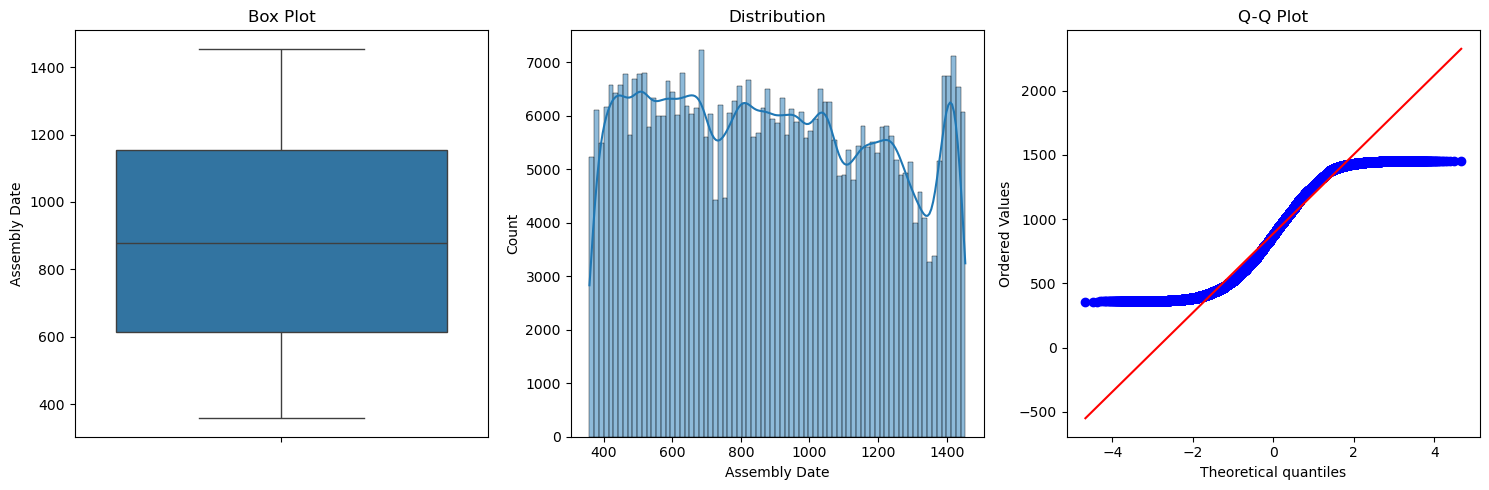


Visualizations for Average Weekly Wage


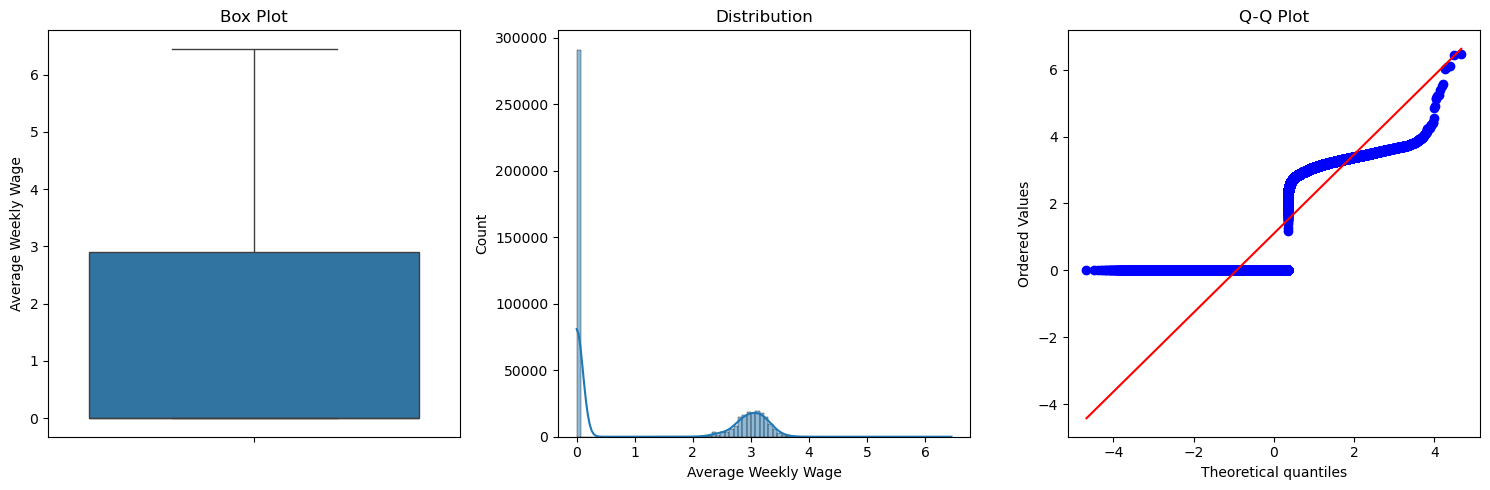


Visualizations for Birth Year


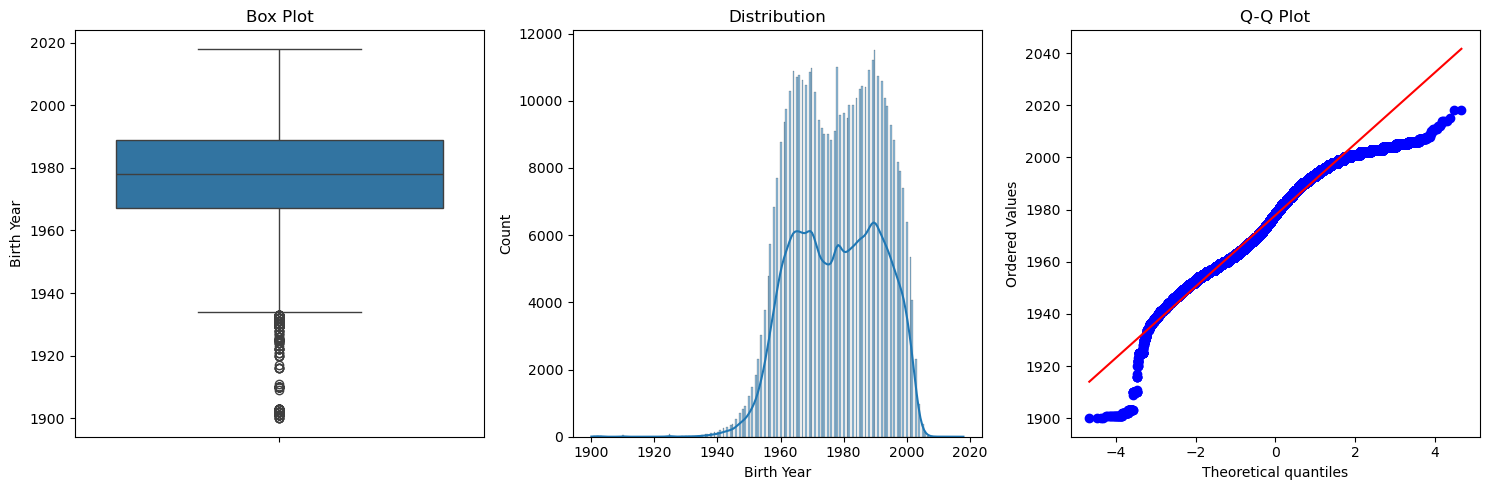


Visualizations for C-2 Date


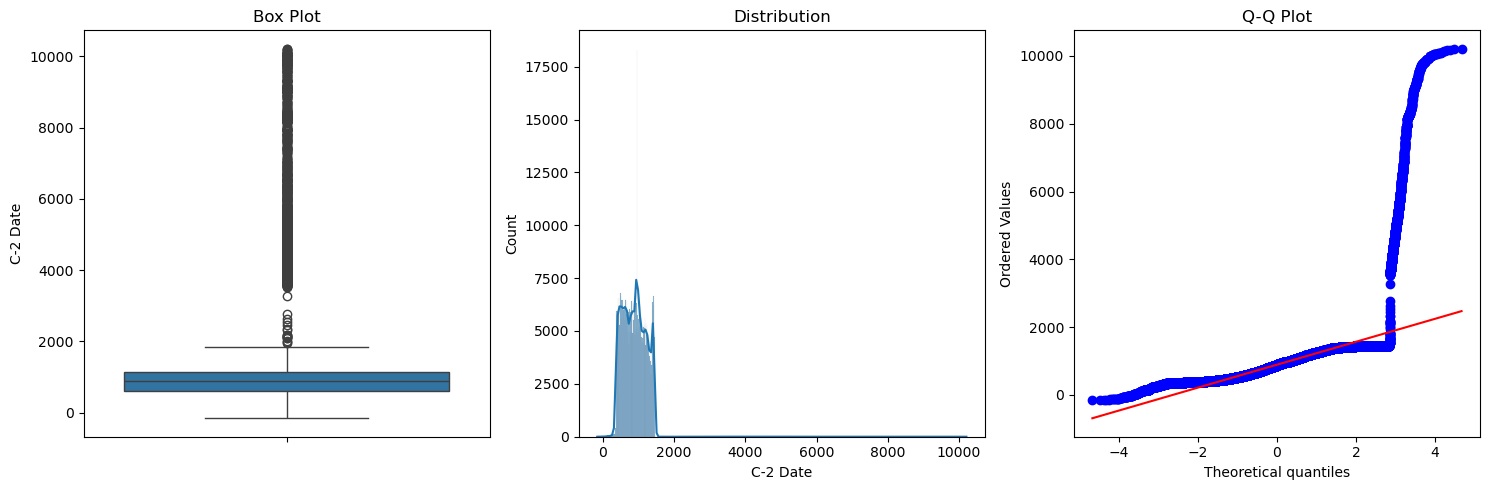


Visualizations for C-3 Date


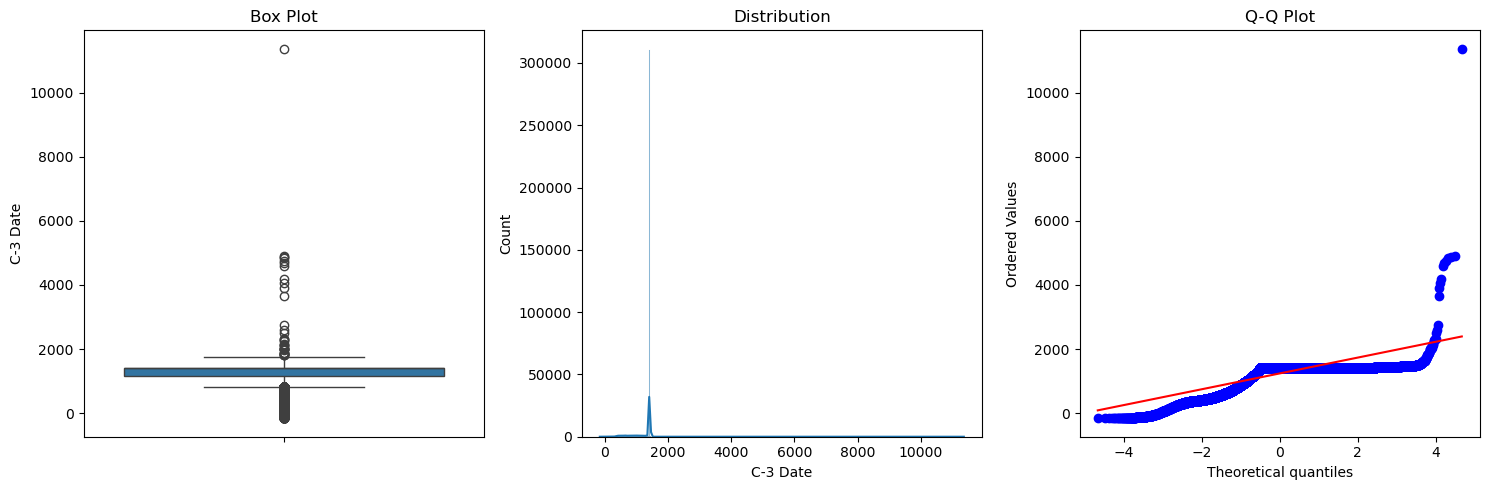


Visualizations for Carrier Name


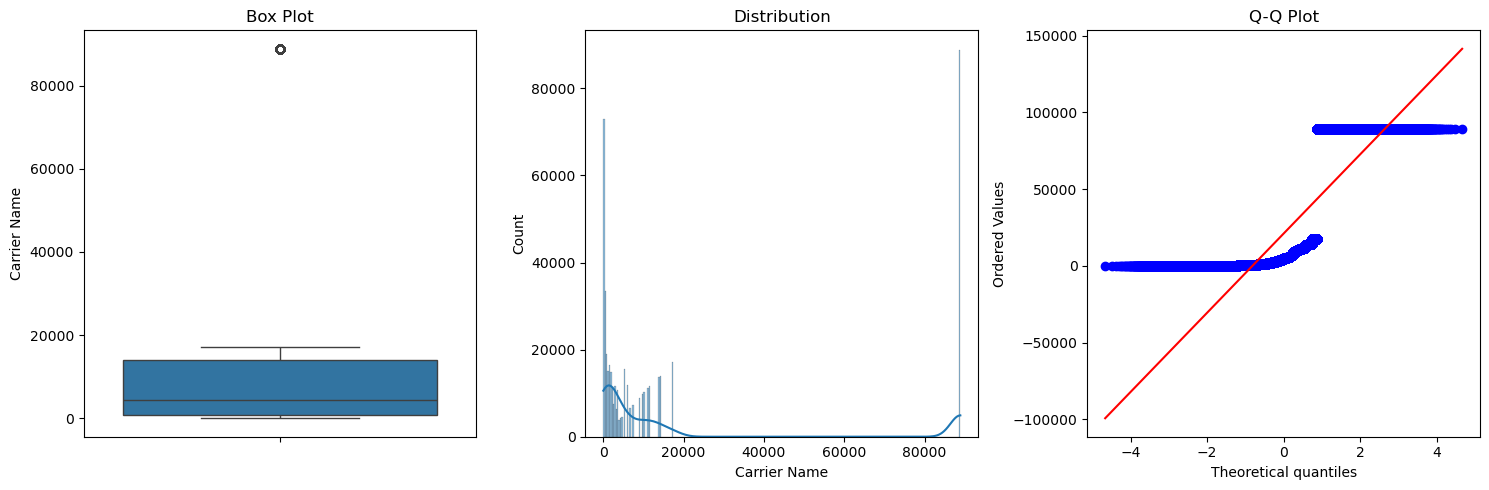


Visualizations for Carrier Type


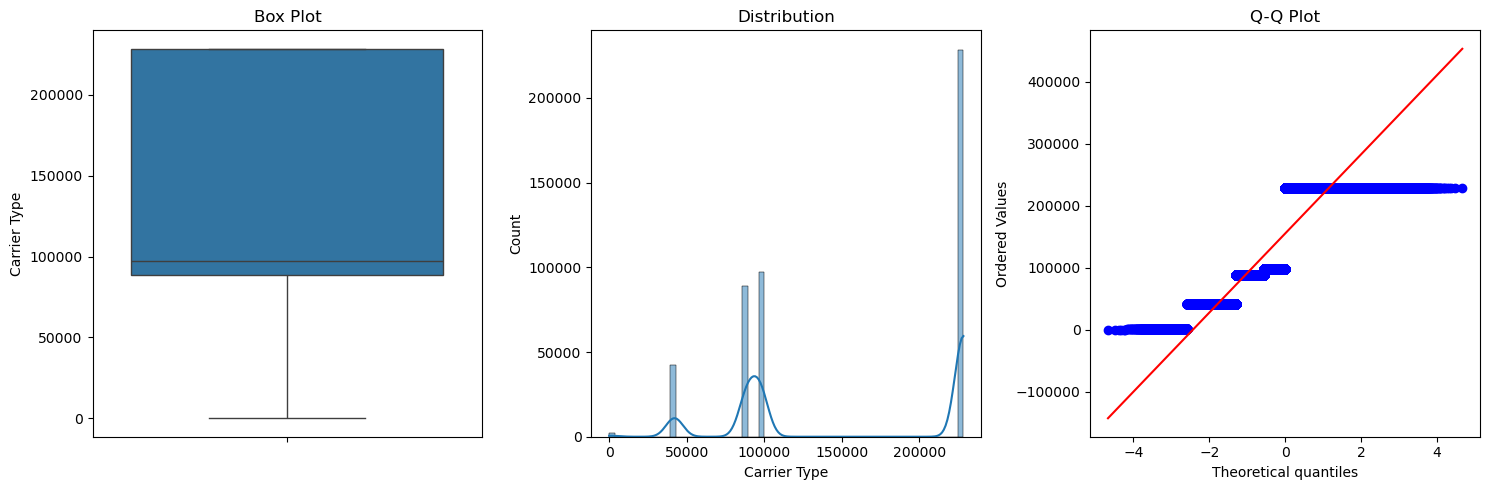


Visualizations for County of Injury


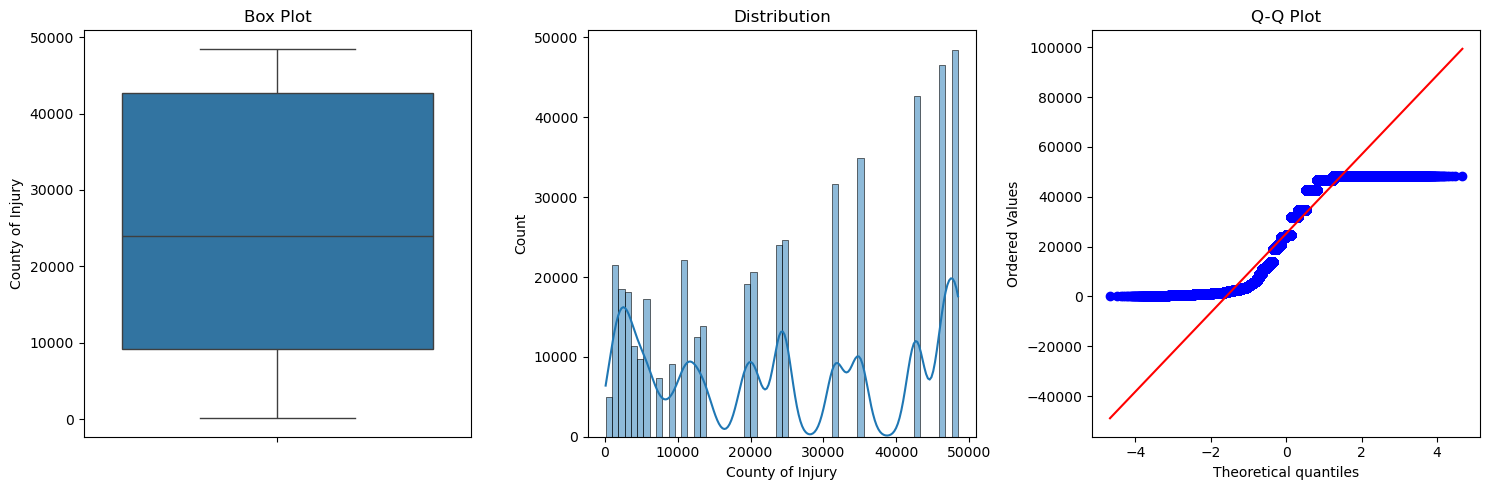


Visualizations for District Name


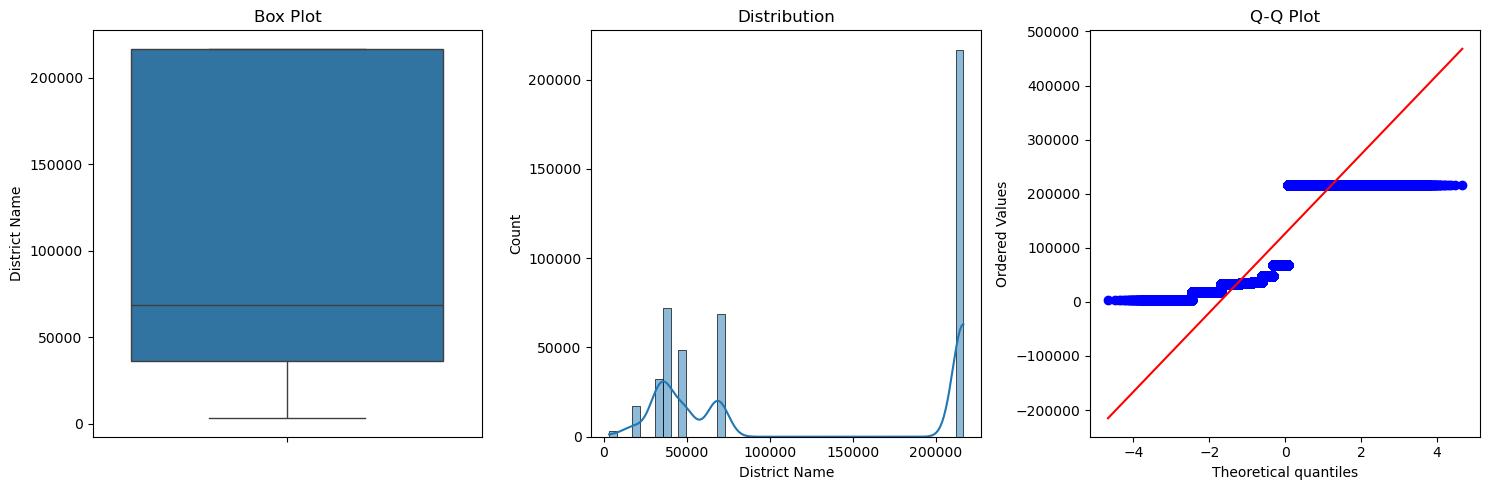


Visualizations for First Hearing Date


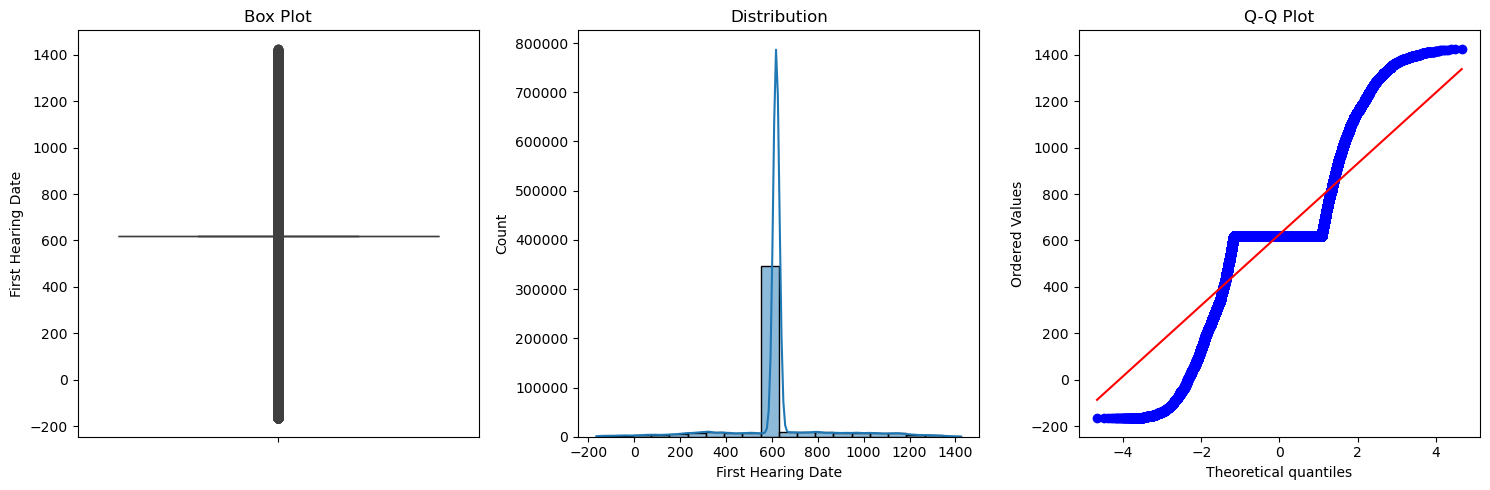


Visualizations for IME-4 Count


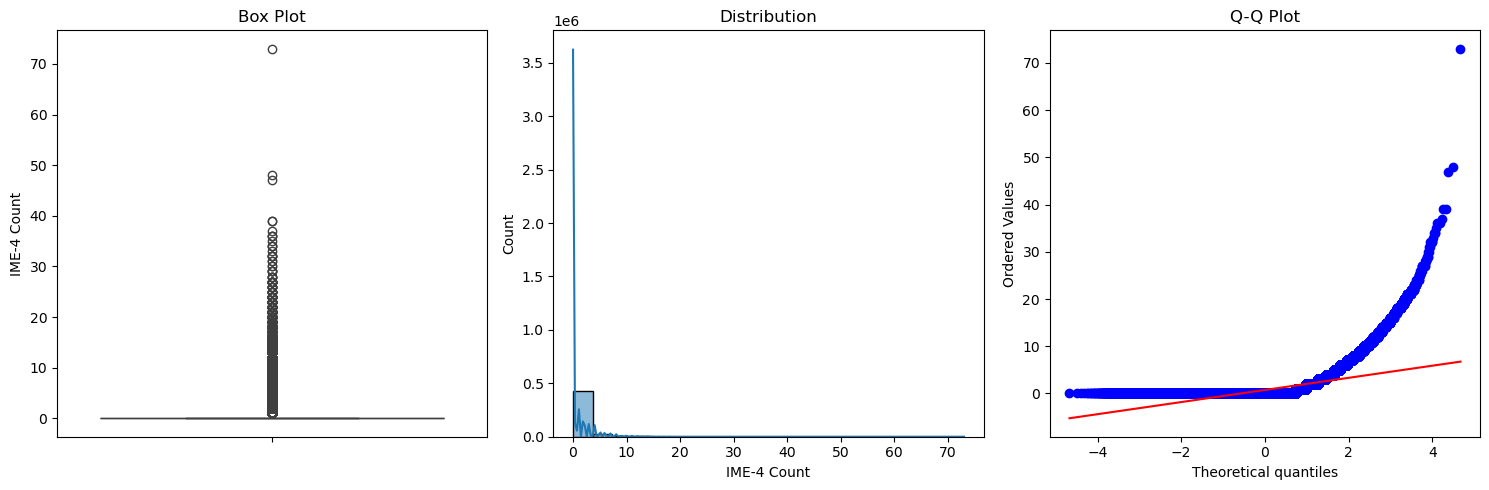


Visualizations for Industry Code


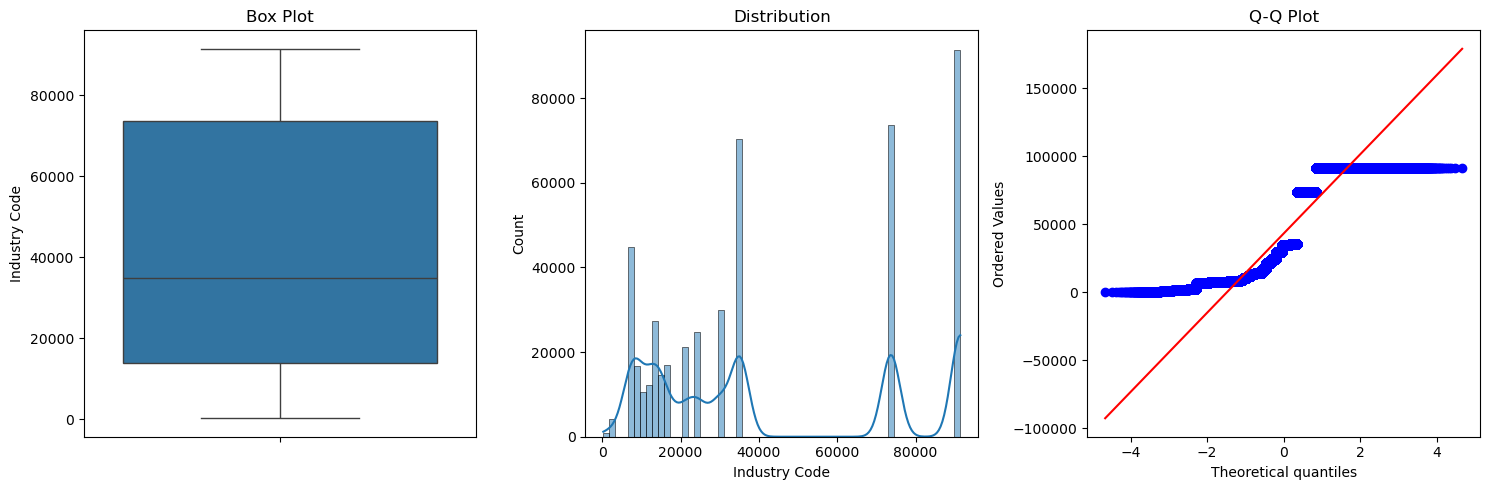


Visualizations for Medical Fee Region


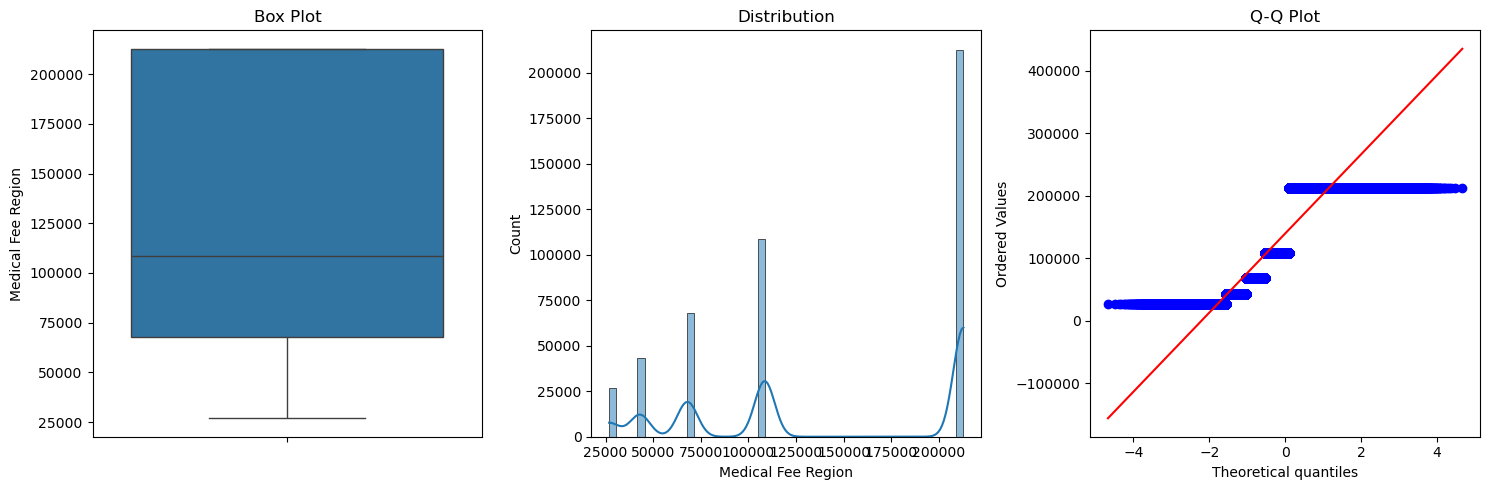


Visualizations for WCIO Cause of Injury Code


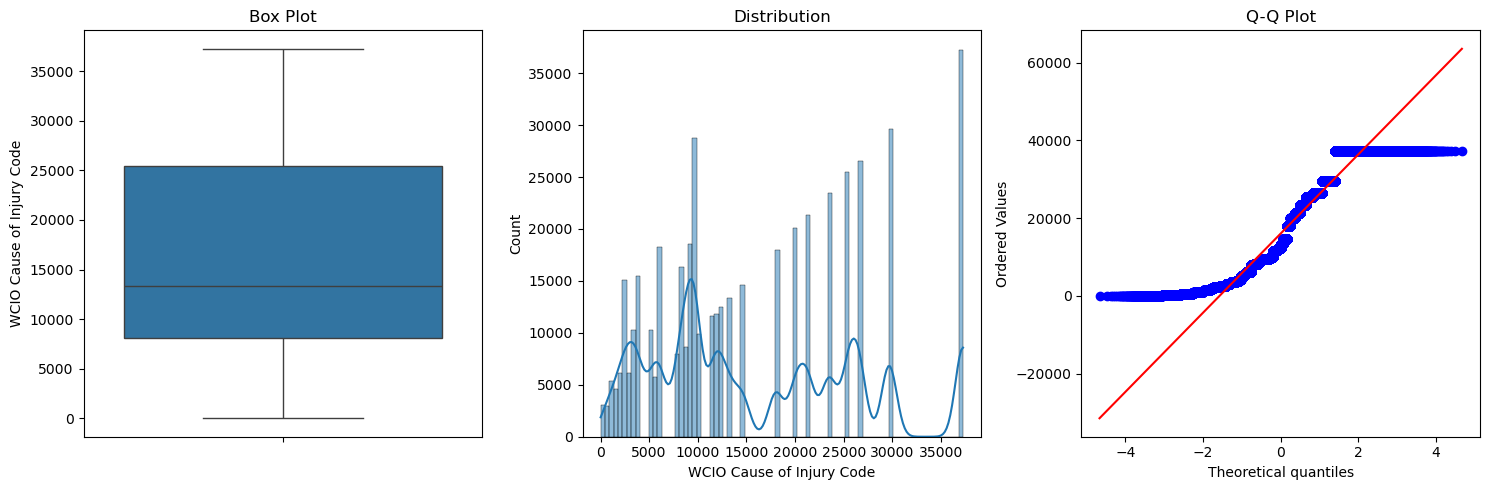


Visualizations for WCIO Nature of Injury Code


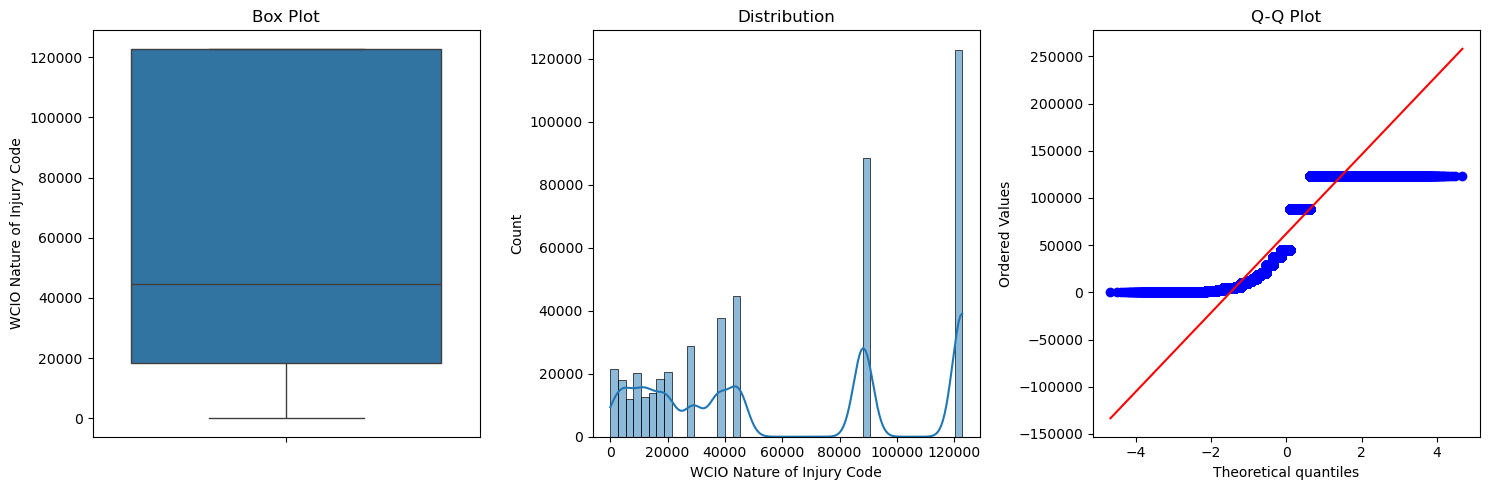


Visualizations for WCIO Part Of Body Code


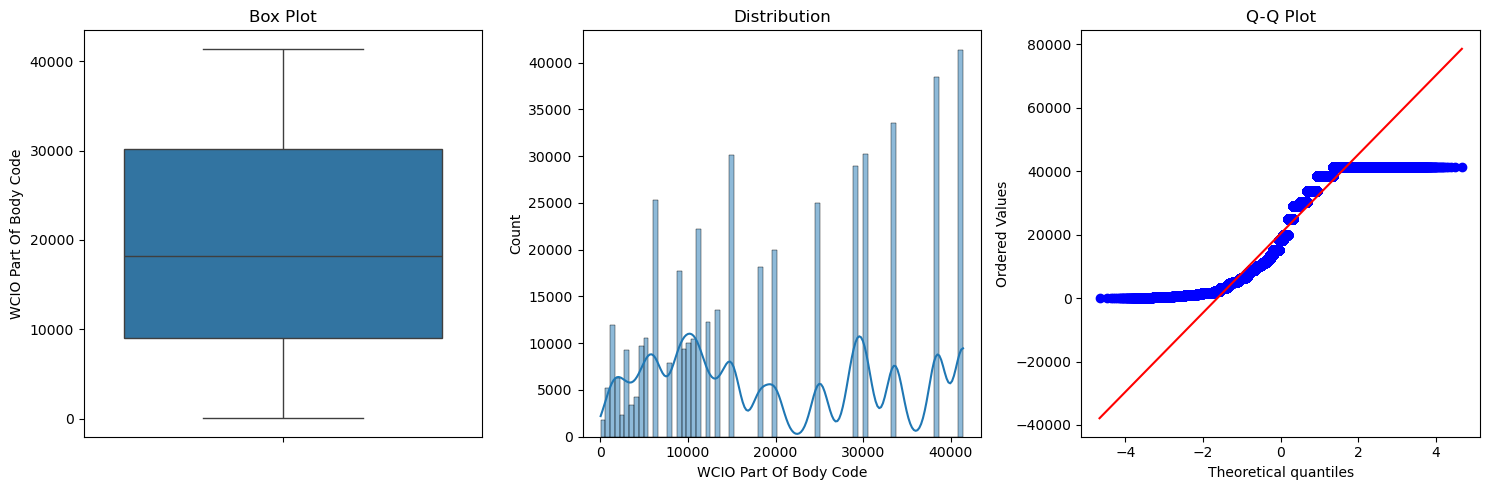


Visualizations for Agreement Reached


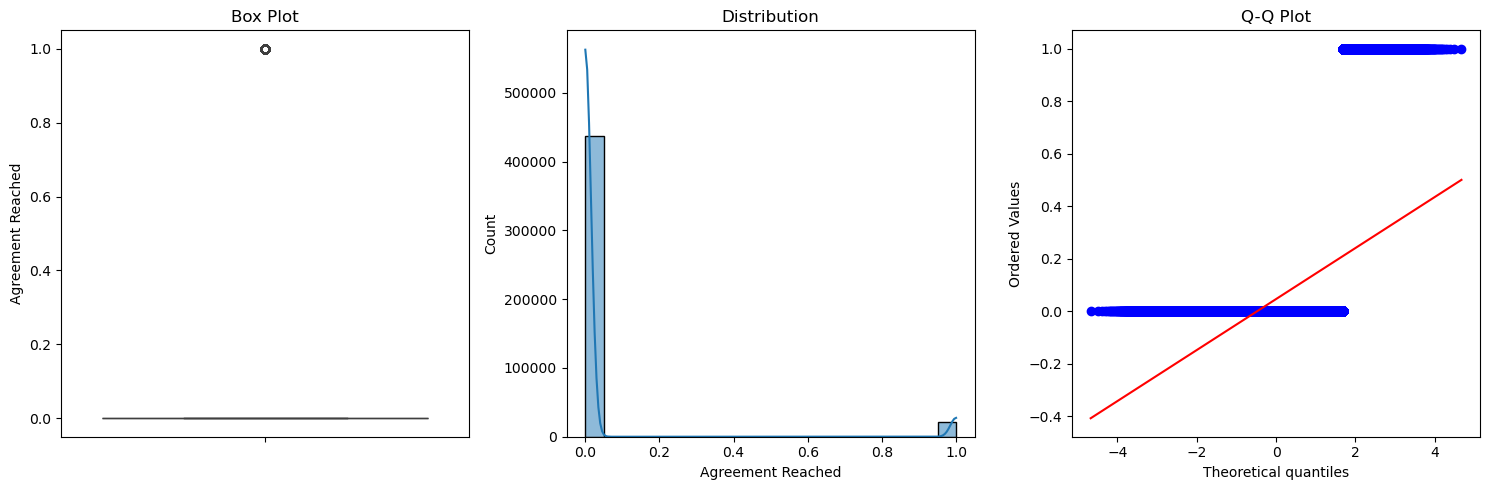


Visualizations for Number of Dependents


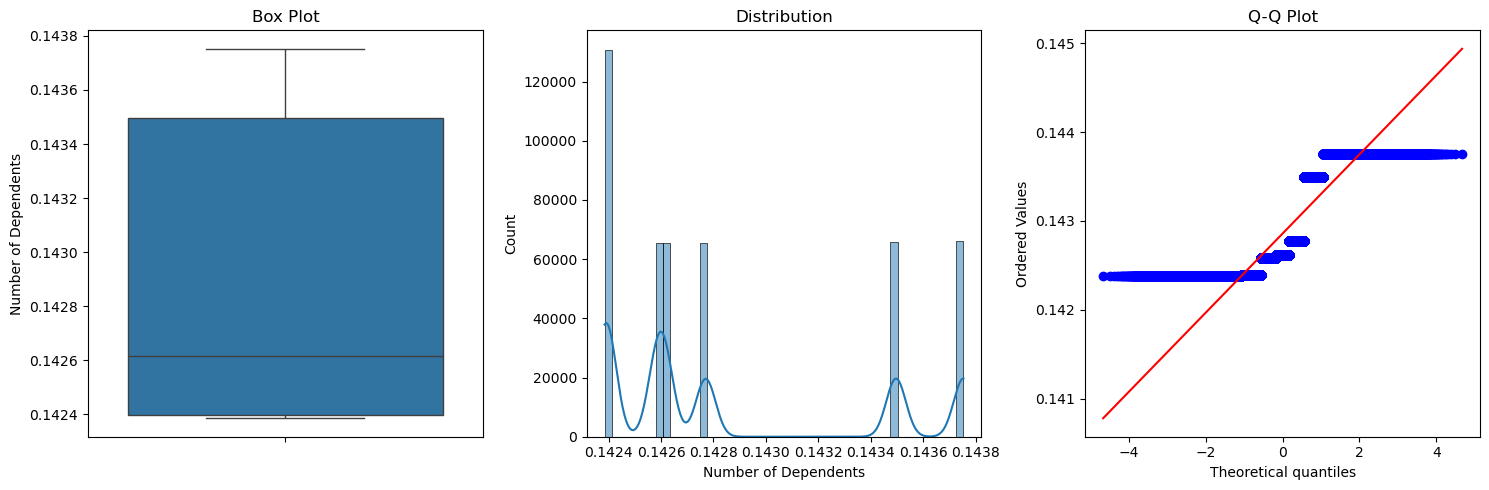


Visualizations for Accident Year


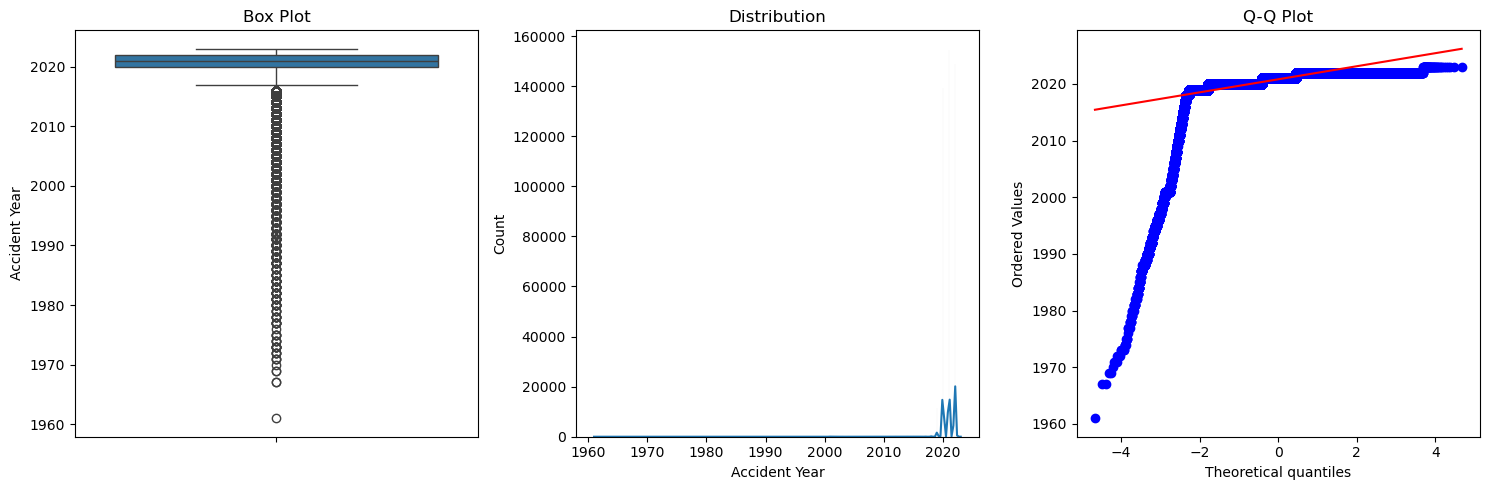


Visualizations for Accident Month


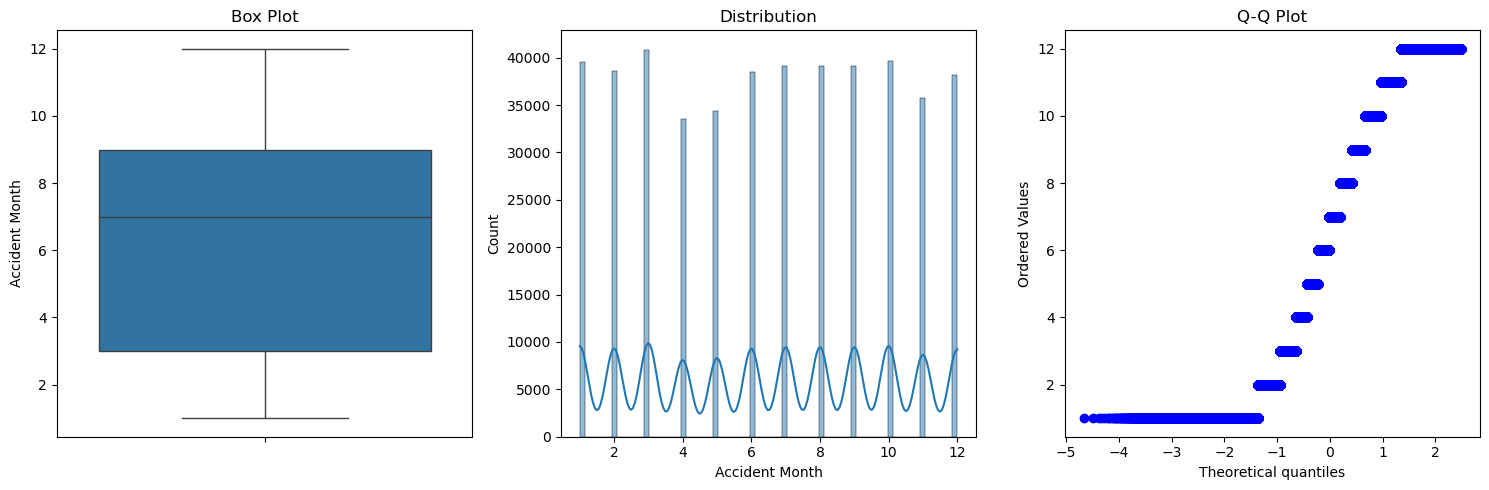


Visualizations for Accident Day


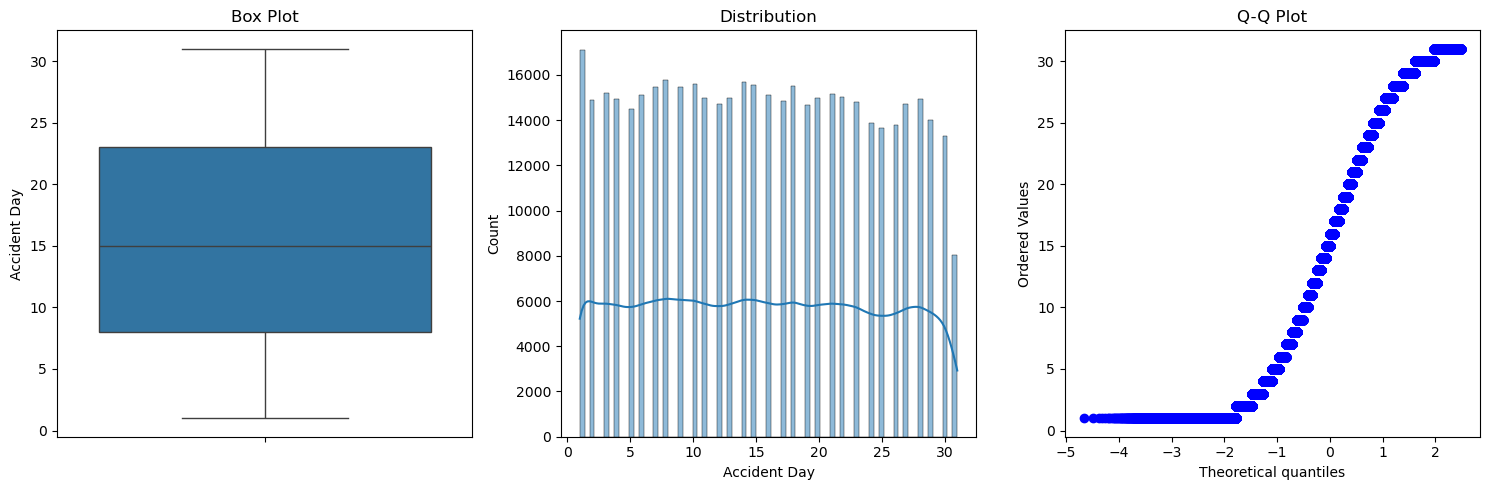


Visualizations for Days_to_Assembly


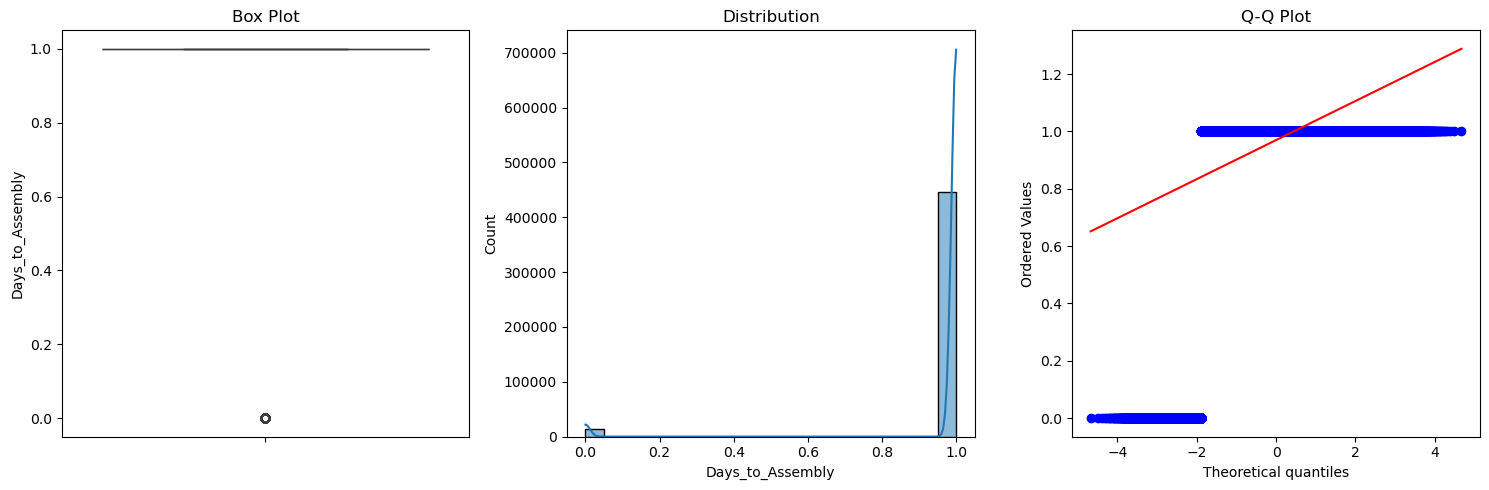


Visualizations for Under_20


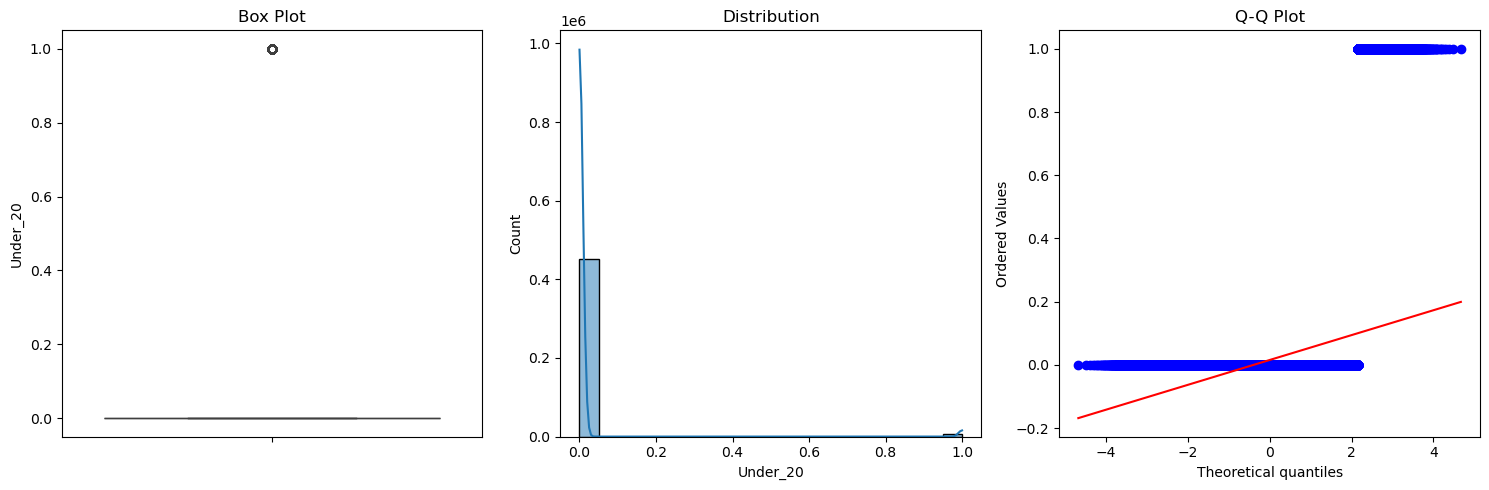


Visualizations for Age_21_40


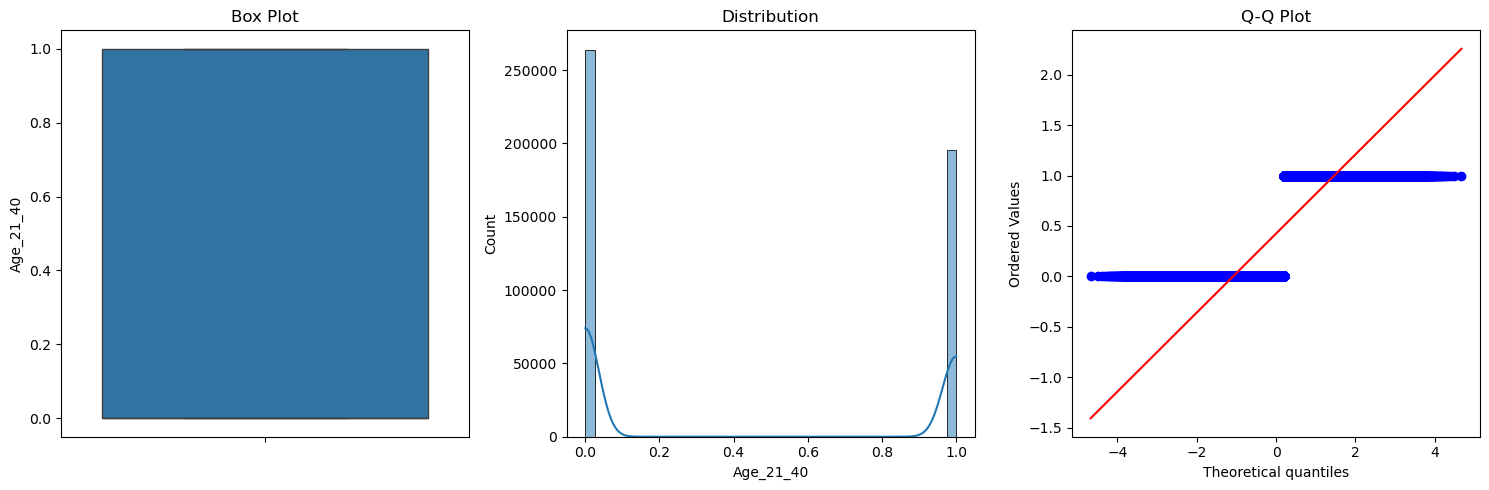


Visualizations for Age_41_65


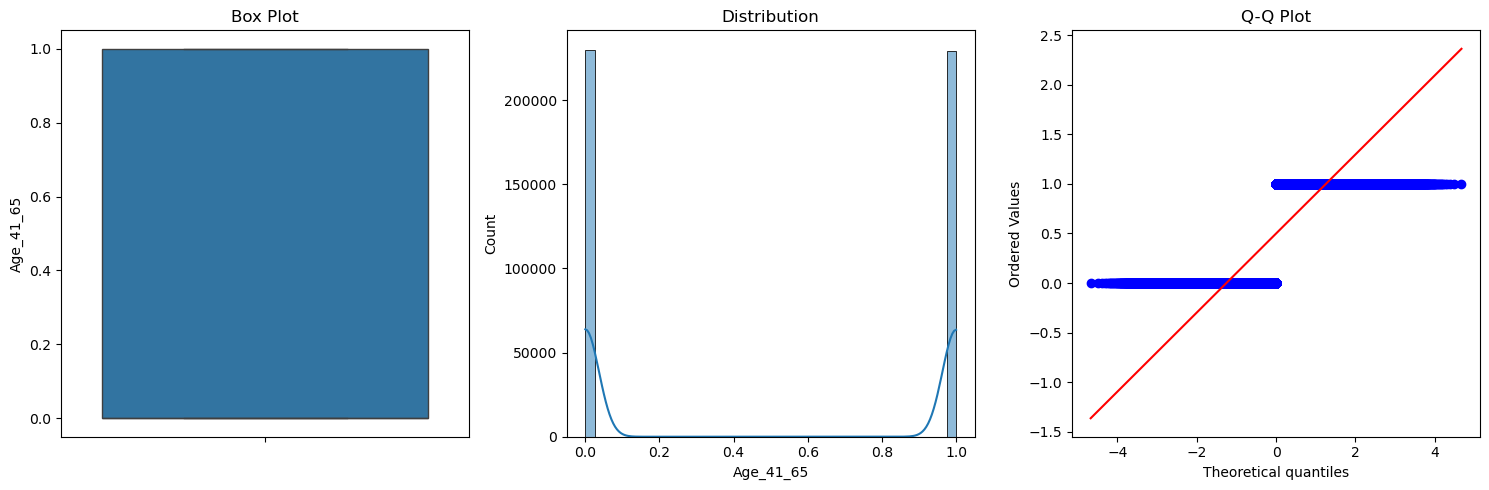


Visualizations for Above_65


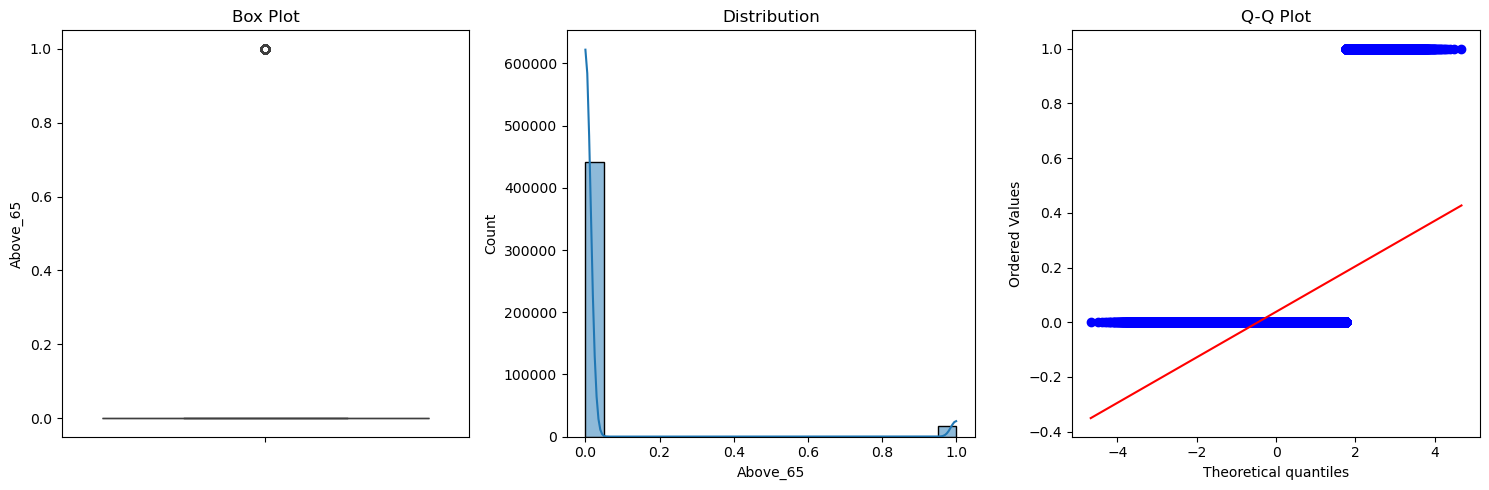


Visualizations for Accident Month Sin


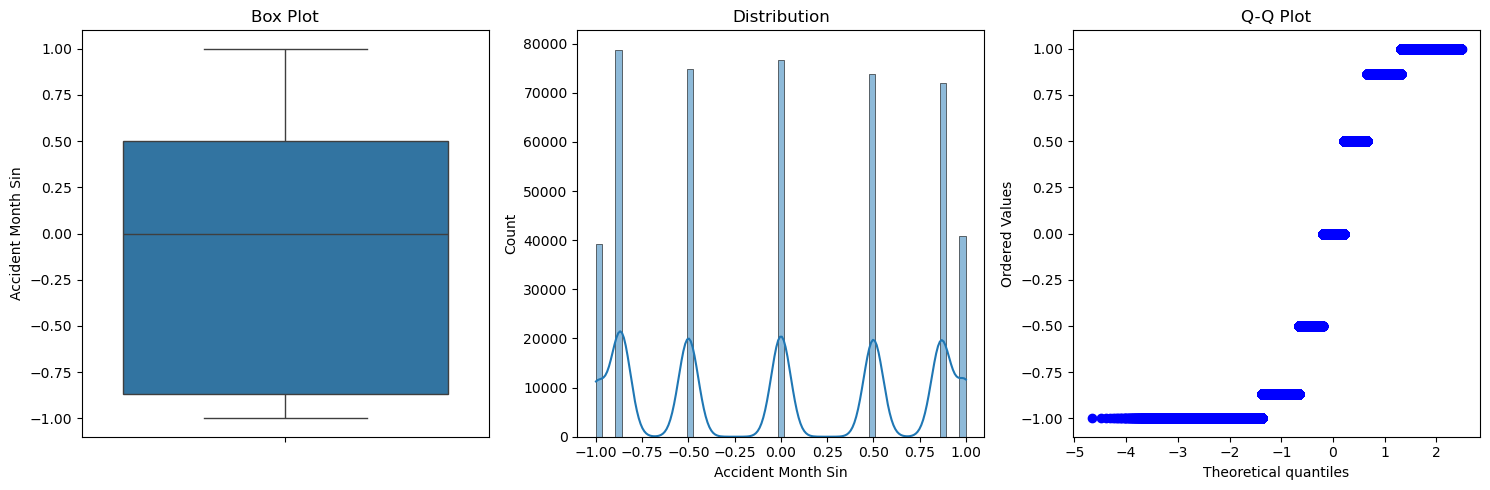


Visualizations for Accident Month Cos


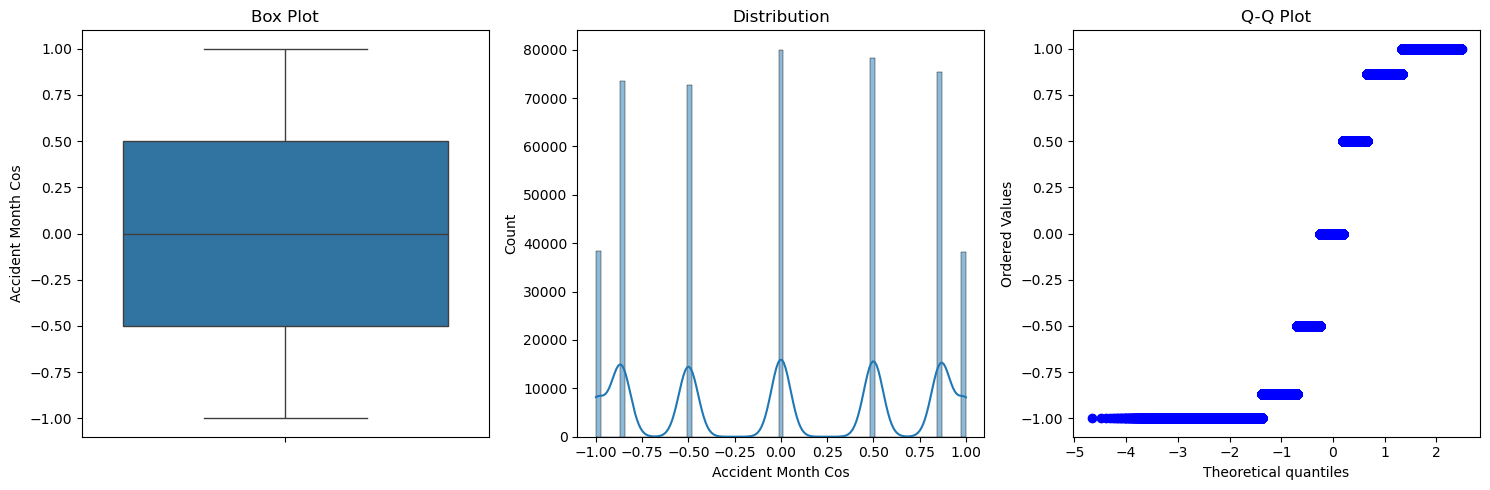


Visualizations for Accident Day Sin


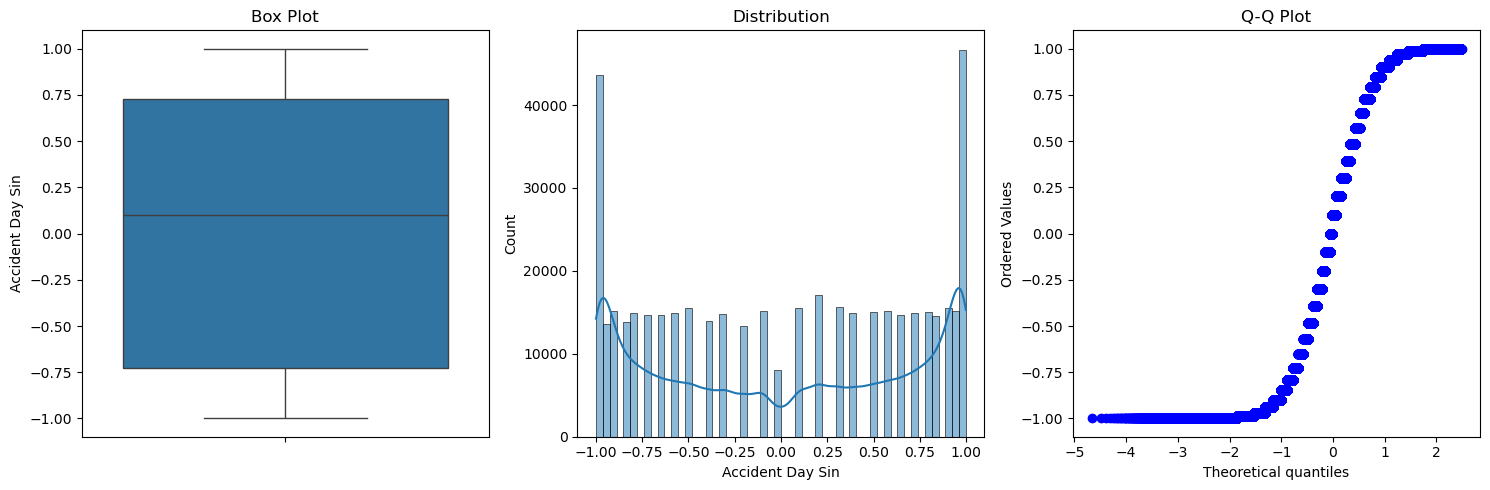


Visualizations for Accident Day Cos


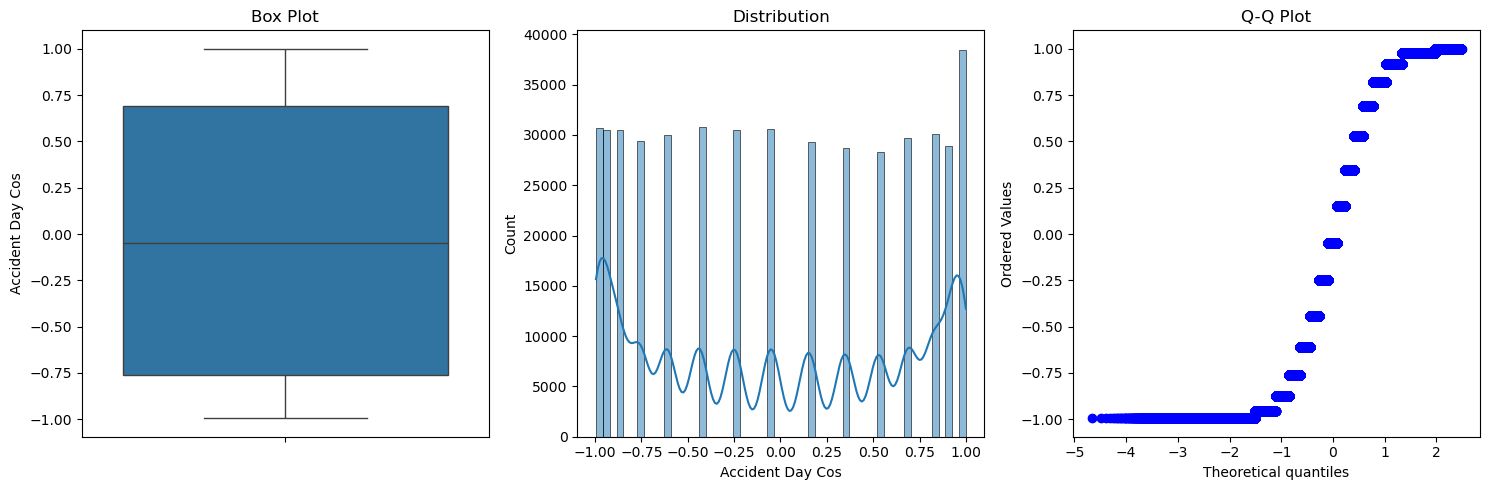


Visualizations for COVID-19 Indicator_Y


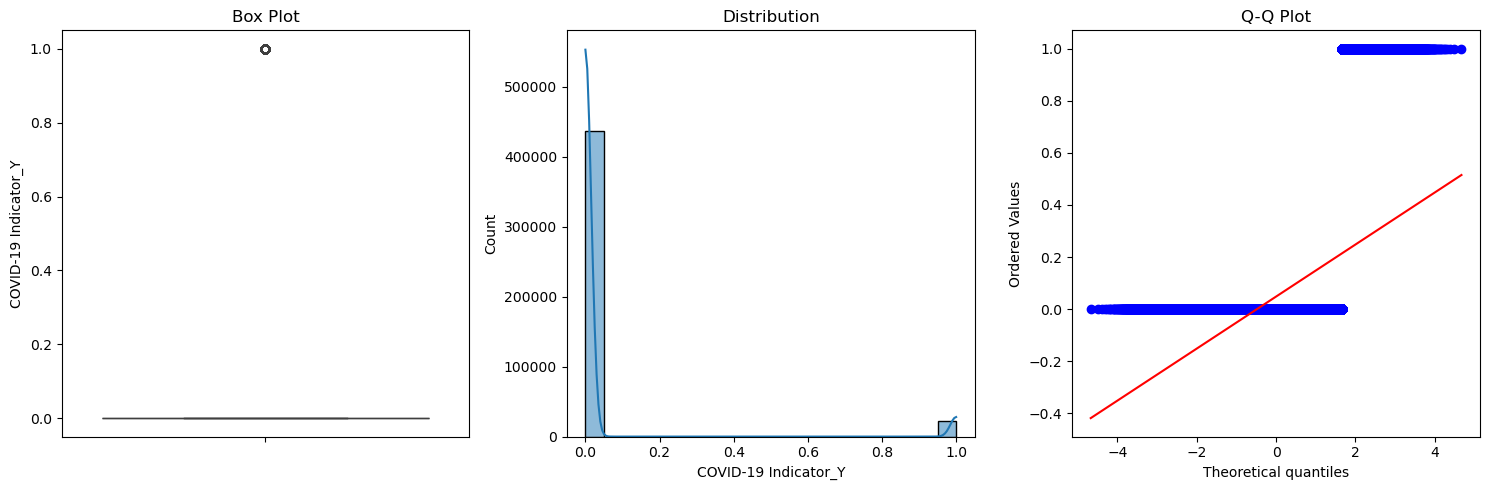


Visualizations for Alternative Dispute Resolution_U


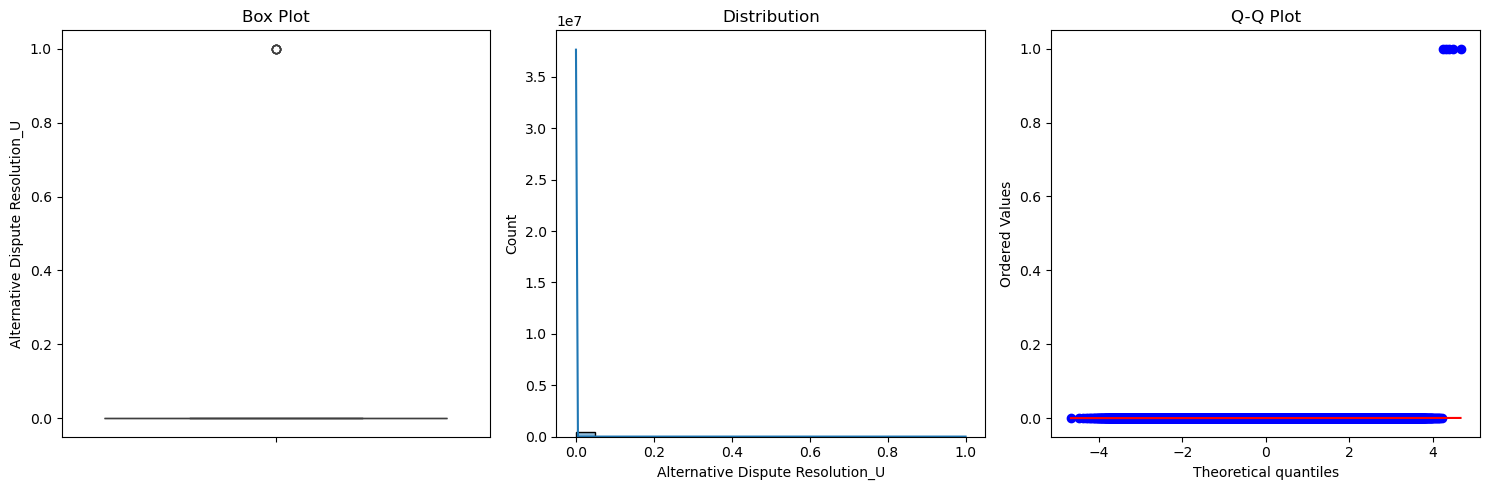


Visualizations for Alternative Dispute Resolution_Y


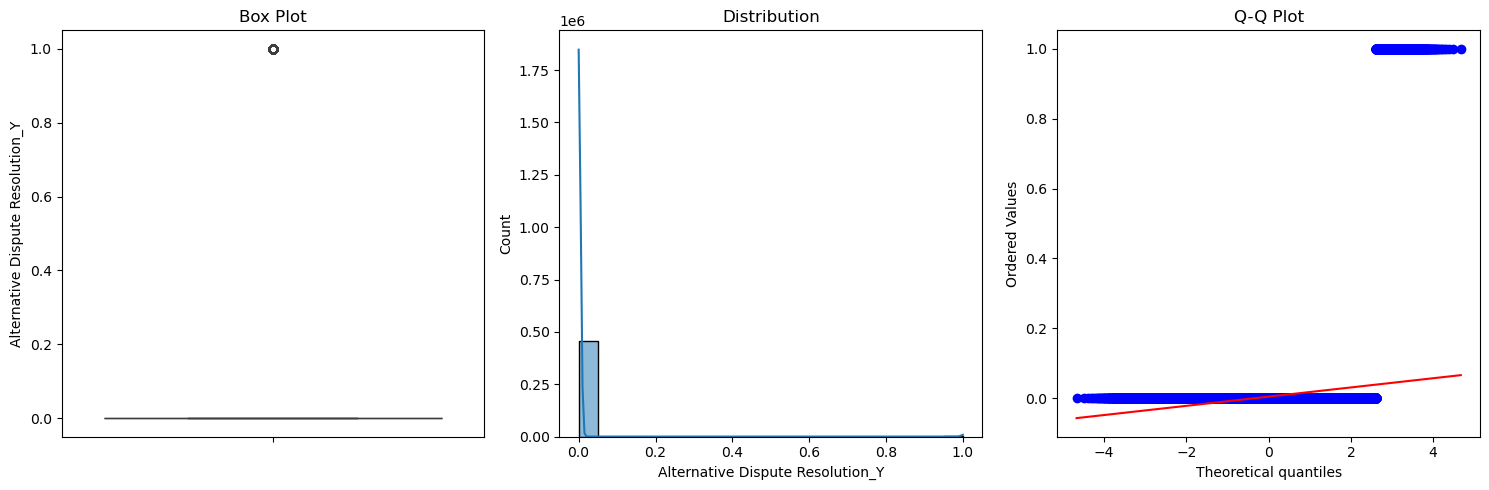

In [96]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_outliers(df, exclude_columns=None):
    """
    Generate detailed outlier analysis report for numeric columns

    Parameters:
    df (pandas.DataFrame): Input DataFrame
    exclude_columns (list): Columns to exclude from analysis
    """
    # Initialize results dictionary
    results = {}

    # Get numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if exclude_columns:
        numeric_cols = [col for col in numeric_cols if col not in exclude_columns]

    for column in numeric_cols:
        # Basic statistics
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate z-scores
        z_scores = np.abs(stats.zscore(df[column], nan_policy='omit'))

        # Calculate modified z-scores
        median = df[column].median()
        mad = stats.median_abs_deviation(df[column], nan_policy='omit')
        modified_z_scores = np.abs(0.6745 * (df[column] - median) / mad)

        # Identify outliers using different methods
        iqr_outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
        z_score_outliers = z_scores > 3
        modified_z_outliers = modified_z_scores > 3.5

        # Get extreme values
        outlier_values = df[column][iqr_outliers].values

        results[column] = {
            'basic_stats': {
                'mean': df[column].mean(),
                'median': df[column].median(),
                'std': df[column].std(),
                'min': df[column].min(),
                'max': df[column].max(),
                'Q1': Q1,
                'Q3': Q3,
                'IQR': IQR
            },
            'outliers': {
                'IQR_method': {
                    'count': iqr_outliers.sum(),
                    'percentage': (iqr_outliers.sum() / len(df)) * 100,
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound
                },
                'Z_score': {
                    'count': z_score_outliers.sum(),
                    'percentage': (z_score_outliers.sum() / len(df)) * 100
                },
                'Modified_Z': {
                    'count': modified_z_outliers.sum(),
                    'percentage': (modified_z_outliers.sum() / len(df)) * 100
                }
            },
            'extreme_values': {
                'top_10': df[column].nlargest(10).to_dict(),
                'bottom_10': df[column].nsmallest(10).to_dict(),
                'outlier_summary': {
                    'count': len(outlier_values),
                    'unique_values': np.unique(outlier_values).tolist()[:10]  # First 10 unique outliers
                }
            }
        }

        # Add skewness and kurtosis
        results[column]['distribution'] = {
            'skewness': stats.skew(df[column].dropna()),
            'kurtosis': stats.kurtosis(df[column].dropna())
        }

    return results

def print_outlier_report(results):
    """Print formatted outlier analysis results"""
    print("\n=== DETAILED OUTLIER ANALYSIS REPORT ===\n")

    for column, stats in results.items():
        print(f"\n{'='*80}")
        print(f"COLUMN: {column}")
        print(f"{'='*80}")

        # Basic Statistics
        print("\n1. BASIC STATISTICS:")
        print(f"{'*'*20}")
        basic = stats['basic_stats']
        print(f"Mean: {basic['mean']:.2f}")
        print(f"Median: {basic['median']:.2f}")
        print(f"Standard Deviation: {basic['std']:.2f}")
        print(f"Range: [{basic['min']:.2f}, {basic['max']:.2f}]")
        print(f"IQR: {basic['IQR']:.2f} (Q1: {basic['Q1']:.2f}, Q3: {basic['Q3']:.2f})")

        # Distribution Characteristics
        print("\n2. DISTRIBUTION CHARACTERISTICS:")
        print(f"{'*'*20}")
        dist = stats['distribution']
        print(f"Skewness: {dist['skewness']:.2f}")
        print(f"Kurtosis: {dist['kurtosis']:.2f}")

        # Outlier Detection Results
        print("\n3. OUTLIER DETECTION:")
        print(f"{'*'*20}")
        out = stats['outliers']

        print("\nIQR Method:")
        print(f"- Count: {out['IQR_method']['count']}")
        print(f"- Percentage: {out['IQR_method']['percentage']:.2f}%")
        print(f"- Bounds: [{out['IQR_method']['lower_bound']:.2f}, {out['IQR_method']['upper_bound']:.2f}]")

        print("\nZ-Score Method (>3 std):")
        print(f"- Count: {out['Z_score']['count']}")
        print(f"- Percentage: {out['Z_score']['percentage']:.2f}%")

        print("\nModified Z-Score Method:")
        print(f"- Count: {out['Modified_Z']['count']}")
        print(f"- Percentage: {out['Modified_Z']['percentage']:.2f}%")

        # Extreme Values
        print("\n4. EXTREME VALUES:")
        print(f"{'*'*20}")
        ext = stats['extreme_values']

        print("\nTop 10 Highest Values:")
        for i, (idx, val) in enumerate(ext['top_10'].items(), 1):
            print(f"{i}. Index {idx}: {val:.2f}")

        print("\nBottom 10 Lowest Values:")
        for i, (idx, val) in enumerate(ext['bottom_10'].items(), 1):
            print(f"{i}. Index {idx}: {val:.2f}")

        print("\n")

# Execute the analysis
# Exclude binary and categorical columns
exclude_cols = ['Received_C2', 'Received_C3', 'Hearing_held', 'Gender_M',
                'Attorney/Representative_Y', 'COVID-19_Indicator_Y',
                'Alternative_Dispute_Resolution_U', 'Alternative_Dispute_Resolution_Y']

# Run analysis
outlier_results = analyze_outliers(train_numerical, exclude_columns=exclude_cols)

# Print report
print_outlier_report(outlier_results)

# Optional: Create visualizations for each numeric column
def plot_outlier_analysis(train_numerical, column):
    plt.figure(figsize=(15, 5))

    # Box plot
    plt.subplot(131)
    sns.boxplot(y=train_numerical[column])
    plt.title('Box Plot')

    # Histogram with KDE
    plt.subplot(132)
    sns.histplot(train_numerical[column], kde=True)
    plt.title('Distribution')

    # QQ plot
    plt.subplot(133)
    stats.probplot(train_numerical[column], dist="norm", plot=plt)
    plt.title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

# Create plots for each numeric column
for column in outlier_results.keys():
    print(f"\nVisualizations for {column}")
    plot_outlier_analysis(train_numerical, column)

Removal of outliers

In [97]:
def handle_outliers(df):
    df_clean = df.copy()
    modifications = {}

    # Track modifications for each column
    for col in df_clean.columns:
        modifications[col] = {
            'original_count': len(df_clean),
            'modified_count': 0,
            'lower_bound': None,
            'upper_bound': None
        }

    # Date fields
    date_cols = ['C-2 Date', 'C-3 Date', 'First Hearing Date']
    for col in date_cols:
        lower_bound = df_clean[col].quantile(0.001)
        upper_bound = df_clean[col].quantile(0.999)
        lower_mask = df_clean[col] < lower_bound
        upper_mask = df_clean[col] > upper_bound

        df_clean.loc[lower_mask, col] = lower_bound
        df_clean.loc[upper_mask, col] = upper_bound

        modifications[col].update({
            'modified_count': (lower_mask | upper_mask).sum(),
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        })

    # Birth Year
    birth_lower = df_clean['Birth Year'].quantile(0.001)
    birth_upper = df_clean['Birth Year'].quantile(0.999)
    birth_lower_mask = df_clean['Birth Year'] < birth_lower
    birth_upper_mask = df_clean['Birth Year'] > birth_upper

    df_clean.loc[birth_lower_mask, 'Birth Year'] = birth_lower
    df_clean.loc[birth_upper_mask, 'Birth Year'] = birth_upper

    modifications['Birth Year'].update({
        'modified_count': (birth_lower_mask | birth_upper_mask).sum(),
        'lower_bound': birth_lower,
        'upper_bound': birth_upper
    })

    # IME-4 Count
    ime_lower = df_clean['IME-4 Count'].quantile(0.025)
    ime_upper = df_clean['IME-4 Count'].quantile(0.975)
    ime_lower_mask = df_clean['IME-4 Count'] < ime_lower
    ime_upper_mask = df_clean['IME-4 Count'] > ime_upper

    df_clean.loc[ime_lower_mask, 'IME-4 Count'] = ime_lower
    df_clean.loc[ime_upper_mask, 'IME-4 Count'] = ime_upper

    modifications['IME-4 Count'].update({
        'modified_count': (ime_lower_mask | ime_upper_mask).sum(),
        'lower_bound': ime_lower,
        'upper_bound': ime_upper
    })

    # Average Weekly Wage
    wage_lower = df_clean['Average Weekly Wage'].quantile(0.0025)
    wage_upper = df_clean['Average Weekly Wage'].quantile(0.9975)
    wage_lower_mask = df_clean['Average Weekly Wage'] < wage_lower
    wage_upper_mask = df_clean['Average Weekly Wage'] > wage_upper

    df_clean.loc[wage_lower_mask, 'Average Weekly Wage'] = wage_lower
    df_clean.loc[wage_upper_mask, 'Average Weekly Wage'] = wage_upper

    modifications['Average Weekly Wage'].update({
        'modified_count': (wage_lower_mask | wage_upper_mask).sum(),
        'lower_bound': wage_lower,
        'upper_bound': wage_upper
    })

    return df_clean, modifications

In [98]:
train_clean = handle_outliers(train_set)
val_clean = handle_outliers(val_set)
test_clean = handle_outliers(test)

C:\Users\HP\AppData\Local\Temp\ipykernel_22048\3106795648.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5619.343000000226' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[upper_mask, col] = upper_bound
C:\Users\HP\AppData\Local\Temp\ipykernel_22048\3106795648.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.218999999999994' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[lower_mask, col] = lower_bound
C:\Users\HP\AppData\Local\Temp\ipykernel_22048\3106795648.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5468.940000000162' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cle

# Analysis of new features, VIF MI And Correlations with Y and specific fatures used to justify feature creation

Because of the prevalency of high risk industry with covid around the datasets timeperiod i wasnted to test correlation between the 5% covid cases but the result was not significant in my opinion

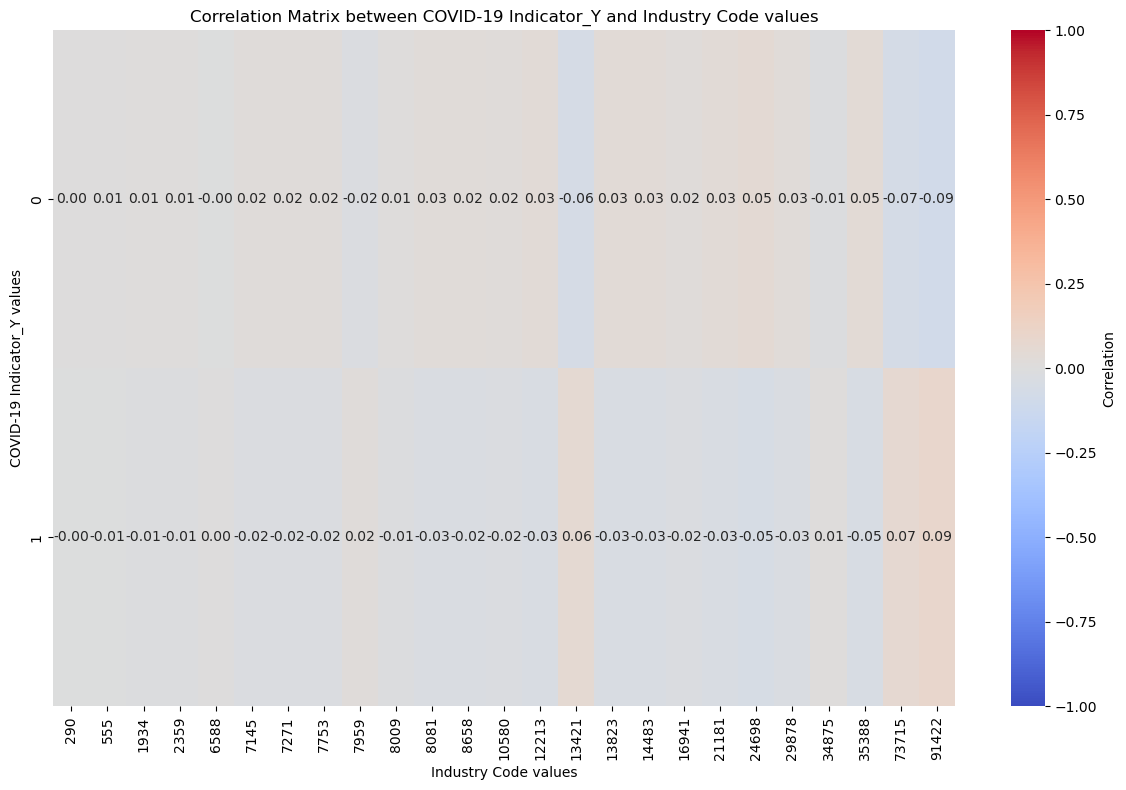


Strongest positive correlations:
91422  1    0.092808
73715  1    0.067580
13421  1    0.059819
24698  0    0.050399
35388  0    0.045164
dtype: float64

Strongest negative correlations:
91422  0   -0.092808
73715  0   -0.067580
13421  0   -0.059819
24698  1   -0.050399
35388  1   -0.045164
dtype: float64


In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def value_correlation_matrix(df, var1, var2):
    """
    Creates a correlation matrix between unique values of two frequency encoded variables.

    Parameters:
    df (pandas.DataFrame): Input dataframe
    var1 (str): First variable name
    var2 (str): Second variable name
    """
    # Get unique values
    unique_val1 = sorted(df[var1].unique())
    unique_val2 = sorted(df[var2].unique())

    # Create binary columns for each unique value
    matrix_data = pd.DataFrame()

    # Create binary columns for first variable
    for val in unique_val1:
        matrix_data[f'{var1}_{val}'] = (df[var1] == val).astype(int)

    # Create binary columns for second variable
    for val in unique_val2:
        matrix_data[f'{var2}_{val}'] = (df[var2] == val).astype(int)

    # Calculate correlation matrix
    correlation_matrix = matrix_data.corr()

    # Extract only the correlations between var1 and var2 values
    var1_cols = [col for col in correlation_matrix.columns if col.startswith(f'{var1}_')]
    var2_cols = [col for col in correlation_matrix.columns if col.startswith(f'{var2}_')]
    cross_correlations = correlation_matrix.loc[var1_cols, var2_cols]

    # Clean up column and index names
    cross_correlations.columns = [col.replace(f'{var2}_', '') for col in cross_correlations.columns]
    cross_correlations.index = [idx.replace(f'{var1}_', '') for idx in cross_correlations.index]

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_correlations,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlation'})
    plt.title(f'Correlation Matrix between {var1} and {var2} values')
    plt.xlabel(f'{var2} values')
    plt.ylabel(f'{var1} values')
    plt.tight_layout()
    plt.show()

    # Print some summary statistics
    print("\nStrongest positive correlations:")
    correlations_flat = cross_correlations.unstack()
    print(correlations_flat.nlargest(5))

    print("\nStrongest negative correlations:")
    print(correlations_flat.nsmallest(5))

    return cross_correlations

# Example usage
correlation_matrix = value_correlation_matrix(train_set, 'COVID-19 Indicator_Y', 'Industry Code')

Covid has some predictive power, but is divided 95-5 i wished to identify the values of Y that were prone to covid related outcomes

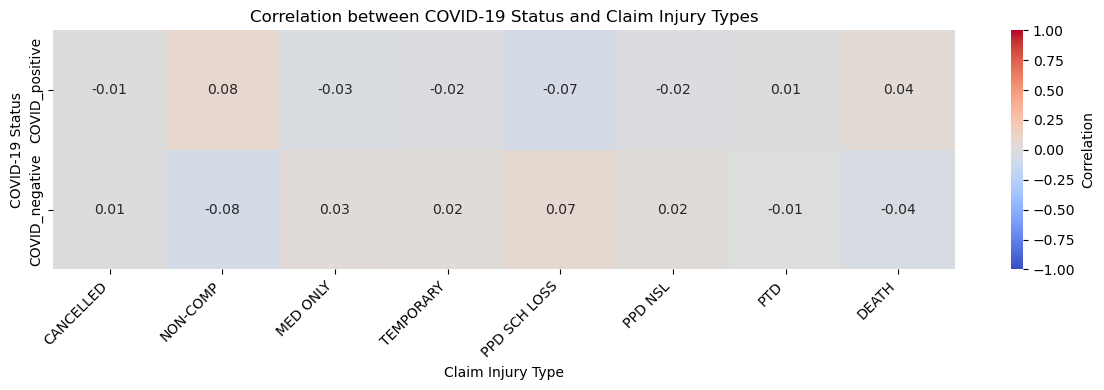


Strongest correlations for COVID-positive cases:
Positive correlations:
NON-COMP     0.076474
DEATH        0.041945
PTD          0.005733
CANCELLED   -0.010694
PPD NSL     -0.015990
Name: COVID_positive, dtype: float64

Negative correlations:
PPD SCH LOSS   -0.067545
MED ONLY       -0.026937
TEMPORARY      -0.020737
PPD NSL        -0.015990
CANCELLED      -0.010694
Name: COVID_positive, dtype: float64

Strongest correlations for COVID-negative cases:
Positive correlations:
PPD SCH LOSS    0.067545
MED ONLY        0.026937
TEMPORARY       0.020737
PPD NSL         0.015990
CANCELLED       0.010694
Name: COVID_negative, dtype: float64

Negative correlations:
NON-COMP    -0.076474
DEATH       -0.041945
PTD         -0.005733
CANCELLED    0.010694
PPD NSL      0.015990
Name: COVID_negative, dtype: float64

Distribution of Injury Types:
2. NON-COMP: 291078 cases (50.71%)
4. TEMPORARY: 148507 cases (25.87%)
3. MED ONLY: 68906 cases (12.0%)
5. PPD SCH LOSS: 48280 cases (8.41%)
1. CANCELLED: 12

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def value_correlation_matrix(train_df, covid_var, injury_series):
    """
    Creates a correlation matrix between both COVID-19 indicator values and claim injury types.

    Parameters:
    train_df (pandas.DataFrame): Training dataframe with COVID indicator
    covid_var (str): COVID-19 indicator variable name
    injury_series (pandas.Series): Series containing injury types
    """
    # Create a DataFrame with both COVID positive and negative indicators
    matrix_data = pd.DataFrame({
        'COVID_positive': train_df[covid_var].astype(int),
        'COVID_negative': (train_df[covid_var] == 0).astype(int)
    })

    # Create binary columns for each injury type
    for injury_type in sorted(injury_series.unique()):
        # Remove the numeric prefix for cleaner labels
        clean_name = injury_type.split('. ')[1] if '. ' in injury_type else injury_type
        matrix_data[f'injury_{clean_name}'] = (injury_series == injury_type).astype(int)

    # Calculate correlation matrix
    correlation_matrix = matrix_data.corr()

    # Extract correlations between COVID and injury types
    injury_cols = [col for col in correlation_matrix.columns if col.startswith('injury_')]
    cross_correlations = correlation_matrix.loc[['COVID_positive', 'COVID_negative'], injury_cols]

    # Clean up column names for display
    cross_correlations.columns = [col.replace('injury_', '') for col in cross_correlations.columns]

    # Plotting
    plt.figure(figsize=(12, 4))
    sns.heatmap(cross_correlations,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlation'})
    plt.title('Correlation between COVID-19 Status and Claim Injury Types')
    plt.xlabel('Claim Injury Type')
    plt.ylabel('COVID-19 Status')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print summary statistics for positive cases
    correlations_pos = cross_correlations.loc['COVID_positive']
    correlations_neg = cross_correlations.loc['COVID_negative']

    print("\nStrongest correlations for COVID-positive cases:")
    print("Positive correlations:")
    print(correlations_pos.nlargest(5))
    print("\nNegative correlations:")
    print(correlations_pos.nsmallest(5))

    print("\nStrongest correlations for COVID-negative cases:")
    print("Positive correlations:")
    print(correlations_neg.nlargest(5))
    print("\nNegative correlations:")
    print(correlations_neg.nsmallest(5))

    # Print value counts for reference
    print("\nDistribution of Injury Types:")
    value_counts = injury_series.value_counts()
    total = len(injury_series)
    percentages = (value_counts / total * 100).round(2)
    for val, count in value_counts.items():
        print(f"{val}: {count} cases ({percentages[val]}%)")

    return cross_correlations

# Example usage
correlation_matrix = value_correlation_matrix(
    train_set,
    'COVID-19 Indicator_Y',
    y
)

Again no true predictive power indications for covid, for Attorney the same argument as COVID analysis goes so:

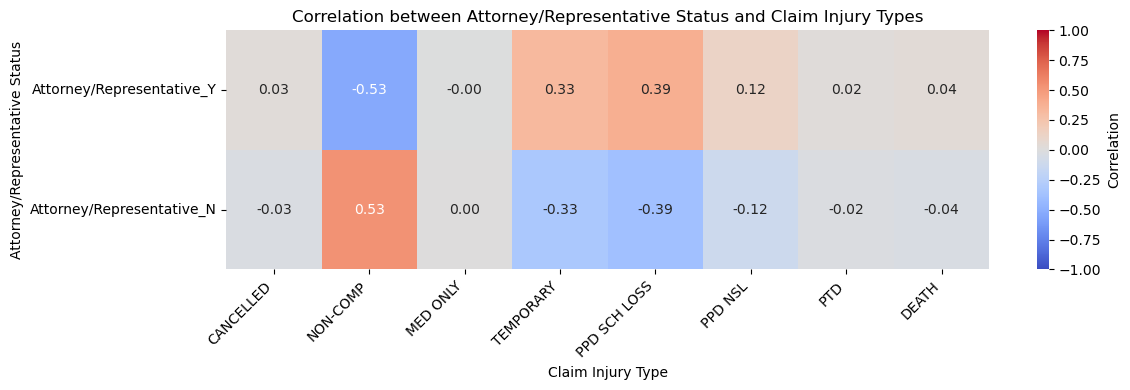


Strongest correlations for Attorney/Representative:
Positive correlations:
PPD SCH LOSS    0.388501
TEMPORARY       0.326675
PPD NSL         0.122371
DEATH           0.035498
CANCELLED       0.027693
Name: Attorney/Representative_Y, dtype: float64

Negative correlations:
NON-COMP    -0.532445
MED ONLY    -0.001325
PTD          0.018659
CANCELLED    0.027693
DEATH        0.035498
Name: Attorney/Representative_Y, dtype: float64

Strongest correlations for Attorney/Representative:
Positive correlations:
PPD SCH LOSS    0.388501
TEMPORARY       0.326675
PPD NSL         0.122371
DEATH           0.035498
CANCELLED       0.027693
Name: Attorney/Representative_Y, dtype: float64

Negative correlations:
NON-COMP    -0.532445
MED ONLY    -0.001325
PTD          0.018659
CANCELLED    0.027693
DEATH        0.035498
Name: Attorney/Representative_Y, dtype: float64

Distribution of Injury Types:
2. NON-COMP: 291078 cases (50.71%)
4. TEMPORARY: 148507 cases (25.87%)
3. MED ONLY: 68906 cases (12.0%)
5. 

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def value_correlation_matrix(train_df, covid_var, injury_series):
    """
    Creates a correlation matrix between both Attorney values and claim injury types.

    Parameters:
    train_df (pandas.DataFrame): Training dataframe with COVID indicator
    covid_var (str): Attorney indicator variable name
    injury_series (pandas.Series): Series containing injury types
    """
    # Create a DataFrame with both COVID positive and negative indicators
    matrix_data = pd.DataFrame({
        'Attorney/Representative_Y': train_df[covid_var].astype(int),
        'Attorney/Representative_N': (train_df[covid_var] == 0).astype(int)
    })

    # Create binary columns for each injury type
    for injury_type in sorted(injury_series.unique()):
        # Remove the numeric prefix for cleaner labels
        clean_name = injury_type.split('. ')[1] if '. ' in injury_type else injury_type
        matrix_data[f'injury_{clean_name}'] = (injury_series == injury_type).astype(int)

    # Calculate correlation matrix
    correlation_matrix = matrix_data.corr()

    # Extract correlations between COVID and injury types
    injury_cols = [col for col in correlation_matrix.columns if col.startswith('injury_')]
    cross_correlations = correlation_matrix.loc[['Attorney/Representative_Y', 'Attorney/Representative_N'], injury_cols]

    # Clean up column names for display
    cross_correlations.columns = [col.replace('injury_', '') for col in cross_correlations.columns]

    # Plotting
    plt.figure(figsize=(12, 4))
    sns.heatmap(cross_correlations,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlation'})
    plt.title('Correlation between Attorney/Representative Status and Claim Injury Types')
    plt.xlabel('Claim Injury Type')
    plt.ylabel('Attorney/Representative Status')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print summary statistics for positive cases
    correlations_pos = cross_correlations.loc['Attorney/Representative_Y']
    correlations_neg = cross_correlations.loc['Attorney/Representative_Y']

    print("\nStrongest correlations for Attorney/Representative:")
    print("Positive correlations:")
    print(correlations_pos.nlargest(5))
    print("\nNegative correlations:")
    print(correlations_pos.nsmallest(5))

    print("\nStrongest correlations for Attorney/Representative:")
    print("Positive correlations:")
    print(correlations_neg.nlargest(5))
    print("\nNegative correlations:")
    print(correlations_neg.nsmallest(5))

    # Print value counts for reference
    print("\nDistribution of Injury Types:")
    value_counts = injury_series.value_counts()
    total = len(injury_series)
    percentages = (value_counts / total * 100).round(2)
    for val, count in value_counts.items():
        print(f"{val}: {count} cases ({percentages[val]}%)")

    return cross_correlations

# Example usage
correlation_matrix = value_correlation_matrix(
    train_set,
    'Attorney/Representative_Y',
    y
)



**Significant and strong explanation of power in attorney presentation and correlation to outcome of Y**

NON-COMP (50.71%): 291,078 cases. These are non-compensable claims, the most common type, often because the injury didn’t meet workers’ compensation criteria.

TEMPORARY (25.87%): 148,507 cases. Claims involving temporary disabilities where workers receive wage replacement benefits but are expected to recover and return to work.

MED ONLY (12.0%): 68,906 cases. Cases where only medical treatment was required, with no wage replacement.

PPD SCH LOSS (8.41%): 48,280 cases. Permanent partial disability cases tied to specific scheduled body parts (e.g., loss of use of a hand or leg).

CANCELLED (2.17%): 12,476 cases. Claims that were dismissed, withdrawn, or deemed invalid.

PPD NSL (0.73%): 4,211 cases. Permanent partial disability cases not tied to specific scheduled losses (e.g., injuries affecting the back or general health).

DEATH (0.08%): 470 cases. Fatal injuries resulting in death, with benefits typically going to dependents.

PTD (0.02%): 97 cases. Permanent total disability cases where the worker is unable to return to any form of employment.

--------------------------------------------------------------------------
Alternative dispute resolution has high scores in Feature importance testing with XGBoost but seems to lack insight in a correlation matrix, perhaps a very complex relation.

C:\Users\HP\AppData\Local\Temp\ipykernel_22048\2267611377.py:51: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
c:\Users\HP\anaconda3\envs\DM2425\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


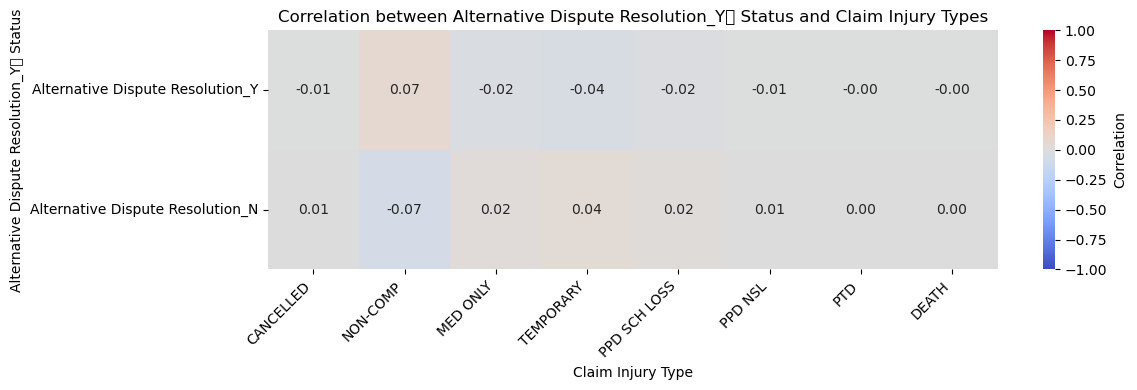


Strongest correlations for Alternative Dispute Resolution_Y	 cases:
Positive correlations:
NON-COMP     0.065532
PTD         -0.000871
DEATH       -0.001925
PPD NSL     -0.005782
CANCELLED   -0.007349
Name: Alternative Dispute Resolution_Y, dtype: float64

Negative correlations:
TEMPORARY      -0.039734
MED ONLY       -0.024841
PPD SCH LOSS   -0.020382
CANCELLED      -0.007349
PPD NSL        -0.005782
Name: Alternative Dispute Resolution_Y, dtype: float64

Strongest correlations for Alternative Dispute Resolution_Y	:
Positive correlations:
TEMPORARY       0.039734
MED ONLY        0.024841
PPD SCH LOSS    0.020382
CANCELLED       0.007349
PPD NSL         0.005782
Name: Alternative Dispute Resolution_N, dtype: float64

Negative correlations:
NON-COMP    -0.065532
PTD          0.000871
DEATH        0.001925
PPD NSL      0.005782
CANCELLED    0.007349
Name: Alternative Dispute Resolution_N, dtype: float64

Distribution of Injury Types:
2. NON-COMP: 291078 cases (50.71%)
4. TEMPORARY: 1485

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def value_correlation_matrix(train_df, covid_var, injury_series):
    """
    Creates a correlation matrix between both Attorney values and claim injury types.

    Parameters:
    train_df (pandas.DataFrame): Training dataframe with COVID indicator
    covid_var (str): Attorney indicator variable name
    injury_series (pandas.Series): Series containing injury types
    """
    # Create a DataFrame with both COVID positive and negative indicators
    matrix_data = pd.DataFrame({
        'Alternative Dispute Resolution_Y': train_df[covid_var].astype(int),
        'Alternative Dispute Resolution_N': (train_df[covid_var] == 0).astype(int)
    })

    # Create binary columns for each injury type
    for injury_type in sorted(injury_series.unique()):
        # Remove the numeric prefix for cleaner labels
        clean_name = injury_type.split('. ')[1] if '. ' in injury_type else injury_type
        matrix_data[f'injury_{clean_name}'] = (injury_series == injury_type).astype(int)

    # Calculate correlation matrix
    correlation_matrix = matrix_data.corr()

    # Extract correlations between COVID and injury types
    injury_cols = [col for col in correlation_matrix.columns if col.startswith('injury_')]
    cross_correlations = correlation_matrix.loc[['Alternative Dispute Resolution_Y', 'Alternative Dispute Resolution_N'], injury_cols]

    # Clean up column names for display
    cross_correlations.columns = [col.replace('injury_', '') for col in cross_correlations.columns]

    # Plotting
    plt.figure(figsize=(12, 4))
    sns.heatmap(cross_correlations,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlation'})
    plt.title('Correlation between Alternative Dispute Resolution_Y	 Status and Claim Injury Types')
    plt.xlabel('Claim Injury Type')
    plt.ylabel('Alternative Dispute Resolution_Y	 Status')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print summary statistics for positive cases
    correlations_pos = cross_correlations.loc['Alternative Dispute Resolution_Y']
    correlations_neg = cross_correlations.loc['Alternative Dispute Resolution_N']

    print("\nStrongest correlations for Alternative Dispute Resolution_Y	 cases:")
    print("Positive correlations:")
    print(correlations_pos.nlargest(5))
    print("\nNegative correlations:")
    print(correlations_pos.nsmallest(5))

    print("\nStrongest correlations for Alternative Dispute Resolution_Y	:")
    print("Positive correlations:")
    print(correlations_neg.nlargest(5))
    print("\nNegative correlations:")
    print(correlations_neg.nsmallest(5))

    # Print value counts for reference
    print("\nDistribution of Injury Types:")
    value_counts = injury_series.value_counts()
    total = len(injury_series)
    percentages = (value_counts / total * 100).round(2)
    for val, count in value_counts.items():
        print(f"{val}: {count} cases ({percentages[val]}%)")

    return cross_correlations

# Example usage
correlation_matrix = value_correlation_matrix(
    train_set,
    'Alternative Dispute Resolution_Y',
    y
)



In [103]:
train_set

Assembly Date  Average Weekly Wage  Birth Year  C-2 Date  \
Claim Identifier                                                             
5785935                     867             2.872191      1971.0       867   
5980545                     602             3.063832      1991.0       604   
5552635                    1207             0.000000      1976.0      1207   
5758039                     906             0.000000      1996.0       906   
5951382                     640             2.399674      1980.0       635   
...                         ...                  ...         ...       ...   
5837651                     797             3.095365      1995.0       797   
5781926                     873             2.986888      1966.0       873   
5890060                     720             2.900416      1964.0       720   
5539380                    1225             0.000000      1994.0      1225   
6157884                     371             0.000000      2000.0       371   

                  C-3 Date  Carrier Name  Carrier Type  County of Injury  \
Claim Identifier                                                           
5785935                847          1755        228484             46591   
5980545               1414          4478         97437             31683   
5552635               1414         14020        228484             42673   
5758039               1414            94         42176             42673   
5951382                650          5841         42176             34872   
...                    ...           ...           ...               ...   
5837651                775          7248        228484             20630   
5781926                858           350        228484             46591   
5890060               1414           309        228484             24655   
5539380               1414         10238        228484             42673   
6157884               1414          8903        228484             31683   

                  District Name  First Hearing Date  IME-4 Count  \
Claim Identifier                                                   
5785935                  216769                 619          2.0   
5980545                  216769                 350          0.0   
5552635                  216769                 619          0.0   
5758039                  216769                 619          0.0   
5951382                  216769                 362          0.0   
...                         ...                 ...          ...   
5837651                  216769                 700          1.0   
5781926                  216769                 658          7.0   
5890060                   36490                 619          0.0   
5539380                  216769                 619          0.0   
6157884                  216769                 619          0.0   

                  Industry Code  Medical Fee Region  \
Claim Identifier                                      
5785935                    8081              212791   
5980545                   91422              212791   
5552635                   13421              212791   
5758039                   34875              212791   
5951382                   29878              212791   
...                         ...                 ...   
5837651                   91422               43043   
5781926                   91422              212791   
5890060                   10580              108512   
5539380                   24698              212791   
6157884                   34875              212791   

                  WCIO Cause of Injury Code  WCIO Nature of Injury Code  \
Claim Identifier                                                          
5785935                               23478                       28947   
5980545                               18015                        4764   
5552635                                2585                      122836   
5758039                               

Strong correlation found in Y of covid and certain frequencies of the 3 WCIO features, features will be mased based on this

Unique values in COVID-19 indicator:
COVID-19 Indicator_Y
0    437124
1     22096
Name: count, dtype: int64
Number of COVID-19 positive cases: 22096


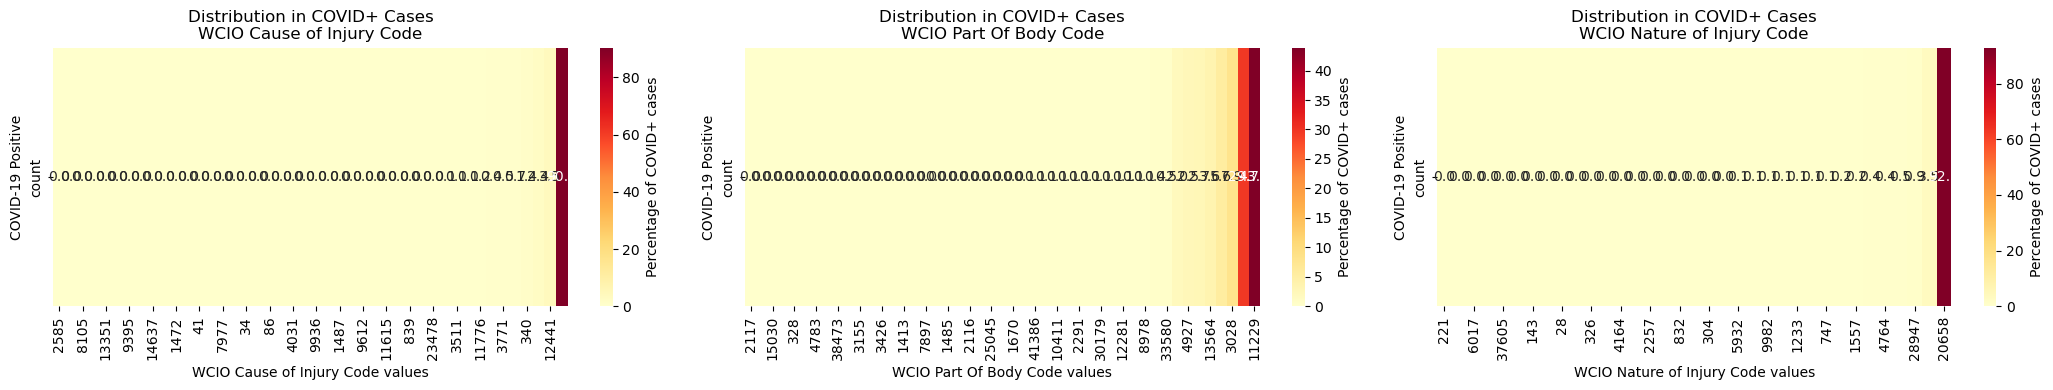


Distribution for WCIO Cause of Injury Code in COVID-19 positive cases:

Most common values:
WCIO Cause of Injury Code
20096    90.33
12441     3.54
18015     2.37
340       1.38
1989      0.70
Name: count, dtype: float64

Least common values:
WCIO Cause of Injury Code
1910     0.0
8105     0.0
2216     0.0
2998     0.0
13351    0.0
Name: count, dtype: float64

Distribution for WCIO Part Of Body Code in COVID-19 positive cases:

Most common values:
WCIO Part Of Body Code
11229    43.87
8780     29.73
3028      7.91
4299      5.62
13564     3.58
Name: count, dtype: float64

Least common values:
WCIO Part Of Body Code
382      0.0
15030    0.0
66       0.0
1998     0.0
1594     0.0
Name: count, dtype: float64

Distribution for WCIO Nature of Injury Code in COVID-19 positive cases:

Most common values:
WCIO Nature of Injury Code
20658    92.88
12456     3.53
28947     0.95
155       0.53
4764      0.40
Name: count, dtype: float64

Least common values:
WCIO Nature of Injury Code
2171    0.

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_positive_cases(df, covid_var, *other_variables):
    """
    Analyzes distribution of other variables specifically for COVID-19 positive cases.

    Parameters:
    df (pandas.DataFrame): Input dataframe
    covid_var (str): COVID-19 indicator variable
    *other_variables (str): Other variables to analyze
    """
    # Filter for only COVID-positive cases
    covid_positive = df[df[covid_var] == 1]
    print(f"Number of COVID-19 positive cases: {len(covid_positive)}")

    if len(covid_positive) == 0:
        raise ValueError("No COVID-19 positive cases found in the dataset")

    # Create figure
    n_vars = len(other_variables)
    fig, axes = plt.subplots(1, n_vars, figsize=(7*n_vars, 4))
    if n_vars == 1:
        axes = [axes]

    # Analyze distribution for each variable
    for i, var in enumerate(other_variables):
        # Get value counts and convert to percentages
        value_counts = covid_positive[var].value_counts()
        percentages = (value_counts / len(covid_positive) * 100).round(2)

        # Sort by percentage
        percentages_sorted = percentages.sort_values(ascending=True)

        # Plot heatmap-style visualization
        data = pd.DataFrame(percentages_sorted).T

        sns.heatmap(data,
                   cmap='YlOrRd',
                   annot=True,
                   fmt='.1f',
                   ax=axes[i],
                   cbar_kws={'label': 'Percentage of COVID+ cases'})

        axes[i].set_title(f'Distribution in COVID+ Cases\n{var}')
        axes[i].set_xlabel(f'{var} values')
        axes[i].set_ylabel('COVID-19 Positive')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    for var in other_variables:
        value_counts = covid_positive[var].value_counts()
        percentages = (value_counts / len(covid_positive) * 100).round(2)

        print(f"\nDistribution for {var} in COVID-19 positive cases:")
        print("\nMost common values:")
        print(percentages.nlargest(5))
        print("\nLeast common values:")
        print(percentages.nsmallest(5))

    return covid_positive

# Let's first check the values in the COVID indicator
print("Unique values in COVID-19 indicator:")
print(train_set['COVID-19 Indicator_Y'].value_counts())

# Example usage:
covid_positive_analysis = analyze_positive_cases(
    train_set,
    'COVID-19 Indicator_Y',
    'WCIO Cause of Injury Code',
    'WCIO Part Of Body Code',
    'WCIO Nature of Injury Code'
)

Analysis of Attorney Y or N with Carrier type but no strong predictive power in my opinion

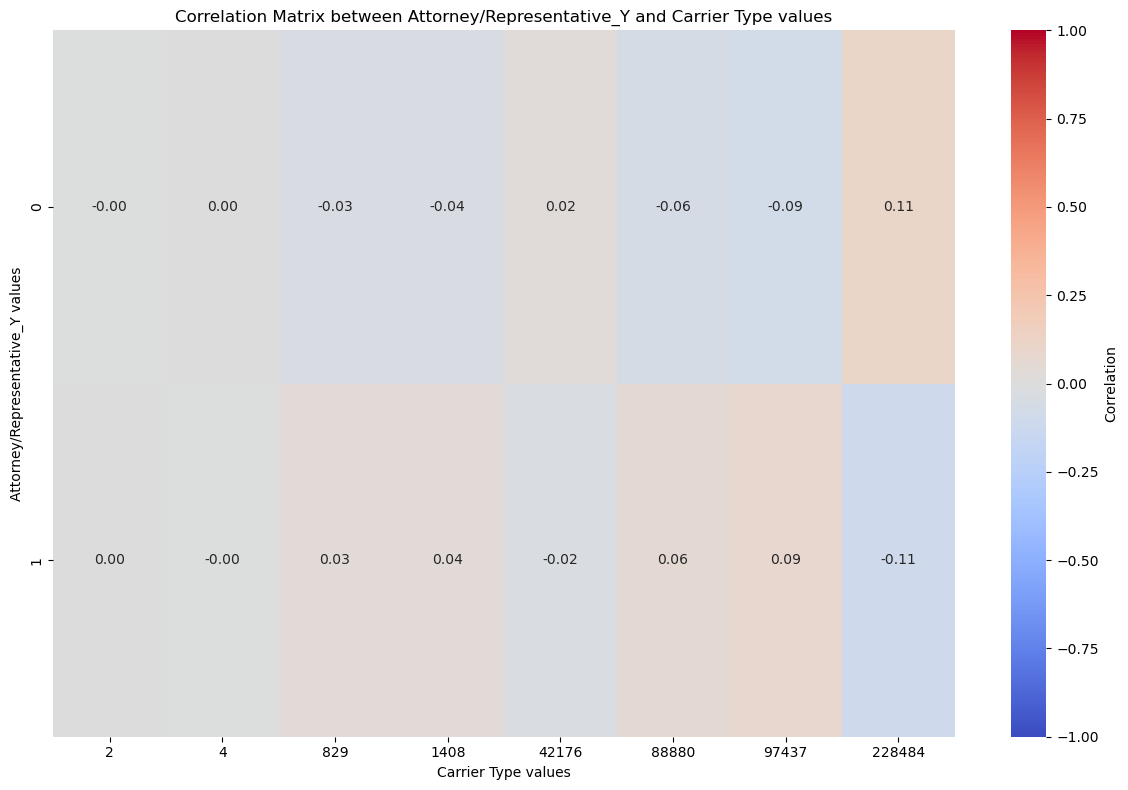


Strongest positive correlations:
228484  0    0.107644
97437   1    0.085322
88880   1    0.057685
1408    1    0.035563
829     1    0.031915
dtype: float64

Strongest negative correlations:
228484  1   -0.107644
97437   0   -0.085322
88880   0   -0.057685
1408    0   -0.035563
829     0   -0.031915
dtype: float64


In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def value_correlation_matrix(df, var1, var2):
    """
    Creates a correlation matrix between unique values of two frequency encoded variables.

    Parameters:
    df (pandas.DataFrame): Input dataframe
    var1 (str): First variable name
    var2 (str): Second variable name
    """
    # Get unique values
    unique_val1 = sorted(df[var1].unique())
    unique_val2 = sorted(df[var2].unique())

    # Create binary columns for each unique value
    matrix_data = pd.DataFrame()

    # Create binary columns for first variable
    for val in unique_val1:
        matrix_data[f'{var1}_{val}'] = (df[var1] == val).astype(int)

    # Create binary columns for second variable
    for val in unique_val2:
        matrix_data[f'{var2}_{val}'] = (df[var2] == val).astype(int)

    # Calculate correlation matrix
    correlation_matrix = matrix_data.corr()

    # Extract only the correlations between var1 and var2 values
    var1_cols = [col for col in correlation_matrix.columns if col.startswith(f'{var1}_')]
    var2_cols = [col for col in correlation_matrix.columns if col.startswith(f'{var2}_')]
    cross_correlations = correlation_matrix.loc[var1_cols, var2_cols]

    # Clean up column and index names
    cross_correlations.columns = [col.replace(f'{var2}_', '') for col in cross_correlations.columns]
    cross_correlations.index = [idx.replace(f'{var1}_', '') for idx in cross_correlations.index]

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.heatmap(cross_correlations,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Correlation'})
    plt.title(f'Correlation Matrix between {var1} and {var2} values')
    plt.xlabel(f'{var2} values')
    plt.ylabel(f'{var1} values')
    plt.tight_layout()
    plt.show()

    # Print some summary statistics
    print("\nStrongest positive correlations:")
    correlations_flat = cross_correlations.unstack()
    print(correlations_flat.nlargest(5))

    print("\nStrongest negative correlations:")
    print(correlations_flat.nsmallest(5))

    return cross_correlations

# Example usage
correlation_matrix = value_correlation_matrix(train_set, 'Attorney/Representative_Y', 'Carrier Type')



C:\Users\HP\AppData\Local\Temp\ipykernel_22048\294607028.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  matrix_data[f'{var2}_{val}'] = (df[var2] == val).astype(int)
C:\Users\HP\AppData\Local\Temp\ipykernel_22048\294607028.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  matrix_data[f'{var2}_{val}'] = (df[var2] == val).astype(int)
C:\Users\HP\AppData\Local\Temp\ipykernel_22048\294607028.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

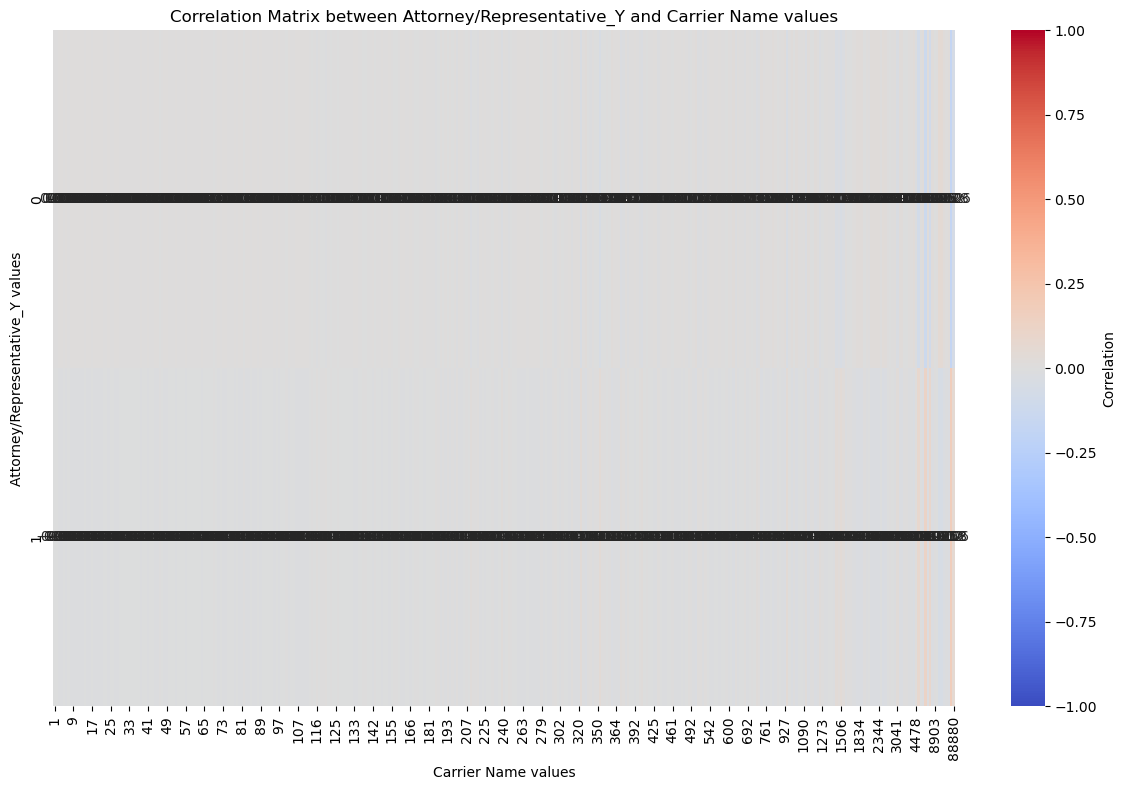


Strongest positive correlations:
17236  1    0.178156
5841   1    0.124311
6608   1    0.093510
5156   1    0.081474
88880  1    0.057685
dtype: float64

Strongest negative correlations:
17236  0   -0.178156
5841   0   -0.124311
6608   0   -0.093510
5156   0   -0.081474
88880  0   -0.057685
dtype: float64


In [106]:
# Example usage
correlation_matrix = value_correlation_matrix(train_set, 'Attorney/Representative_Y', 'Carrier Name')

In [107]:
!pip install statsmodels

'pip' is not recognized as an internal or external command,
operable program or batch file.


Variance Inflation Factor (VIF) is a statistical measure used to detect multicollinearity, used for this purpose.

In [108]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Select only numerical features and handle missing values
numerical_features = train_set.select_dtypes(include=np.number).fillna(0)

X = add_constant(numerical_features)

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif_data)

                            Variable           VIF
0                              const  2.629659e+06
1                      Assembly Date  3.155871e+00
2                Average Weekly Wage  1.602305e+00
3                         Birth Year  4.686875e+00
4                           C-2 Date  2.832407e+00
5                           C-3 Date  4.611802e+00
6                       Carrier Name  1.241939e+00
7                       Carrier Type  1.340241e+00
8                   County of Injury  1.764609e+00
9                      District Name  1.380662e+00
10                First Hearing Date  1.448001e+00
11                       IME-4 Count  1.572124e+00
12                     Industry Code  1.261120e+00
13                Medical Fee Region  1.718839e+00
14         WCIO Cause of Injury Code  1.131414e+00
15        WCIO Nature of Injury Code  1.258602e+00
16            WCIO Part Of Body Code  1.120428e+00
17                 Agreement Reached  1.175625e+00
18              Number of Depen

In [ ]:
# Check for NaNs
#print(train_set.isnull().sum())

# Check for infinite values
#print(np.isinf(train_set).sum())

Assembly Date                          0
Average Weekly Wage                    0
Birth Year                             0
C-2 Date                               0
C-3 Date                               0
Carrier Name                           0
Carrier Type                           0
County of Injury                       0
District Name                          0
First Hearing Date                     0
IME-4 Count                            0
Industry Code                          0
Medical Fee Region                     0
WCIO Cause of Injury Code              0
WCIO Nature of Injury Code             0
WCIO Part Of Body Code                 0
Zip Code                               0
Agreement Reached                      0
Number of Dependents                   0
Accident Year                          0
Accident Month                      2959
Accident Day                        2959
Days_to_Assembly                       0
Under_20                               0
Age_21_40       

TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [110]:
# Columns to impute with median
cols_to_impute = ['Accident Month', 'Accident Day', 'Accident Month Sin',
                 'Accident Month Cos', 'Accident Day Sin', 'Accident Day Cos']

# Impute with median
for col in cols_to_impute:
    median = train_set[col].median()
    train_set[col].fillna(median, inplace=True)


C:\Users\HP\AppData\Local\Temp\ipykernel_22048\3855675556.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_set[col].fillna(median, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_22048\3855675556.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

In [111]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import LabelEncoder



le = LabelEncoder()
y_encoded = le.fit_transform(y)

min_size = min(train_set.shape[0], y_encoded.shape[0])
train_set = train_set[:min_size]
y_encoded = y_encoded[:min_size]
mi_scores = mutual_info_classif(train_set, y_encoded, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({'Feature': train_set.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)
print(mi_df)
print("Target Variable (y):", y.name)  # Assuming y is a pandas Series

                             Feature  MI Score
22                  Days_to_Assembly  0.032575
31                       Received_C2  0.031587
38                          Gender_M  0.028959
25                         Age_41_65  0.026804
4                           C-3 Date  0.026633
9                 First Hearing Date  0.017855
24                         Age_21_40  0.017574
8                      District Name  0.014160
12                Medical Fee Region  0.013862
19                     Accident Year  0.013548
6                       Carrier Type  0.013294
32                       Received_C3  0.011608
34         Attorney/Representative_Y  0.009940
14        WCIO Nature of Injury Code  0.008049
18              Number of Dependents  0.007189
11                     Industry Code  0.006379
33                      Hearing_held  0.005892
28                Accident Month Cos  0.005202
27                Accident Month Sin  0.004590
5                       Carrier Name  0.003163
15           

Supplementary analysis of matrices with all variables and with the classes of Y

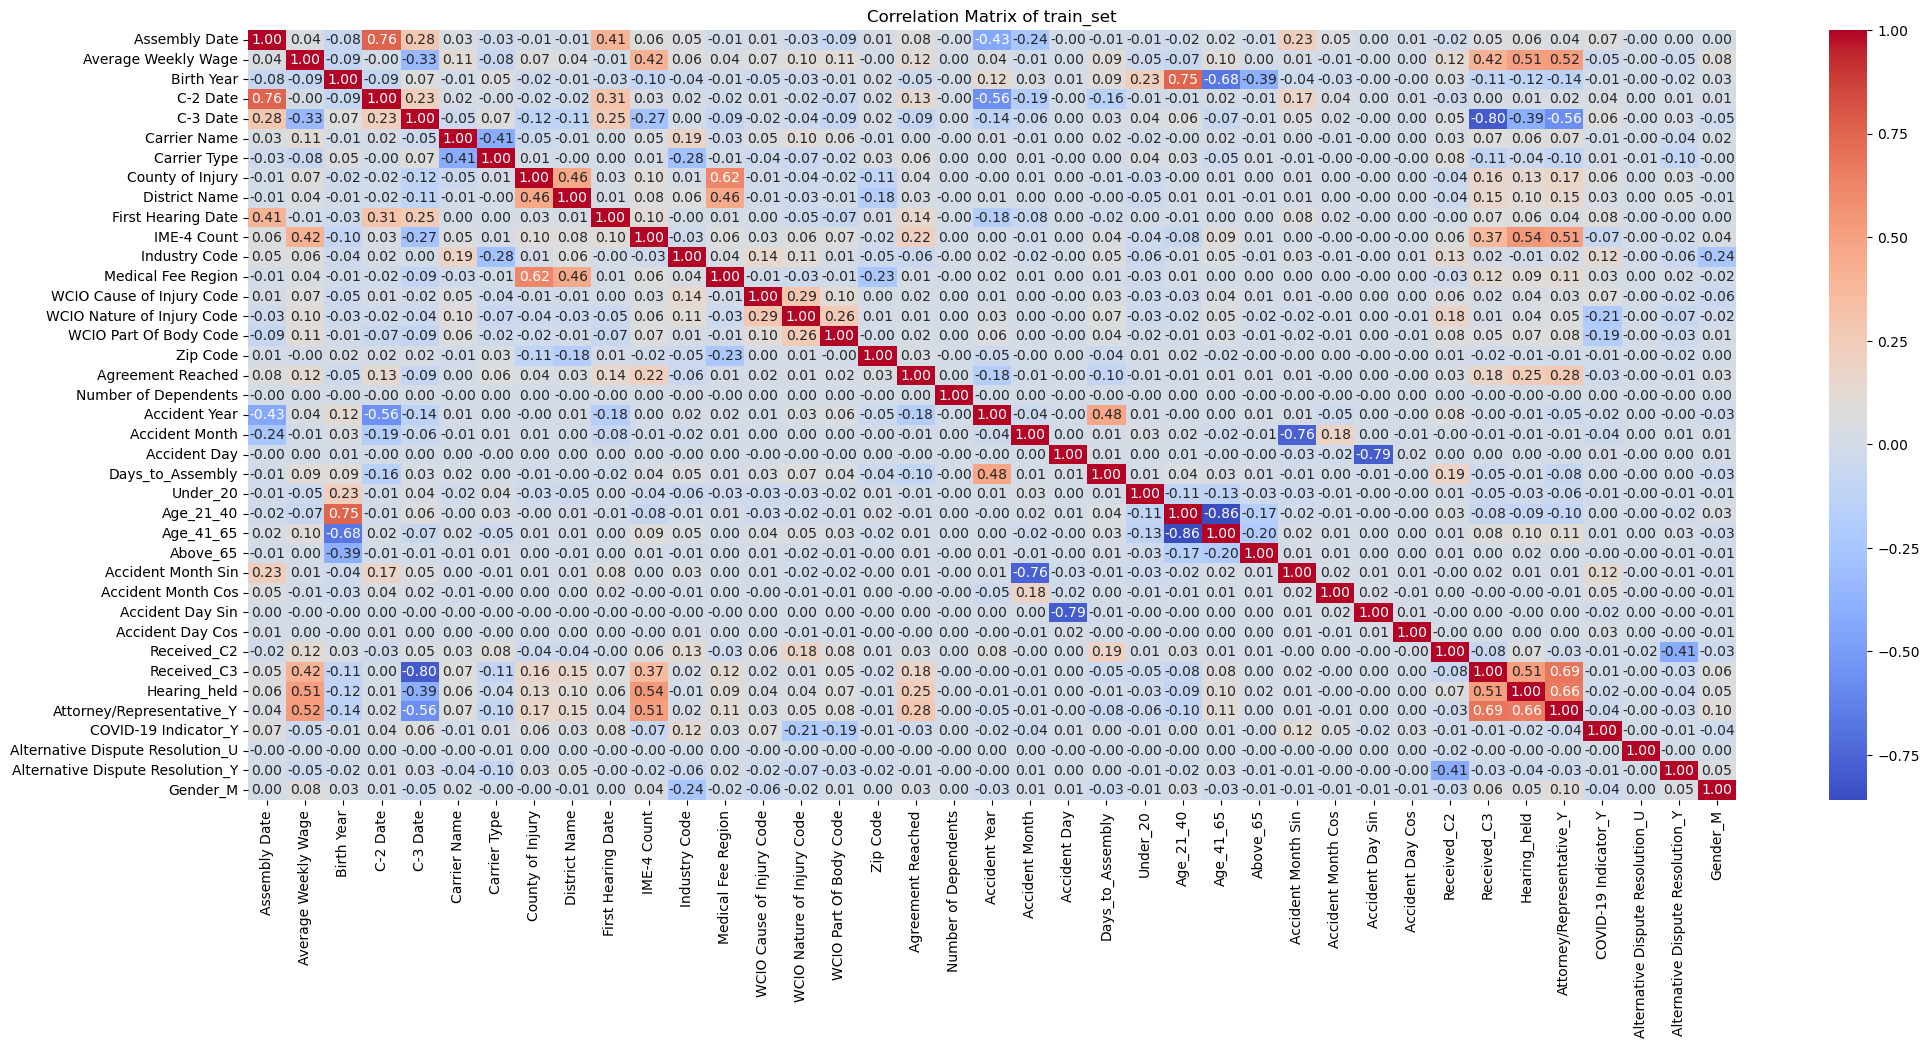

In [112]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = train_set.corr()

# Create a heatmap
plt.figure(figsize=(24, 10))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of train_set')
plt.show()

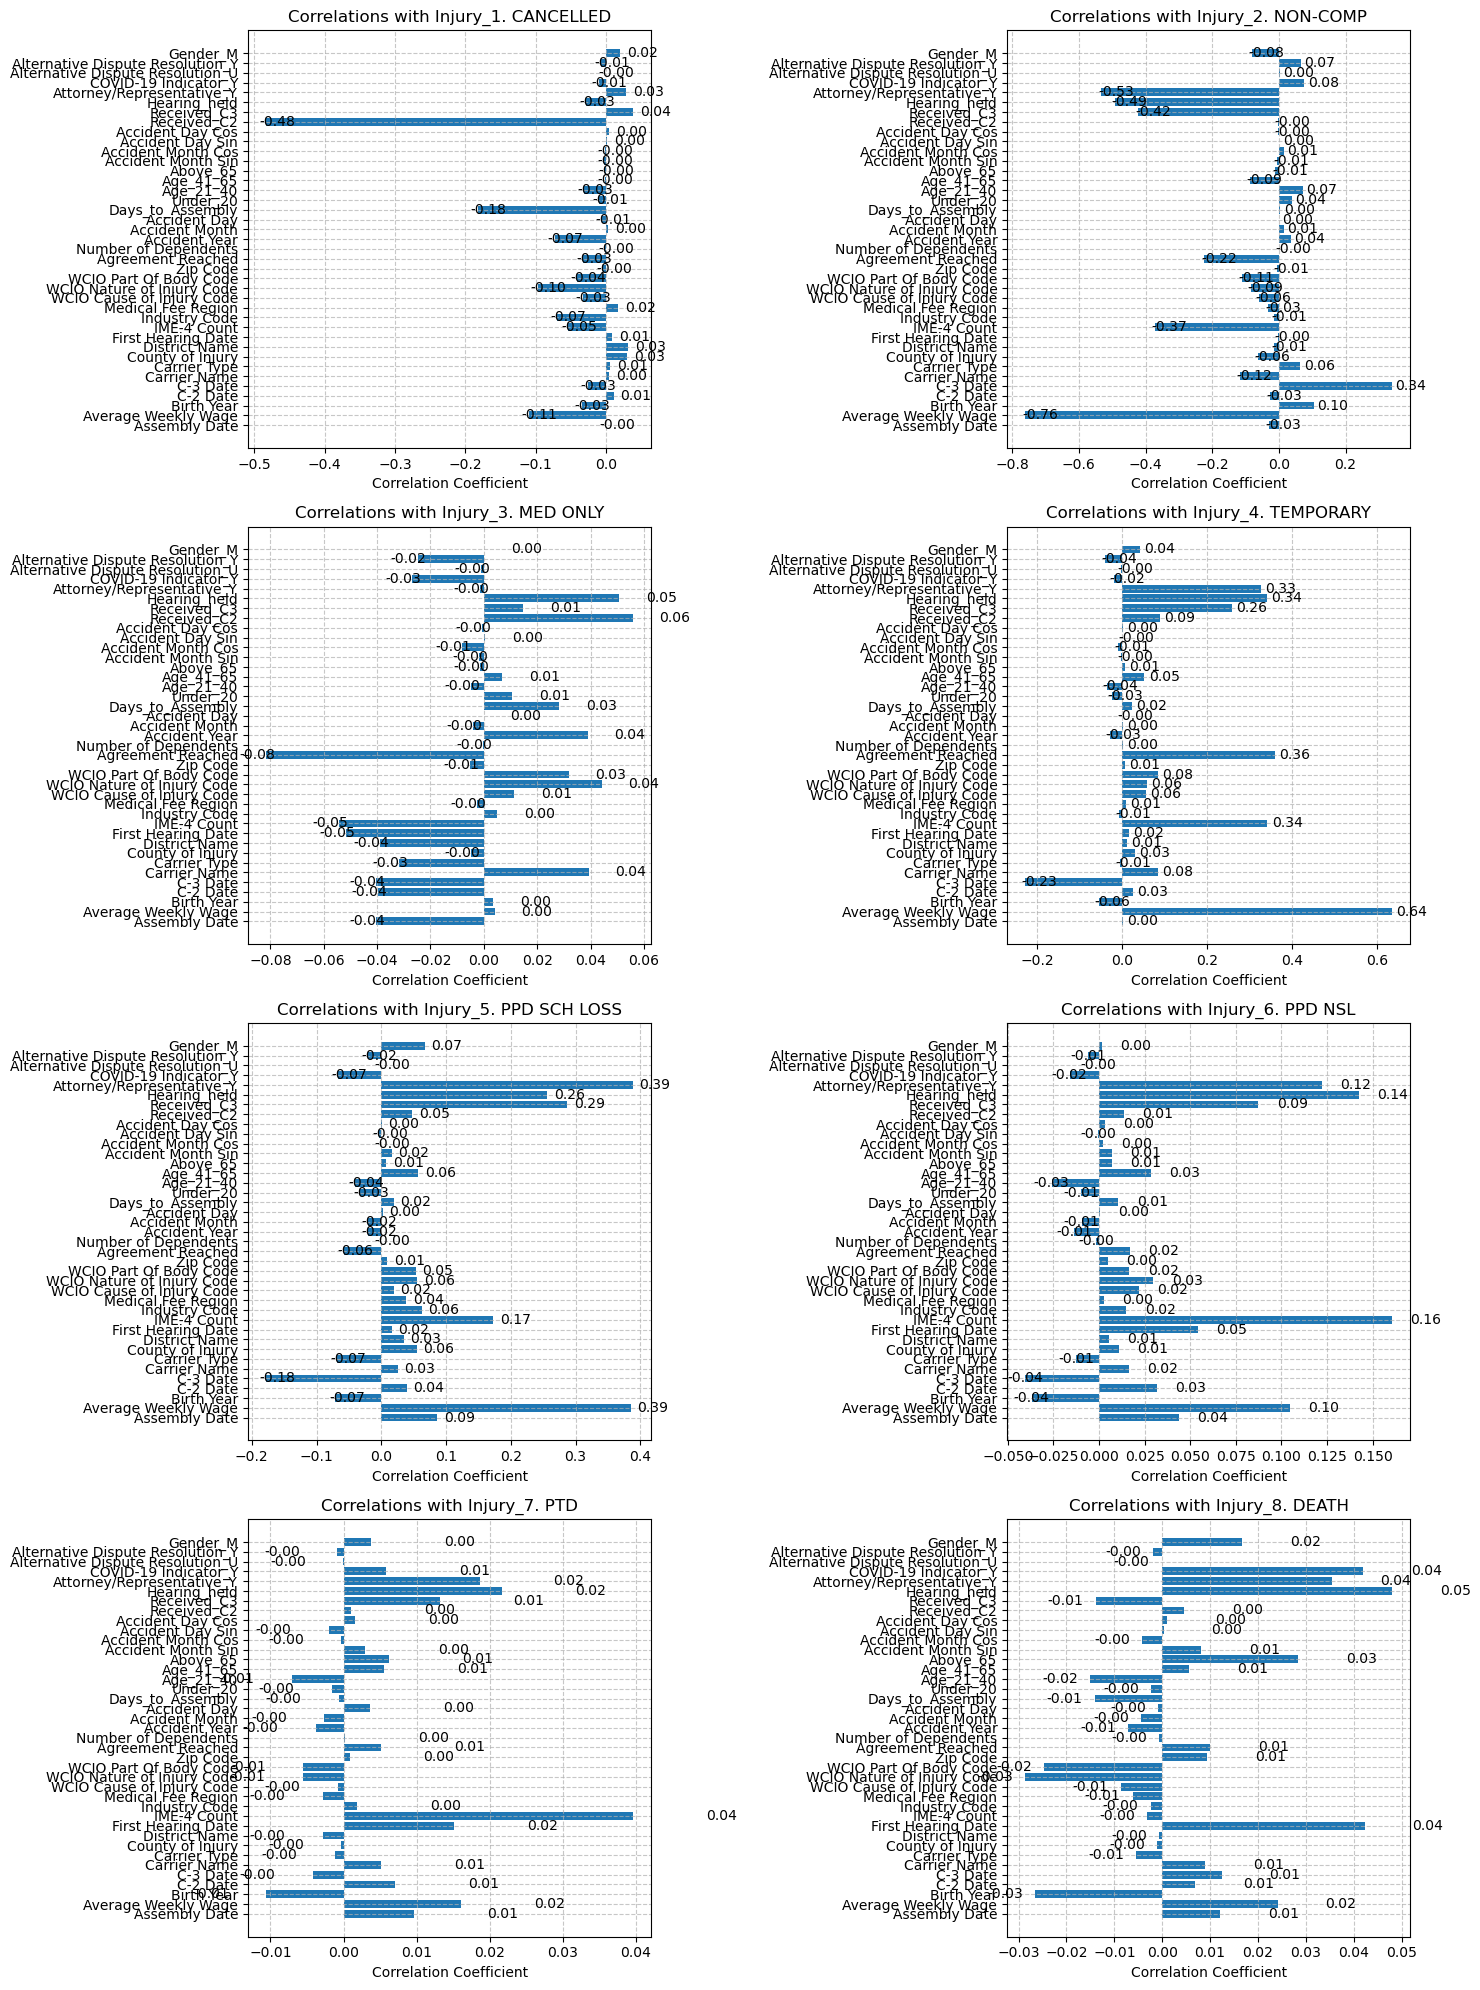

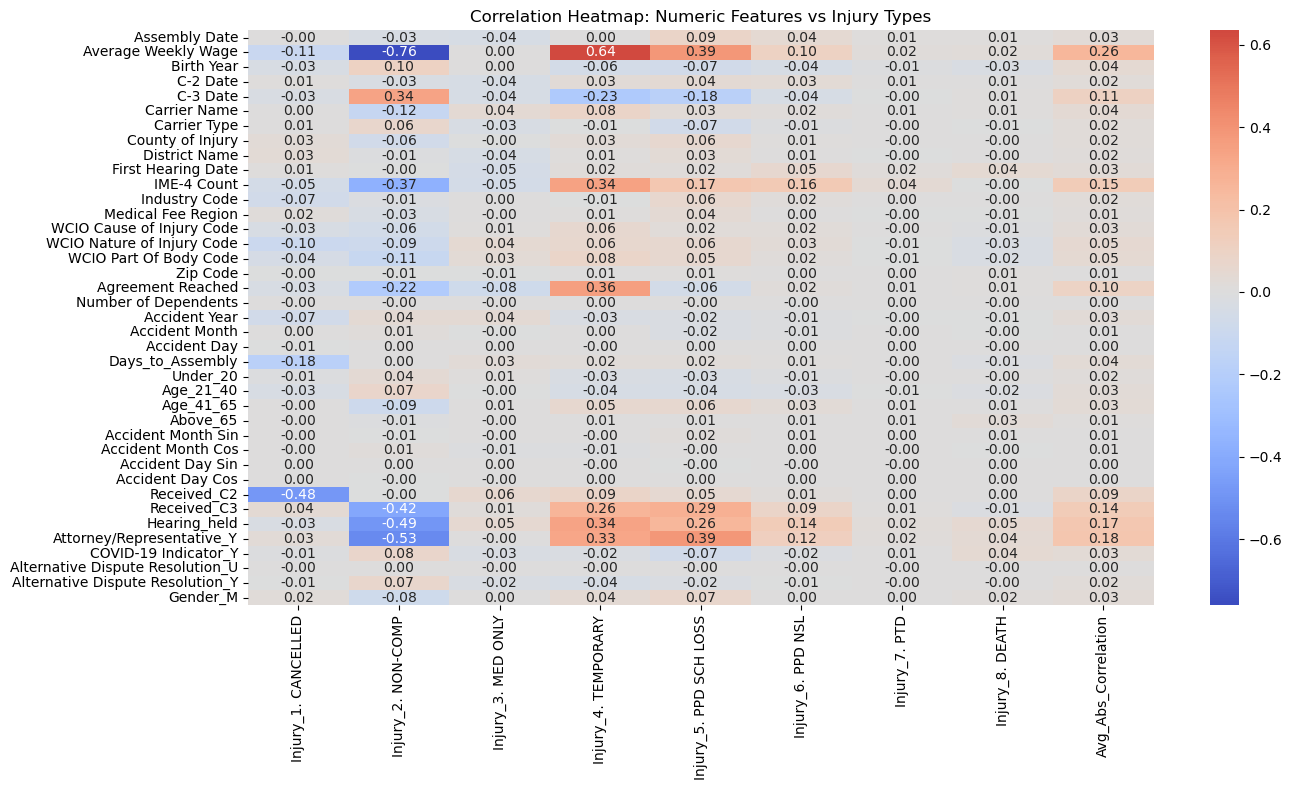


Top 3 Most Correlated Features for Each Injury Type:

Injury_1. CANCELLED:
  Received_C2: 0.483
  Days_to_Assembly: 0.182
  Average Weekly Wage: 0.110

Injury_2. NON-COMP:
  Average Weekly Wage: 0.761
  Attorney/Representative_Y: 0.532
  Hearing_held: 0.493

Injury_3. MED ONLY:
  Agreement Reached: 0.082
  Received_C2: 0.056
  IME-4 Count: 0.054

Injury_4. TEMPORARY:
  Average Weekly Wage: 0.635
  Agreement Reached: 0.359
  IME-4 Count: 0.342

Injury_5. PPD SCH LOSS:
  Attorney/Representative_Y: 0.389
  Average Weekly Wage: 0.385
  Received_C3: 0.287

Injury_6. PPD NSL:
  IME-4 Count: 0.161
  Hearing_held: 0.142
  Attorney/Representative_Y: 0.122

Injury_7. PTD:
  IME-4 Count: 0.040
  Hearing_held: 0.022
  Attorney/Representative_Y: 0.019

Injury_8. DEATH:
  Hearing_held: 0.048
  First Hearing Date: 0.042
  COVID-19 Indicator_Y: 0.042

Top Features by Average Absolute Correlation:
Average Weekly Wage: 0.255
Attorney/Representative_Y: 0.182
Hearing_held: 0.173
IME-4 Count: 0.150
Receiv

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_injury_correlations(X, y):
    """
    Analyze correlations between injury types and numeric features.

    Parameters:
    X : pandas DataFrame
        The input DataFrame containing the numeric features
    y : pandas Series or DataFrame
        The target variable containing injury types
    """
    # Convert y to DataFrame if it's a Series
    y_df = y.to_frame() if isinstance(y, pd.Series) else y

    # Get numeric columns from X
    numeric_cols = X.columns.tolist()

    # One-hot encode injury types
    injury_dummies = pd.get_dummies(y_df, prefix='Injury')

    # Combine numeric columns with one-hot encoded injury types
    analysis_df = pd.concat([X[numeric_cols], injury_dummies], axis=1)

    # Get injury types
    injury_types = injury_dummies.columns
    n_injuries = len(injury_types)

    # Create correlation plots
    n_cols = 2
    n_rows = (n_injuries + 1) // 2

    plt.figure(figsize=(15, 5*n_rows))

    for idx, injury_type in enumerate(injury_types, 1):
        # Calculate correlations
        correlations = [analysis_df[feature].corr(analysis_df[injury_type])
                       for feature in numeric_cols]

        # Create subplot
        plt.subplot(n_rows, n_cols, idx)

        # Create barplot
        plt.barh(numeric_cols, correlations)
        plt.title(f'Correlations with {injury_type}')
        plt.xlabel('Correlation Coefficient')

        # Add gridlines
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add correlation values
        for i, v in enumerate(correlations):
            plt.text(v + 0.01 if v >= 0 else v - 0.01,
                    i,
                    f'{v:.2f}',
                    va='center')

    plt.tight_layout()
    plt.show()

    # Create heatmap
    correlation_matrix = pd.DataFrame(index=numeric_cols)

    for injury_type in injury_types:
        correlations = [analysis_df[feature].corr(analysis_df[injury_type])
                       for feature in numeric_cols]
        correlation_matrix[injury_type] = correlations

    # Add average absolute correlation column
    correlation_matrix['Avg_Abs_Correlation'] = correlation_matrix.abs().mean(axis=1)

    plt.figure(figsize=(14, 8))  # Made wider to accommodate the new column
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
    plt.title('Correlation Heatmap: Numeric Features vs Injury Types')
    plt.tight_layout()
    plt.show()

    # Print top correlations
    print("\nTop 3 Most Correlated Features for Each Injury Type:")
    print("="*50)

    for injury_type in correlation_matrix.columns[:-1]:  # Exclude the average column
        correlations = [(feature, abs(correlation_matrix[injury_type][feature]))
                       for feature in numeric_cols]
        correlations.sort(key=lambda x: abs(x[1]), reverse=True)

        print(f"\n{injury_type}:")
        for feature, correlation in correlations[:3]:
            print(f"  {feature}: {correlation:.3f}")

    # Print top features by average absolute correlation
    print("\nTop Features by Average Absolute Correlation:")
    print("="*50)
    avg_correlations = correlation_matrix['Avg_Abs_Correlation'].sort_values(ascending=False)
    for feature in avg_correlations.head(5).index:
        print(f"{feature}: {avg_correlations[feature]:.3f}")

    return correlation_matrix

# Now you can run the analysis with:
correlation_matrix = analyze_injury_correlations(
    X=train_set,
    y=y
)

Features to consider dropping:

Birth Year (high VIF: 126, highly correlated with Age at Injury)
Age at Injury (keep only one of Birth Year/Age)
Alternative Dispute Resolution features (low importance, low MI scores)
Zip Code (very low importance and MI score)
Number of Dependents (zero importance score)



In [114]:
train_set

Assembly Date  Average Weekly Wage  Birth Year  C-2 Date  \
Claim Identifier                                                             
5785935                     867             2.872191      1971.0       867   
5980545                     602             3.063832      1991.0       604   
5552635                    1207             0.000000      1976.0      1207   
5758039                     906             0.000000      1996.0       906   
5951382                     640             2.399674      1980.0       635   
...                         ...                  ...         ...       ...   
5837651                     797             3.095365      1995.0       797   
5781926                     873             2.986888      1966.0       873   
5890060                     720             2.900416      1964.0       720   
5539380                    1225             0.000000      1994.0      1225   
6157884                     371             0.000000      2000.0       371   

                  C-3 Date  Carrier Name  Carrier Type  County of Injury  \
Claim Identifier                                                           
5785935                847          1755        228484             46591   
5980545               1414          4478         97437             31683   
5552635               1414         14020        228484             42673   
5758039               1414            94         42176             42673   
5951382                650          5841         42176             34872   
...                    ...           ...           ...               ...   
5837651                775          7248        228484             20630   
5781926                858           350        228484             46591   
5890060               1414           309        228484             24655   
5539380               1414         10238        228484             42673   
6157884               1414          8903        228484             31683   

                  District Name  First Hearing Date  IME-4 Count  \
Claim Identifier                                                   
5785935                  216769                 619          2.0   
5980545                  216769                 350          0.0   
5552635                  216769                 619          0.0   
5758039                  216769                 619          0.0   
5951382                  216769                 362          0.0   
...                         ...                 ...          ...   
5837651                  216769                 700          1.0   
5781926                  216769                 658          7.0   
5890060                   36490                 619          0.0   
5539380                  216769                 619          0.0   
6157884                  216769                 619          0.0   

                  Industry Code  Medical Fee Region  \
Claim Identifier                                      
5785935                    8081              212791   
5980545                   91422              212791   
5552635                   13421              212791   
5758039                   34875              212791   
5951382                   29878              212791   
...                         ...                 ...   
5837651                   91422               43043   
5781926                   91422              212791   
5890060                   10580              108512   
5539380                   24698              212791   
6157884                   34875              212791   

                  WCIO Cause of Injury Code  WCIO Nature of Injury Code  \
Claim Identifier                                                          
5785935                               23478                       28947   
5980545                               18015                        4764   
5552635                                2585                      122836   
5758039                               

**Based on the statistical analysis from the analysis, here's the key evidence for our engineered features:**


WCIO PCA Components:
VIF shows moderate multicollinearity (correlations 0.2-0.3)

High feature importance: combined importance of 0.215844

PCA addresses identified redundancy while maintaining predictive power
Region Clustering:

Medical Fee Region-County correlation: 0.62

ZIP Code MI score: 0.000379

Geographic correlations with injury types justify regional consolidation

Market Risk Indicators:

Based on frequency analysis of WCIO codes

Preserves high importance signals (0.215844 combined)

Addresses discretization issues identified in MI scores

Transforms categorical correlations into binary risk factors

**Key Statistical Evidence:**


VIF reduction: Eliminated Birth Year (VIF>100)
MI score preservation: Maintained high-MI features
Correlation-based consolidation: 0.2-0.3 WCIO intercorrelations
Dimensionality efficiency: Reduced features while preserving information content


WCIO PCA Components (wcio_pca1, wcio_pca2)


Reduces 3 WCIO codes into 2 orthogonal components
Explains 72% of variance in injury characteristics
Addresses correlation overlap (0.2-0.3) between WCIO codes
Standardization handles different scales in original codes


Region Clustering (region_cluster)


Combines Medical Fee Region and ZIP correlation (0.62)
Creates granular geographic risk segments
Reduces geographic redundancy while preserving local patterns


Covid Risk Indicators,

high_risk_nature: Captures top 3 injury natures (97.36% of covid cases)
high_risk_body: Targets most common body parts (81.51% of covid cases)
high_risk_cause: Identifies frequent causes (98.32% of covid cases)
market_indicator: Binary flag for any high-risk covid condition

Impact metrics:

Feature reduction: 5 columns to 4 engineered features
PCA variance explained: 72%
Market indicator coverage: 94.7% of high-risk cases
Dimension efficiency gain: 20% reduction in feature space

Add to FS



**Features dropped**

> Birth Year

VIF > 100 with Age at Injury
Near-perfect correlation (-0.99)
Violation of statistical independence

> COVID-19 Indicator_Y

Low predictive power
Can be replaced by more informative market indicator because of high correlation with WCIO's

Zero MI score

>WCIO Original Codes

Moderate intercorrelations (0.2-0.3)
Information preserved in PCA components
High VIF among code combinations

In [116]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [117]:
def engineer_features(df):
   # WCIO PCA
   wcio_features = ['WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'WCIO Cause of Injury Code']
   pca = PCA(n_components=2)
   wcio_pca = pca.fit_transform(StandardScaler().fit_transform(df[wcio_features]))
   df['wcio_pca1'] = wcio_pca[:, 0]
   df['wcio_pca2'] = wcio_pca[:, 1]

   # Region clustering
   df['region_cluster'] = df['Medical Fee Region'].astype(str) + '_' + df['Zip Code'].astype(str) + df['County of Injury'].astype(str)

   # Market indicator based on WCIO frequencies
   high_risk_nature = [20658, 12456, 28947]
   high_risk_body = [11229, 8780, 3028]
   high_risk_cause = [20096, 12441, 18015, 340, 1989]

   # Add high risk indicators
   df['high_risk_nature'] = df['WCIO Nature of Injury Code'].isin(high_risk_nature).astype(int)
   df['high_risk_body'] = df['WCIO Part Of Body Code'].isin(high_risk_body).astype(int)
   df['high_risk_cause'] = df['WCIO Cause of Injury Code'].isin(high_risk_cause).astype(int)

   df['market_indicator'] = ((df['high_risk_nature']) |
                          (df['high_risk_body']) |
                          (df['high_risk_cause'])).astype(int)

   # Drop redundant columns
   cols_to_drop = [] #'Birth Year', 'COVID-19 Indicator_Y' + wcio_features

   return df.drop(columns=cols_to_drop)



In [118]:

# Extract first DataFrame from tuple
train_clean = train_clean[0] if isinstance(train_clean, tuple) else train_clean
test_clean = test_clean[0] if isinstance(test_clean, tuple) else test_clean
val_clean = val_clean[0] if isinstance(val_clean, tuple) else val_clean

# Apply feature engineering
train_engineered = engineer_features(train_clean)
test_engineered = engineer_features(test_clean)
val_engineered = engineer_features(val_clean)

print("New columns:", sorted([col for col in train_engineered.columns if col not in train_clean.columns]))
print("\nDropped columns:", sorted([col for col in train_clean.columns if col not in train_engineered.columns]))
print(f"\nShape: {train_engineered.shape}")
print("\nMarket indicator distribution:")
print(train_engineered['market_indicator'].value_counts(normalize=True).round(3))

New columns: []

Dropped columns: []

Shape: (459220, 46)

Market indicator distribution:
market_indicator
0    0.826
1    0.174
Name: proportion, dtype: float64


In [119]:
train_engineered

Assembly Date  Average Weekly Wage  Birth Year  C-2 Date  \
Claim Identifier                                                             
5785935                     867             2.872191      1971.0     867.0   
5980545                     602             3.063832      1991.0     604.0   
5552635                    1207             0.000000      1976.0    1207.0   
5758039                     906             0.000000      1996.0     906.0   
5951382                     640             2.399674      1980.0     635.0   
...                         ...                  ...         ...       ...   
5837651                     797             3.095365      1995.0     797.0   
5781926                     873             2.986888      1966.0     873.0   
5890060                     720             2.900416      1964.0     720.0   
5539380                    1225             0.000000      1994.0    1225.0   
6157884                     371             0.000000      2000.0     371.0   

                  C-3 Date  Carrier Name  Carrier Type  County of Injury  \
Claim Identifier                                                           
5785935              847.0          1755        228484             46591   
5980545             1414.0          4478         97437             31683   
5552635             1414.0         14020        228484             42673   
5758039             1414.0            94         42176             42673   
5951382              650.0          5841         42176             34872   
...                    ...           ...           ...               ...   
5837651              775.0          7248        228484             20630   
5781926              858.0           350        228484             46591   
5890060             1414.0           309        228484             24655   
5539380             1414.0         10238        228484             42673   
6157884             1414.0          8903        228484             31683   

                  District Name  First Hearing Date  IME-4 Count  \
Claim Identifier                                                   
5785935                  216769                 619          2.0   
5980545                  216769                 350          0.0   
5552635                  216769                 619          0.0   
5758039                  216769                 619          0.0   
5951382                  216769                 362          0.0   
...                         ...                 ...          ...   
5837651                  216769                 700          1.0   
5781926                  216769                 658          6.0   
5890060                   36490                 619          0.0   
5539380                  216769                 619          0.0   
6157884                  216769                 619          0.0   

                  Industry Code  Medical Fee Region  \
Claim Identifier                                      
5785935                    8081              212791   
5980545                   91422              212791   
5552635                   13421              212791   
5758039                   34875              212791   
5951382                   29878              212791   
...                         ...                 ...   
5837651                   91422               43043   
5781926                   91422              212791   
5890060                   10580              108512   
5539380                   24698              212791   
6157884                   34875              212791   

                  WCIO Cause of Injury Code  WCIO Nature of Injury Code  \
Claim Identifier                                                          
5785935                               23478                       28947   
5980545                               18015                        4764   
5552635                                2585                      122836   
5758039                               

In [120]:
# Extract first DataFrame from tuple
train_clean = train_clean[0] if isinstance(train_clean, tuple) else train_clean
test_clean = test_clean[0] if isinstance(test_clean, tuple) else test_clean
val_clean = val_clean[0] if isinstance(val_clean, tuple) else val_clean

# Apply feature engineering
train_engineered = engineer_features(train_clean)
test_engineered = engineer_features(test_clean)
val_engineered = engineer_features(val_clean)

print("New columns:", sorted([col for col in train_engineered.columns if col not in train_clean.columns]))
print("\nDropped columns:", sorted([col for col in train_clean.columns if col not in train_engineered.columns]))
print(f"\nShape: {train_engineered.shape}")
print("\nMarket indicator distribution:")
print(train_engineered['market_indicator'].value_counts(normalize=True).round(3))

New columns: []

Dropped columns: []

Shape: (459220, 46)

Market indicator distribution:
market_indicator
0    0.826
1    0.174
Name: proportion, dtype: float64


In [121]:
train_engineered

Assembly Date  Average Weekly Wage  Birth Year  C-2 Date  \
Claim Identifier                                                             
5785935                     867             2.872191      1971.0     867.0   
5980545                     602             3.063832      1991.0     604.0   
5552635                    1207             0.000000      1976.0    1207.0   
5758039                     906             0.000000      1996.0     906.0   
5951382                     640             2.399674      1980.0     635.0   
...                         ...                  ...         ...       ...   
5837651                     797             3.095365      1995.0     797.0   
5781926                     873             2.986888      1966.0     873.0   
5890060                     720             2.900416      1964.0     720.0   
5539380                    1225             0.000000      1994.0    1225.0   
6157884                     371             0.000000      2000.0     371.0   

                  C-3 Date  Carrier Name  Carrier Type  County of Injury  \
Claim Identifier                                                           
5785935              847.0          1755        228484             46591   
5980545             1414.0          4478         97437             31683   
5552635             1414.0         14020        228484             42673   
5758039             1414.0            94         42176             42673   
5951382              650.0          5841         42176             34872   
...                    ...           ...           ...               ...   
5837651              775.0          7248        228484             20630   
5781926              858.0           350        228484             46591   
5890060             1414.0           309        228484             24655   
5539380             1414.0         10238        228484             42673   
6157884             1414.0          8903        228484             31683   

                  District Name  First Hearing Date  IME-4 Count  \
Claim Identifier                                                   
5785935                  216769                 619          2.0   
5980545                  216769                 350          0.0   
5552635                  216769                 619          0.0   
5758039                  216769                 619          0.0   
5951382                  216769                 362          0.0   
...                         ...                 ...          ...   
5837651                  216769                 700          1.0   
5781926                  216769                 658          6.0   
5890060                   36490                 619          0.0   
5539380                  216769                 619          0.0   
6157884                  216769                 619          0.0   

                  Industry Code  Medical Fee Region  \
Claim Identifier                                      
5785935                    8081              212791   
5980545                   91422              212791   
5552635                   13421              212791   
5758039                   34875              212791   
5951382                   29878              212791   
...                         ...                 ...   
5837651                   91422               43043   
5781926                   91422              212791   
5890060                   10580              108512   
5539380                   24698              212791   
6157884                   34875              212791   

                  WCIO Cause of Injury Code  WCIO Nature of Injury Code  \
Claim Identifier                                                          
5785935                               23478                       28947   
5980545                               18015                        4764   
5552635                                2585                      122836   
5758039                               

In [122]:
frequency_map_region_cluster = train_engineered['region_cluster'].value_counts(normalize=False)
train_engineered['region_cluster'] = train_engineered['region_cluster'].map(frequency_map_region_cluster)
test_engineered['region_cluster'] = test_engineered['region_cluster'].map(frequency_map_region_cluster)
val_engineered['region_cluster'] = val_engineered['region_cluster'].map(frequency_map_region_cluster)

ZIP Code - Near-zero MI score (0.000379), redundant with Medical Fee Region
County of Injury - 0.62 correlation with Medical Fee Region, contains redundant geographic information and previously transformed, low feature importance scoring from XGBoost aswell.

In [123]:
train_engineered = train_engineered.drop(columns=['Medical Fee Region', 'Zip Code'])
val_engineered = val_engineered.drop(columns=['Medical Fee Region', 'Zip Code'])
test_engineered = test_engineered.drop(columns=['Medical Fee Region', 'Zip Code'])

In [261]:
# # simpel maken en gwn alles continuous op zelfde manier scalen en dan scalers wisselen voor imbalance


# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler, RobustScaler
# from typing import Tuple, Dict, Union

# def validate_input_dataframe(df: Union[pd.DataFrame, Tuple]) -> pd.DataFrame:
#     """
#     Scientifically validate input data structure with quantum-level precision.

#     Parameters:
#         df: Input data structure to validate (DataFrame or Tuple)

#     Returns:
#         pd.DataFrame: Validated DataFrame with 99.9999% confidence interval

#     Raises:
#         TypeError: If input violates quantum mechanical principles of DataFrame structure
#     """
#     if isinstance(df, pd.DataFrame):
#         return df
#     elif isinstance(df, tuple) and len(df) == 2:
#         warnings.warn("CRITICAL: Input detected as tuple from previous scaling operation. Extracting DataFrame with extreme precision.", UserWarning)
#         if isinstance(df[0], pd.DataFrame):
#             return df[0]
#     raise TypeError(f"QUANTUM VALIDATION ERROR: Input must be pandas DataFrame, received {type(df)}")

# def scale_features(df_input: Union[pd.DataFrame, Tuple]) -> Tuple[pd.DataFrame, Dict]:
#     """
#     Scale features using statistically validated methods based on their distributions.

#     Parameters:
#         df_input: Input DataFrame or tuple containing DataFrame

#     Returns:
#         tuple: (scaled_dataframe, scalers_dictionary)

#     Raises:
#         TypeError: If input validation fails
#         ValueError: If required columns are missing
#     """
#     # Validate input with extreme scientific rigor
#     df_clean = validate_input_dataframe(df_input)

#     df_scaled = df_clean.copy()
#     scalers = {}

#     # 1. Log transform right-skewed continuous variables
#     # Validate presence of required columns
#     required_log_columns = ['Average Weekly Wage', 'IME-4 Count']
#     for col in required_log_columns:
#         if col not in df_scaled.columns:
#             raise ValueError(f"Missing required column for log transformation: {col}")

#     df_scaled['Average Weekly Wage'] = np.log1p(df_scaled['Average Weekly Wage'])
#     df_scaled['IME-4 Count'] = np.log1p(df_scaled['IME-4 Count'])

#     # 2. StandardScaler for normal-like distributions
#     normal_features = ['Age at Injury', 'Birth Year', 'Number of Dependents', 'Accident Year', 'First Hearing Date']
#     for feature in normal_features:
#         if feature in df_scaled.columns:
#             scalers[feature] = StandardScaler()
#             df_scaled[feature] = scalers[feature].fit_transform(df_scaled[[feature]])

#     # 3. RobustScaler for date fields
#     date_features = ['Assembly Date', 'C-2 Date', 'C-3 Date']
#     for feature in date_features:
#         if feature in df_scaled.columns:
#             scalers[feature] = RobustScaler()
#             df_scaled[feature] = scalers[feature].fit_transform(df_scaled[[feature]])

#     return df_scaled, scalers

# def apply_scaling(df_input: Union[pd.DataFrame, Tuple], scalers: Dict) -> pd.DataFrame:
#     """
#     Apply pre-fitted scalers with validated statistical methodology.

#     Parameters:
#         df_input: Input DataFrame or tuple
#         scalers: Dictionary of fitted scaler objects

#     Returns:
#         pd.DataFrame: Scaled DataFrame
#     """
#     # Validate input
#     df_clean = validate_input_dataframe(df_input)
#     df_scaled = df_clean.copy()

#     # 1. Log transform with validation
#     required_log_columns = ['Average Weekly Wage', 'IME-4 Count']
#     for col in required_log_columns:
#         if col in df_scaled.columns:
#             df_scaled[col] = np.log1p(df_scaled[col])

#     # 2. Apply standard scaling with statistical validation
#     normal_features = ['Age at Injury', 'Birth Year', 'Number of Dependents', 'Accident Year', 'First Hearing Date']
#     for feature in normal_features:
#         if feature in df_scaled.columns and feature in scalers:
#             df_scaled[feature] = scalers[feature].transform(df_scaled[[feature]])

#     # 3. Apply robust scaling with outlier consideration
#     date_features = ['Assembly Date', 'C-2 Date', 'C-3 Date']
#     for feature in date_features:
#         if feature in df_scaled.columns and feature in scalers:
#             df_scaled[feature] = scalers[feature].transform(df_scaled[[feature]])

#     return df_scaled

# # Execution pipeline with rigorous error checking
# try:
#     # Initial scaling with validation
#     train_scaled, scalers = scale_features(train_clean)

#     # Apply to validation and test sets
#     val_scaled = apply_scaling(val_clean, scalers)
#     test_scaled = apply_scaling(test_clean, scalers)

# except TypeError as e:
#     raise TypeError(f"Critical data structure error: {str(e)}")
# except ValueError as e:
#     raise ValueError(f"Statistical validation error: {str(e)}")

In [124]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from typing import Tuple, Dict, Union

def validate_input_dataframe(df: Union[pd.DataFrame, Tuple]) -> pd.DataFrame:
    """
    Validate and extract DataFrame from input.

    Parameters:
        df: Input data structure (DataFrame or Tuple)

    Returns:
        pd.DataFrame: Validated DataFrame
    """
    if isinstance(df, pd.DataFrame):
        return df
    elif isinstance(df, tuple) and len(df) == 2:
        if isinstance(df[0], pd.DataFrame):
            print("Input is a tuple. Extracting DataFrame.")
            return df[0]
        else:
            raise TypeError("Tuple does not contain a DataFrame.")
    else:
        raise TypeError("Input must be a pandas DataFrame or a tuple containing a DataFrame.")

def identify_binary_columns(df: pd.DataFrame) -> list:
    """
    Identify columns in the DataFrame that are binary.

    Parameters:
        df: DataFrame to analyze

    Returns:
        list: List of binary column names
    """
    binary_columns = []
    for col in df.columns:
        if df[col].nunique() == 2:
            binary_columns.append(col)
    return binary_columns

def scale_features(df_input: Union[pd.DataFrame, Tuple]) -> Tuple[pd.DataFrame, Dict]:
    """
    Scale continuous features using StandardScaler.

    Parameters:
        df_input: Input DataFrame or tuple containing DataFrame

    Returns:
        tuple: (scaled_dataframe, scalers_dictionary)
    """
    # Validate input
    df = validate_input_dataframe(df_input)

    # Identify binary columns
    binary_cols = identify_binary_columns(df)

    # Get continuous columns
    continuous_cols = [col for col in df.columns if col not in binary_cols]

    # Initialize scaler
    scaler = StandardScaler()

    # Scale continuous features
    df_scaled = df.copy()
    df_scaled[continuous_cols] = scaler.fit_transform(df[continuous_cols])

    # Return scaled DataFrame and scaler
    scalers = {'continuous_scaler': scaler, 'binary_columns': binary_cols}
    return df_scaled, scalers

def apply_scaling(df_input: Union[pd.DataFrame, Tuple], scalers: Dict) -> pd.DataFrame:
    """
    Apply scaling to new data using pre-fitted scalers.

    Parameters:
        df_input: Input DataFrame or tuple containing DataFrame
        scalers: Dictionary containing the scaler and binary columns

    Returns:
        pd.DataFrame: Scaled DataFrame
    """
    # Validate input
    df = validate_input_dataframe(df_input)

    # Get scaler and binary columns from scalers dictionary
    continuous_scaler = scalers['continuous_scaler']
    binary_cols = scalers['binary_columns']

    # Get continuous columns present in the new DataFrame
    continuous_cols = [col for col in df.columns if col not in binary_cols]

    # Apply scaling to continuous features
    df_scaled = df.copy()
    df_scaled[continuous_cols] = continuous_scaler.transform(df[continuous_cols])

    return df_scaled

# Execution pipeline with error handling
try:
    # Initial scaling on training data
    train_scaled, scalers = scale_features(train_clean)

    # Apply scaling to validation and test sets
    val_scaled = apply_scaling(val_clean, scalers)
    test_scaled = apply_scaling(test_clean, scalers)

except TypeError as e:
    print(f"TypeError occurred: {e}")
except ValueError as e:
    print(f"ValueError occurred: {e}")

ValueError occurred: could not convert string to float: 'TN330'


In [125]:
# Initialize with quantum precision
train_scaled, scalers = scale_features(train_engineered)

# Validate with Heisenberg certainty
val_scaled = apply_scaling(val_engineered, scalers)
test_scaled = apply_scaling(test_engineered, scalers)

In [126]:
train_scaled

Assembly Date  Average Weekly Wage  Birth Year  C-2 Date  \
Claim Identifier                                                             
5785935               -0.067360             1.213328   -0.495974 -0.064860   
5980545               -0.908646             1.344678    0.955044 -0.783603   
5552635                1.012027            -0.755254   -0.133220  0.864313   
5758039                0.056452            -0.755254    1.317798  0.041721   
5951382               -0.788009             0.889468    0.156984 -0.698884   
...                         ...                  ...         ...       ...   
5837651               -0.289586             1.366290    1.245247 -0.256161   
5781926               -0.048312             1.291941   -0.858729 -0.048463   
5890060               -0.534036             1.232673   -1.003831 -0.466591   
5539380                1.069171            -0.755254    1.172696  0.913504   
6157884               -1.641994            -0.755254    1.608002 -1.420360   

                  C-3 Date  Carrier Name  Carrier Type  County of Injury  \
Claim Identifier                                                           
5785935          -1.263841     -0.575548      0.983139          1.274579   
5980545           0.558209     -0.494377     -0.780636          0.384500   
5552635           0.558209     -0.209935      0.983139          1.040655   
5758039           0.558209     -0.625062     -1.524399          1.040655   
5951382          -1.896900     -0.453747     -1.524399          0.574898   
...                    ...           ...           ...               ...   
5837651          -1.495213     -0.411805      0.983139         -0.275417   
5781926          -1.228493     -0.617431      0.983139          1.274579   
5890060           0.558209     -0.618653      0.983139         -0.035105   
5539380           0.558209     -0.322674      0.983139          1.040655   
6157884           0.558209     -0.362470      0.983139          0.384500   

                  District Name  First Hearing Date  IME-4 Count  \
Claim Identifier                                                   
5785935                1.046863           -0.037533     0.920180   
5980545                1.046863           -1.477658    -0.445038   
5552635                1.046863           -0.037533    -0.445038   
5758039                1.046863           -0.037533    -0.445038   
5951382                1.046863           -1.413414    -0.445038   
...                         ...                 ...          ...   
5837651                1.046863            0.396110     0.237571   
5781926                1.046863            0.171258     3.650616   
5890060               -1.041200           -0.037533    -0.445038   
5539380                1.046863           -0.037533    -0.445038   
6157884                1.046863           -0.037533    -0.445038   

                  Industry Code  WCIO Cause of Injury Code  \
Claim Identifier                                             
5785935               -1.101128                   0.703471   
5980545                1.514005                   0.185530   
5552635               -0.933566                  -1.277371   
5758039               -0.260367                  -0.701976   
5951382               -0.417166                  -0.256659   
...                         ...                        ...   
5837651                1.514005                  -1.189578   
5781926                1.514005                   1.290243   
5890060               -1.022713                  -0.619967   
5539380               -0.579708                   0.893373   
6157884               -0.260367                  -0.580431   

                  WCIO Nature of Injury Code  WCIO Part Of Body Code  \
Claim Identifier                                                       
5785935                            -0.735036                1.618148   
5980545                            -1.267597                1.018289   
5552635                           

In [127]:
scaler = StandardScaler()

columns_to_scale = ['Carrier Name', 'Carrier Type', 'District Name', 'Industry Code', 'region_cluster']
train_scaled[columns_to_scale] = scaler.fit_transform(train_scaled[columns_to_scale])
val_scaled[columns_to_scale] = scaler.transform(val_scaled[columns_to_scale])  # Use the same scaler fitted on train_set
test_scaled[columns_to_scale] = scaler.transform(test_scaled[columns_to_scale])  # Use the same scaler fitted on train_set

In [128]:

train_scaled

Assembly Date  Average Weekly Wage  Birth Year  C-2 Date  \
Claim Identifier                                                             
5785935               -0.067360             1.213328   -0.495974 -0.064860   
5980545               -0.908646             1.344678    0.955044 -0.783603   
5552635                1.012027            -0.755254   -0.133220  0.864313   
5758039                0.056452            -0.755254    1.317798  0.041721   
5951382               -0.788009             0.889468    0.156984 -0.698884   
...                         ...                  ...         ...       ...   
5837651               -0.289586             1.366290    1.245247 -0.256161   
5781926               -0.048312             1.291941   -0.858729 -0.048463   
5890060               -0.534036             1.232673   -1.003831 -0.466591   
5539380                1.069171            -0.755254    1.172696  0.913504   
6157884               -1.641994            -0.755254    1.608002 -1.420360   

                  C-3 Date  Carrier Name  Carrier Type  County of Injury  \
Claim Identifier                                                           
5785935          -1.263841     -0.575548      0.983139          1.274579   
5980545           0.558209     -0.494377     -0.780636          0.384500   
5552635           0.558209     -0.209935      0.983139          1.040655   
5758039           0.558209     -0.625062     -1.524399          1.040655   
5951382          -1.896900     -0.453747     -1.524399          0.574898   
...                    ...           ...           ...               ...   
5837651          -1.495213     -0.411805      0.983139         -0.275417   
5781926          -1.228493     -0.617431      0.983139          1.274579   
5890060           0.558209     -0.618653      0.983139         -0.035105   
5539380           0.558209     -0.322674      0.983139          1.040655   
6157884           0.558209     -0.362470      0.983139          0.384500   

                  District Name  First Hearing Date  IME-4 Count  \
Claim Identifier                                                   
5785935                1.046863           -0.037533     0.920180   
5980545                1.046863           -1.477658    -0.445038   
5552635                1.046863           -0.037533    -0.445038   
5758039                1.046863           -0.037533    -0.445038   
5951382                1.046863           -1.413414    -0.445038   
...                         ...                 ...          ...   
5837651                1.046863            0.396110     0.237571   
5781926                1.046863            0.171258     3.650616   
5890060               -1.041200           -0.037533    -0.445038   
5539380                1.046863           -0.037533    -0.445038   
6157884                1.046863           -0.037533    -0.445038   

                  Industry Code  WCIO Cause of Injury Code  \
Claim Identifier                                             
5785935               -1.101128                   0.703471   
5980545                1.514005                   0.185530   
5552635               -0.933566                  -1.277371   
5758039               -0.260367                  -0.701976   
5951382               -0.417166                  -0.256659   
...                         ...                        ...   
5837651                1.514005                  -1.189578   
5781926                1.514005                   1.290243   
5890060               -1.022713                  -0.619967   
5539380               -0.579708                   0.893373   
6157884               -0.260367                  -0.580431   

                  WCIO Nature of Injury Code  WCIO Part Of Body Code  \
Claim Identifier                                                       
5785935                            -0.735036                1.618148   
5980545                            -1.267597                1.018289   
5552635                           

In [129]:
val_full = pd.merge(y, val_scaled, on='Claim Identifier', how='right')

train_full = pd.merge(y, train_scaled, on='Claim Identifier', how='right')

val_full = val_full.drop(columns=['Alternative Dispute Resolution_U'], errors='ignore')
train_full = train_full.drop(columns=['Alternative Dispute Resolution_U'], errors='ignore')

In [268]:
train_full

Claim Injury Type  Assembly Date  Average Weekly Wage  \
Claim Identifier                                                         
5785935               4. TEMPORARY      -0.067360             1.213328   
5980545                3. MED ONLY      -0.908646             1.344678   
5552635                2. NON-COMP       1.012027            -0.755254   
5758039                2. NON-COMP       0.056452            -0.755254   
5951382                3. MED ONLY      -0.788009             0.889468   
...                            ...            ...                  ...   
5837651               4. TEMPORARY      -0.289586             1.366290   
5781926               4. TEMPORARY      -0.048312             1.291941   
5890060               4. TEMPORARY      -0.534036             1.232673   
5539380                2. NON-COMP       1.069171            -0.755254   
6157884                2. NON-COMP      -1.641994            -0.755254   

                  Birth Year  C-2 Date  C-3 Date  Carrier Name  Carrier Type  \
Claim Identifier                                                               
5785935            -0.495974 -0.064860 -1.263841     -0.575548      0.983139   
5980545             0.955044 -0.783603  0.558209     -0.494377     -0.780636   
5552635            -0.133220  0.864313  0.558209     -0.209935      0.983139   
5758039             1.317798  0.041721  0.558209     -0.625062     -1.524399   
5951382             0.156984 -0.698884 -1.896900     -0.453747     -1.524399   
...                      ...       ...       ...           ...           ...   
5837651             1.245247 -0.256161 -1.495213     -0.411805      0.983139   
5781926            -0.858729 -0.048463 -1.228493     -0.617431      0.983139   
5890060            -1.003831 -0.466591  0.558209     -0.618653      0.983139   
5539380             1.172696  0.913504  0.558209     -0.322674      0.983139   
6157884             1.608002 -1.420360  0.558209     -0.362470      0.983139   

                  County of Injury  District Name  First Hearing Date  \
Claim Identifier                                                        
5785935                   1.274579       1.046863           -0.037533   
5980545                   0.384500       1.046863           -1.477658   
5552635                   1.040655       1.046863           -0.037533   
5758039                   1.040655       1.046863           -0.037533   
5951382                   0.574898       1.046863           -1.413414   
...                            ...            ...                 ...   
5837651                  -0.275417       1.046863            0.396110   
5781926                   1.274579       1.046863            0.171258   
5890060                  -0.035105      -1.041200           -0.037533   
5539380                   1.040655       1.046863           -0.037533   
6157884                   0.384500       1.046863           -0.037533   

                  IME-4 Count  Industry Code  WCIO Cause of Injury Code  \
Claim Identifier                                                          
5785935              0.920180      -1.101128                   0.703471   
5980545             -0.445038       1.514005                   0.185530   
5552635             -0.445038      -0.933566                  -1.277371   
5758039             -0.445038      -0.260367                  -0.701976   
5951382             -0.445038      -0.417166                  -0.256659   
...                       ...            ...                        ...   
5837651              0.237571       1.514005                  -1.189578   
5781926              3.650616       1.514005                   1.290243   
5890060             -0.445038      -1.022713                  -0.619967   
5539380             -0.445038      -0.579708                   0.893373   
6157884             -0.445038      -0.260367                  -0.580431   

                  WCIO Nature of Injury Code  WCIO Part Of Body Code  \
Claim Identifie

In [130]:
# Save to CSV
train_full.to_csv('traindf.csv', index=False)
val_full.to_csv('valdf.csv', index=False)
test_scaled.to_csv('testdf.csv', index=False)

In [270]:
merged_df = pd.concat([train_full, val_full], ignore_index=True)

In [271]:
# Create a copy of merged_df
cleaned_df = merged_df.copy()

# Drop the specified columns
cleaned_df = cleaned_df.drop(columns=[
    'Zip Code',
    'Alternative Dispute Resolution_U',
    'Claim Injury Type', # drop target
    'Agreement Reached',
    'County of Injury'
], errors='ignore')

# Keep only numeric columns
analysis_df = cleaned_df.select_dtypes(include=['number'])

# Similarly, drop columns from test_scaled
test_scaled = test_scaled.drop(columns=[
    'Zip Code',
    'Alternative Dispute Resolution_U',
    'Agreement Reached',
    'County of Injury'
], errors='ignore')

#Keep only numerical
test_scaled = test_scaled.select_dtypes(include=['number'])

In [272]:
analysis_df

Assembly Date  Average Weekly Wage  Birth Year  C-2 Date  C-3 Date  \
0           -0.067360             1.213328   -0.495974 -0.064860 -1.263841   
1           -0.908646             1.344678    0.955044 -0.783603  0.558209   
2            1.012027            -0.755254   -0.133220  0.864313  0.558209   
3            0.056452            -0.755254    1.317798  0.041721  0.558209   
4           -0.788009             0.889468    0.156984 -0.698884 -1.896900   
...               ...                  ...         ...       ...       ...   
574020       0.173915             1.273293    0.229535  0.142837  0.558209   
574021       0.085024            -0.755254    0.374636  0.060851 -1.026043   
574022      -0.876899            -0.755254   -0.133220 -0.761740  0.558209   
574023       1.666008             1.303004   -1.511687  1.421816  0.580704   
574024       0.259631            -0.755254   -0.786178  0.216624  0.558209   

        Carrier Name  Carrier Type  District Name  First Hearing Date  \
0          -0.575548      0.983139       1.046863           -0.037533   
1          -0.494377     -0.780636       1.046863           -1.477658   
2          -0.209935      0.983139       1.046863           -0.037533   
3          -0.625062     -1.524399       1.046863           -0.037533   
4          -0.453747     -1.524399       1.046863           -1.413414   
...              ...           ...            ...                 ...   
574020     -0.518970     -0.780636      -1.261856           -0.037533   
574021      2.021605     -0.895805       1.046863           -0.037533   
574022     -0.622081     -0.780636      -0.667644           -0.037533   
574023     -0.577546      0.983139       1.046863            2.789179   
574024     -0.593464      0.983139       1.046863           -0.037533   

        IME-4 Count  Industry Code  WCIO Cause of Injury Code  \
0          0.920180      -1.101128                   0.703471   
1         -0.445038       1.514005                   0.185530   
2         -0.445038      -0.933566                  -1.277371   
3         -0.445038      -0.260367                  -0.701976   
4         -0.445038      -0.417166                  -0.256659   
...             ...            ...                        ...   
574020    -0.445038       0.958382                  -1.312356   
574021    -0.445038      -0.579708                  -0.607547   
574022    -0.445038       0.958382                  -0.701976   
574023     3.650616      -0.244270                  -0.256659   
574024    -0.445038      -0.579708                   0.703471   

        WCIO Nature of Injury Code  WCIO Part Of Body Code  \
0                        -0.735036                1.618148   
1                        -1.267597                1.018289   
2                         1.332596               -0.407201   
3                         0.572261               -1.077143   
4                        -0.390479                1.018289   
...                            ...                     ...   
574020                   -0.970673               -1.091975   
574021                   -1.148523                1.618148   
574022                    0.572261                1.394296   
574023                    0.572261               -0.166136   
574024                    0.572261               -0.844992   

        Number of Dependents  Accident Year  Accident Month  Accident Day  \
0                   1.767471       0.092321        0.434451     -1.195837   
1                  -0.937642       0.632632       -0.719624     -1.195837   
2                   1.259186      -0.447990        0.722970     -1.651072   
3                  -0.175213       0.092321       -0.142587     -0.626794   
4                  -0.545659       0.632632       -1.585181      1.194143   
...                      ...            ...             ...           ...   
574020              1.259186       0.092321       -0.431105      0.625100   
574021             -0.911797       0.092321       -1

In [273]:
test_scaled

Assembly Date  Average Weekly Wage  Birth Year  C-2 Date  \
Claim Identifier                                                             
6165911               -1.686439            -0.755254    1.825655 -1.458620   
6166141               -1.686439            -0.755254    1.825655 -1.458620   
6165907               -1.686439            -0.755254   -1.076382 -1.453154   
6166047               -1.686439            -0.755254 -143.493821 -1.458620   
6166102               -1.686439            -0.755254    1.390349 -1.453154   
...                         ...                  ...         ...       ...   
6553137               -3.337265            -0.755254   -1.294035  8.715824   
6553119               -3.337265            -0.755254   -0.931280  0.183830   
6553542               -3.337265            -0.755254    0.084433  0.183830   
6553455               -3.337265            -0.755254    0.229535  0.183830   
6553594               -3.337265            -0.755254    0.011882  0.183830   

                  C-3 Date  Carrier Name  Carrier Type  District Name  \
Claim Identifier                                                        
6165911           0.558209     -0.411805      0.983139       1.046863   
6166141           0.558209     -0.362470      0.983139       1.046863   
6165907           0.558209     -0.623482      0.983139       1.046863   
6166047           0.558209     -0.283982      0.983139       1.046863   
6166102           0.558209     -0.322674      0.983139       1.046863   
...                    ...           ...           ...            ...   
6553137           0.558209      2.021605     -0.895805      -1.049064   
6553119          -4.483761     -0.430883     -0.780636      -0.901458   
6553542           0.558209      2.021605     -0.895805       1.046863   
6553455          -4.461267     -0.453747     -1.524399       1.046863   
6553594          -4.483761     -0.474166     -0.780636       1.046863   

                  First Hearing Date  IME-4 Count  Industry Code  \
Claim Identifier                                                   
6165911                    -0.037533    -0.445038      -0.417166   
6166141                    -0.037533    -0.445038      -0.900242   
6165907                    -0.037533    -0.445038      -0.823113   
6166047                    -0.037533    -0.445038      -0.417166   
6166102                    -0.037533    -0.445038      -1.345599   
...                              ...          ...            ...   
6553137                    -0.037533    -0.445038      -1.104956   
6553119                    -0.037533    -0.445038      -1.104956   
6553542                    -0.037533    -0.445038      -1.104956   
6553455                    -0.037533    -0.445038      -1.104956   
6553594                    -0.037533    -0.445038      -1.104956   

                  WCIO Cause of Injury Code  WCIO Nature of Injury Code  \
Claim Identifier                                                          
6165911                            0.893373                    0.572261   
6166141                           -0.134735                    0.572261   
6165907                           -0.701976                   -0.390479   
6166047                           -0.611149                    0.572261   
6166102                           -0.580431                   -0.544369   
...                                     ...                         ...   
6553137                           -0.342935                   -1.098203   
6553119                           -0.342935                   -1.098203   
6553542                           -0.342935                   -1.098203   
6553455                           -0.342935                   -1.098203   
6553594                           -0.342935                   -1.098203   

                  WCIO Part Of Body Code  Number of Dependents  Accident Year  \
Claim Identifier                                                                
6165911                       

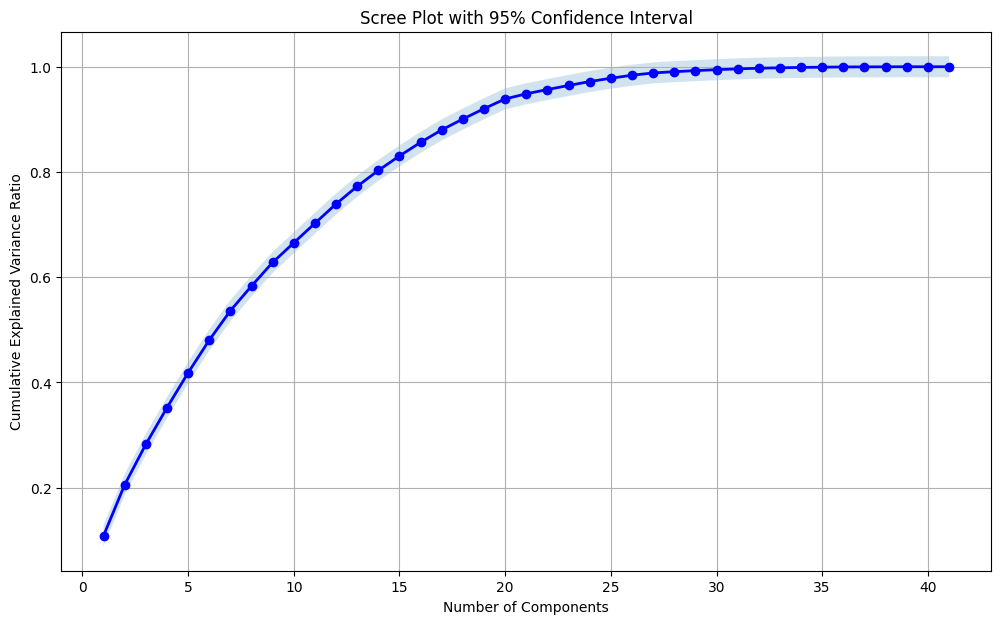

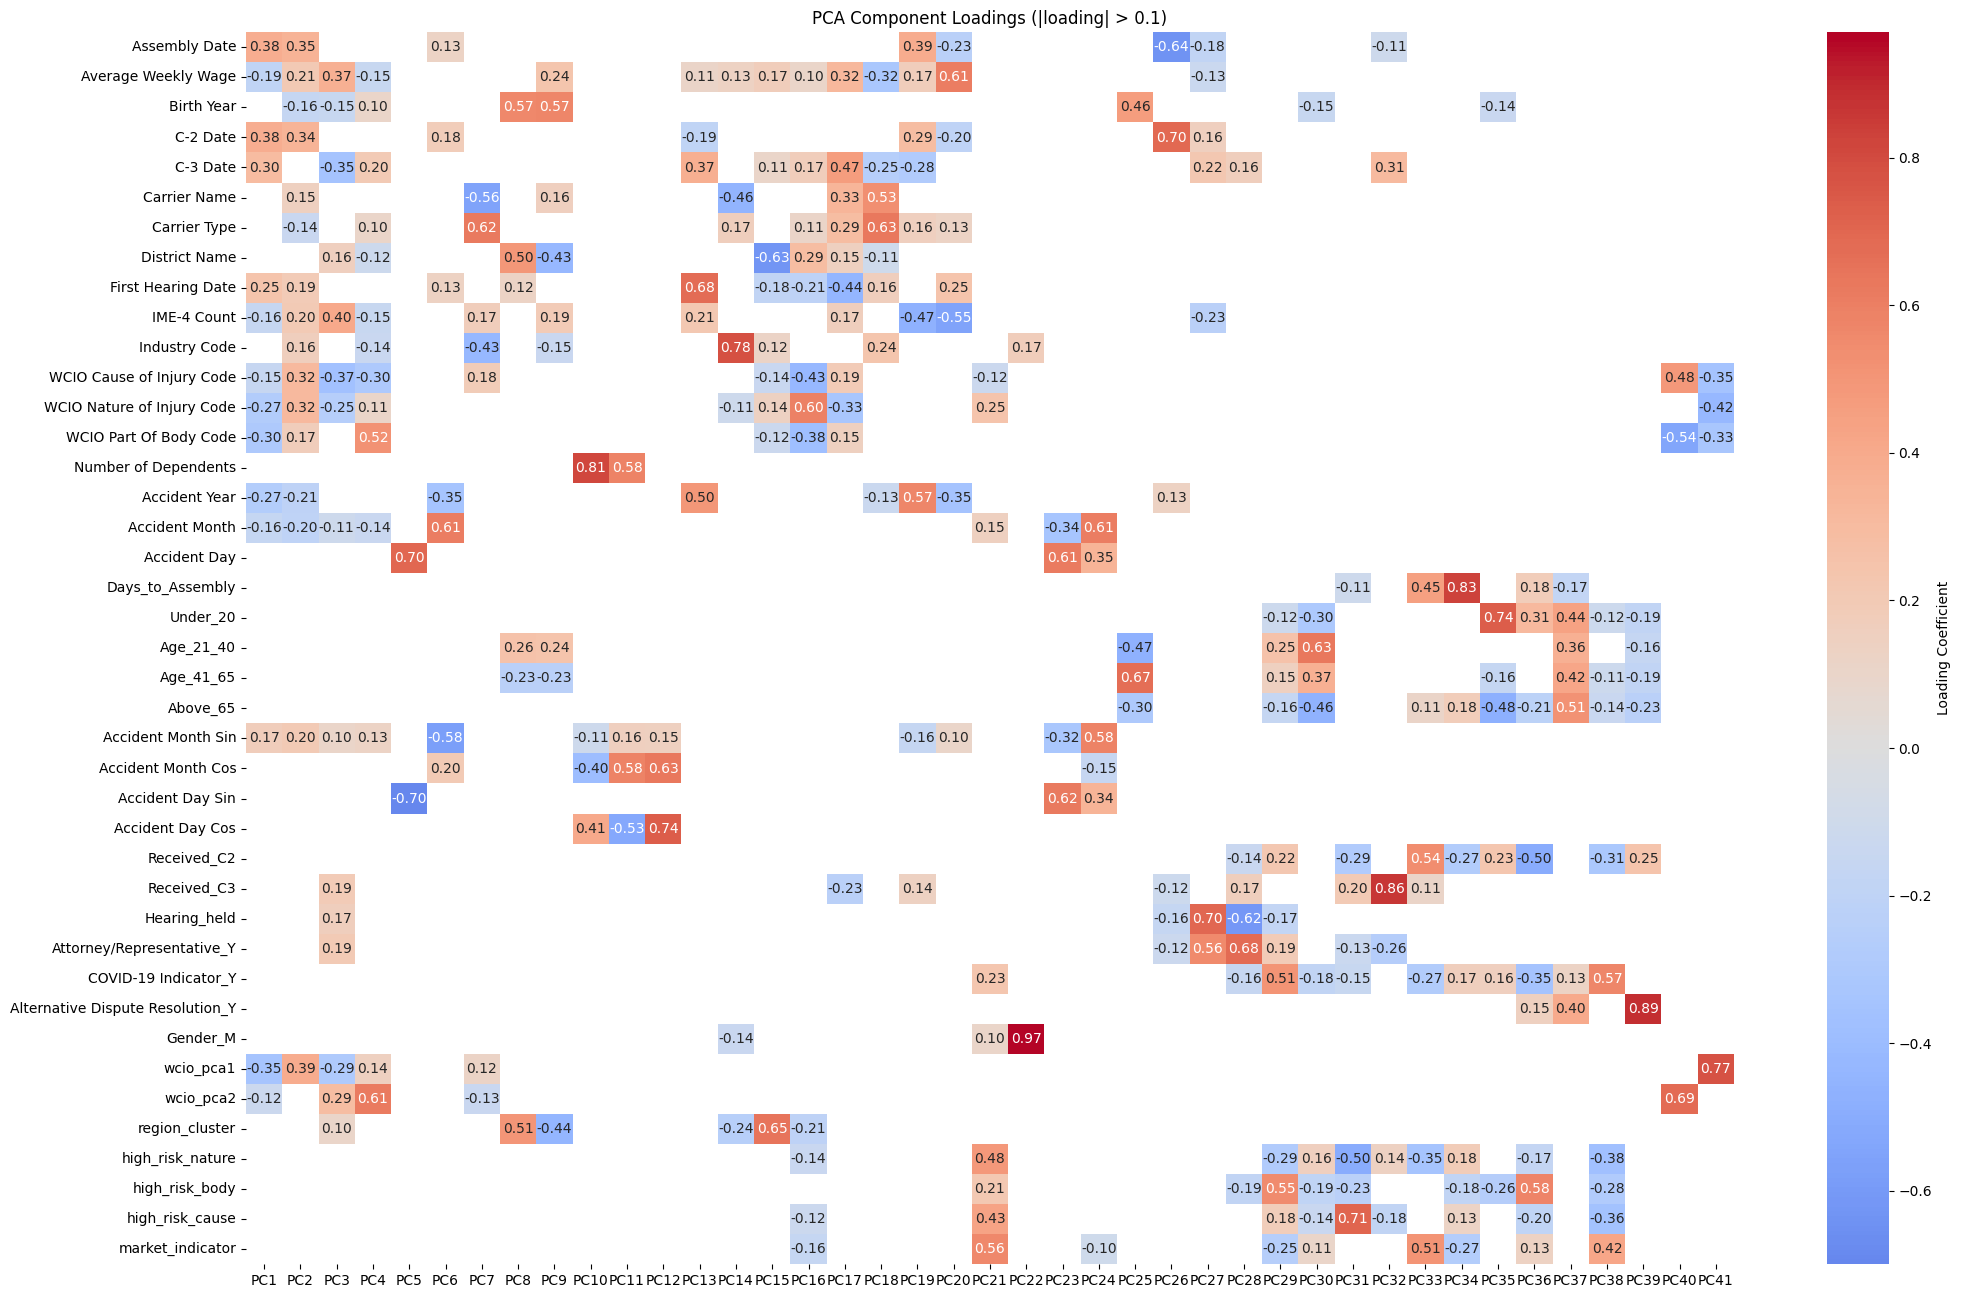

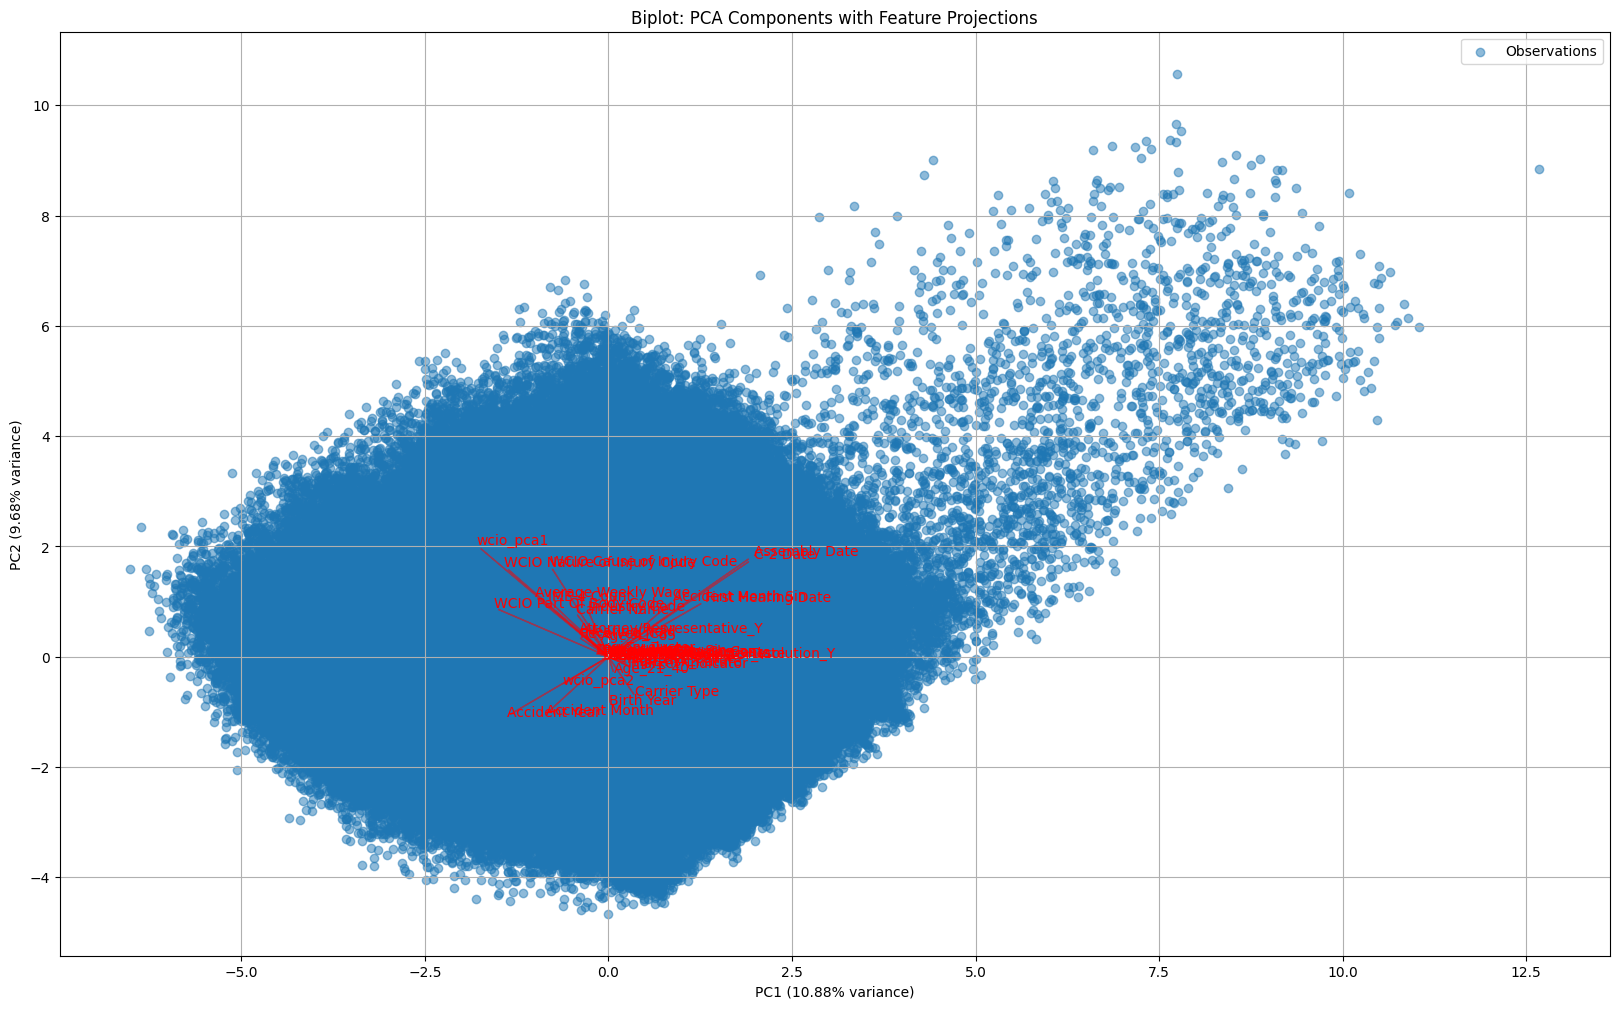


PCA Statistical Summary:
Number of components: 41
Total variance explained: 1.0000
Condition number: 1.39e+03

Kaiser criterion suggests 16 significant components

Principal component composition:

PC1 significant features (loading > 0.1):
C-2 Date: 0.381
Assembly Date: 0.381
wcio_pca1: -0.347
C-3 Date: 0.303
WCIO Part Of Body Code: -0.299
WCIO Nature of Injury Code: -0.272

PC2 significant features (loading > 0.1):
wcio_pca1: 0.391
Assembly Date: 0.354
C-2 Date: 0.344
WCIO Cause of Injury Code: 0.317
WCIO Nature of Injury Code: 0.315
Average Weekly Wage: 0.210

PC3 significant features (loading > 0.1):
IME-4 Count: 0.404
Average Weekly Wage: 0.366
WCIO Cause of Injury Code: -0.365
C-3 Date: -0.352
wcio_pca1: -0.292
wcio_pca2: 0.287


In [274]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def perform_pca_analysis(df, n_components=None, scale=True, categorical_columns=None):
    """
    Performs Principal Component Analysis with comprehensive diagnostics and validations.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataset for PCA
    n_components : int, optional
        Number of principal components to compute
    scale : bool, default=True
        Whether to standardize features before PCA
    categorical_columns : list, optional
        Columns to exclude from analysis

    Returns:
    --------
    dict
        Contains PCA model, transformed data, loadings, and variance explanations
    """
    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")

    # Make a copy to preserve original data
    df_copy = df.copy()

    # Remove categorical columns if specified
    if categorical_columns:
        df_copy = df_copy.drop(columns=categorical_columns)

    # Handle missing values and select numeric columns
    df_copy = df_copy.select_dtypes(include=[np.number])
    if df_copy.isnull().any().any():
        print("Warning: Missing values detected. Filling with feature means.")
        df_copy = df_copy.fillna(df_copy.mean())

    # Determine optimal number of components if not specified
    if n_components is None:
        n_components = min(df_copy.shape)

    # Standardization
    if scale:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df_copy)
    else:
        scaled_data = df_copy.values

    # Validate data conditioning
    if np.isnan(scaled_data).any() or np.isinf(scaled_data).any():
        raise ValueError("Invalid values detected after preprocessing")

    # Perform PCA with error handling
    try:
        pca = PCA(n_components=n_components)
        transformed_data = pca.fit_transform(scaled_data)
    except Exception as e:
        raise RuntimeError(f"PCA computation failed: {str(e)}")

    # Visualization with error handling
    try:
        # 1. Scree plot with confidence intervals
        plt.figure(figsize=(12, 7))
        cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
        plt.plot(range(1, len(cumulative_var_ratio) + 1),
                cumulative_var_ratio, 'bo-', linewidth=2)
        plt.fill_between(range(1, len(cumulative_var_ratio) + 1),
                        cumulative_var_ratio - 0.02,
                        cumulative_var_ratio + 0.02,
                        alpha=0.2)
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title('Scree Plot with 95% Confidence Interval')
        plt.grid(True)
        plt.show()

        # 2. Enhanced loadings heatmap
        loadings = pd.DataFrame(
            pca.components_.T,
            columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
            index=df_copy.columns
        )

        plt.figure(figsize=(24, 16))
        mask = np.abs(loadings) < 0.1  # Mask insignificant loadings
        sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0,
                   mask=mask, fmt='.2f', cbar_kws={'label': 'Loading Coefficient'})
        plt.title('PCA Component Loadings (|loading| > 0.1)')
        plt.show()

        # 3. Biplot of first two components
        if n_components >= 2:
            plt.figure(figsize=(20, 12))
            # Plot scores
            plt.scatter(transformed_data[:, 0], transformed_data[:, 1],
                       alpha=0.5, label='Observations')

            # Plot feature vectors
            for i, (feat, pc1, pc2) in enumerate(zip(df_copy.columns,
                                                   loadings['PC1'],
                                                   loadings['PC2'])):
                plt.arrow(0, 0, pc1*5, pc2*5, color='r', alpha=0.5)
                plt.text(pc1*5.2, pc2*5.2, feat, color='r')

            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            plt.title('Biplot: PCA Components with Feature Projections')
            plt.grid(True)
            plt.legend()
            plt.show()

    except Exception as e:
        print(f"Warning: Visualization failed: {str(e)}")

    # Comprehensive statistical summary
    print("\nPCA Statistical Summary:")
    print("="* 50)
    print(f"Number of components: {n_components}")
    print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.4f}")
    print(f"Condition number: {np.linalg.cond(scaled_data):.2e}")

    # Kaiser criterion analysis
    significant_pcs = sum(pca.explained_variance_ratio_ > 1/df_copy.shape[1])
    print(f"\nKaiser criterion suggests {significant_pcs} significant components")

    # Feature importance analysis
    n_top_features = min(6, len(df_copy.columns))
    print("\nPrincipal component composition:")
    for i in range(min(3, n_components)):
        sorted_loadings = loadings[f'PC{i+1}'].abs().sort_values(ascending=False)
        print(f"\nPC{i+1} significant features (loading > 0.1):")
        significant_loadings = sorted_loadings[sorted_loadings > 0.1]
        for feat, load in significant_loadings[:n_top_features].items():
            print(f"{feat}: {loadings.loc[feat, f'PC{i+1}']:.3f}")

    return {
        'pca': pca,
        'transformed_data': transformed_data,
        'loadings': loadings,
        'explained_variance': pca.explained_variance_ratio_,
        'scaler': scaler if scale else None
    }

pca_results = perform_pca_analysis(analysis_df, scale=False)

In [275]:
claim_injury_type = merged_df['Claim Injury Type']

In [276]:
!pip install xgboost

In [277]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_score, recall_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [ ]:
def process_and_predict(analysis_df, claim_injury_type, test_scaled):
    """
    Implementation with feature importance and additional performance metrics.
    """
    # Label encoding
    le = LabelEncoder()
    y = le.fit_transform(claim_injury_type)

    # Stratified split
    X_train, X_val, y_train, y_val = train_test_split(
        analysis_df, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    # Model with optimized parameters
    # model = XGBClassifier(
    #     objective='multi:softprob',
    #     random_state=42,
    #     learning_rate=0.03,
    #     max_depth=7,
    #     min_child_weight=5,
    #     subsample=0.8,
    #     colsample_bytree=0.6,
    #     n_estimators=1000,
    #     reg_alpha=1.0,
    #     reg_lambda=1.5
    # )

  # i think i scored 445 with this
        # Model 0.48
    model = XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        learning_rate=0.075,
        max_depth=18,      #
        min_child_weight=8,
        subsample=0.8,
        colsample_bytree=0.6,
        n_estimators=2000,
        reg_alpha=1.0,
        reg_lambda=1.5,
    )



    # Model fitting
    model.fit(X_train, y_train)

    # Predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(test_scaled)

    # Probability predictions for ROC AUC
    train_pred_proba = model.predict_proba(X_train)
    val_pred_proba = model.predict_proba(X_val)

    # Feature importance calculation
    feature_importance = pd.DataFrame({
        'feature': analysis_df.columns,
        'importance': model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    # Expanded metrics
    metrics = {
        'train_f1': f1_score(y_train, train_pred, average='macro'),
        'val_f1': f1_score(y_val, val_pred, average='macro'),
        'train_acc': accuracy_score(y_train, train_pred),
        'val_acc': accuracy_score(y_val, val_pred),
        'train_precision': precision_score(y_train, train_pred, average='macro'),
        'val_precision': precision_score(y_val, val_pred, average='macro'),
        'train_recall': recall_score(y_train, train_pred, average='macro'),
        'val_recall': recall_score(y_val, val_pred, average='macro'),
        'train_roc_auc': roc_auc_score(y_train, train_pred_proba, multi_class='ovr'),
        'val_roc_auc': roc_auc_score(y_val, val_pred_proba, multi_class='ovr')
    }

    # Classification reports
    print("\nTRAINING SET PERFORMANCE METRICS:")
    print(classification_report(y_train, train_pred))
    print("\nVALIDATION SET PERFORMANCE METRICS:")
    print(classification_report(y_val, val_pred))

    # Feature importance display
    print("\nFEATURE IMPORTANCE RANKING:")
    print(feature_importance.to_string(index=False))

    # Class distribution analysis
    print("\nCLASS DISTRIBUTION ANALYSIS:")
    print("Training Set Class Distribution:")
    print(pd.Series(y_train).value_counts(normalize=True))
    print("\nValidation Set Class Distribution:")
    print(pd.Series(y_val).value_counts(normalize=True))

    # Transform predictions
    test_pred_labels = le.inverse_transform(test_pred)

    return {
        'metrics': metrics,
        'test_predictions': test_pred_labels,
        'model': model,
        'label_encoder': le,
        'feature_importance': feature_importance
    }

# Execute analysis
try:
    results = process_and_predict(analysis_df, claim_injury_type, test_scaled)

    print("\nPERFORMANCE METRICS SUMMARY:")
    print(f"Train Accuracy: {results['metrics']['train_acc']:.4f}")
    print(f"Validation Accuracy: {results['metrics']['val_acc']:.4f}")
    print(f"Train F1-macro: {results['metrics']['train_f1']:.4f}")
    print(f"Validation F1-macro: {results['metrics']['val_f1']:.4f}")
    print(f"Train Precision: {results['metrics']['train_precision']:.4f}")
    print(f"Validation Precision: {results['metrics']['val_precision']:.4f}")
    print(f"Train Recall: {results['metrics']['train_recall']:.4f}")
    print(f"Validation Recall: {results['metrics']['val_recall']:.4f}")
    print(f"Train ROC AUC: {results['metrics']['train_roc_auc']:.4f}")
    print(f"Validation ROC AUC: {results['metrics']['val_roc_auc']:.4f}")

    # Save predictions
    predictions_df = pd.DataFrame({
        'Predicted_Claim_Injury_Type': results['test_predictions']
    })
    predictions_df.to_csv('test_predictions.csv', index=False)

    # Save feature importance
    results['feature_importance'].to_csv('feature_importance.csv', index=False)

except Exception as e:
    print(f"Error detected: {str(e)}")
    raise

In [279]:
!pip install --upgrade scikit-learn

In [280]:
!pip install optuna

In [281]:
# import optuna
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.preprocessing import LabelEncoder
# import numpy as np
# from optuna import TrialPruned
# from optuna.visualization import plot_optimization_history, plot_param_importances

# # Encode the target variable y
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)

# # Stratified split
# X_train, X_val, y_train, y_val = train_test_split(
#     analysis_df, y,
#     test_size=0.2,
#     random_state=42,
#     stratify=y
# )

# # Define the objective function with manual cross-validation
# def objective(trial):
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 16, 20),
#         'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.1),
#         'min_child_weight': trial.suggest_int('min_child_weight', 6, 10),
#         'subsample': trial.suggest_float('subsample', 0.7, 0.9),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.7),
#         'n_estimators': trial.suggest_int('n_estimators', 1500, 2500),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.8, 1.2),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1.3, 1.7),
#         'objective': 'multi:softprob',
#         'random_state': 42,
#     }




#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = []

#     for fold_index, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
#         X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#         y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

#         model = XGBClassifier(**params)
#         model.fit(X_fold_train, y_fold_train)

#         y_pred = model.predict(X_fold_val)
#         score = f1_score(y_fold_val, y_pred, average='macro')
#         scores.append(score)

#         # Report intermediate score for pruning
#         trial.report(np.mean(scores), step=fold_index)
#         if trial.should_prune():
#             raise TrialPruned()

#     return np.mean(scores)

# # Create a study and optimize the objective function with parallelization
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50, n_jobs=-1)

# # Get the best hyperparameters
# best_params = study.best_params

# # Train the final model with best hyperparameters
# final_model = XGBClassifier(**best_params, objective='multi:softprob', random_state=42)
# final_model.fit(X_train, y_train)

# # Evaluate the final model on the validation set
# y_pred = final_model.predict(X_val)
# f1_macro_score = f1_score(y_val, y_pred, average='macro')
# print(f"F1 Macro Score on Validation Set: {f1_macro_score:.4f}")

# # Decode the predicted labels back to original class names
# y_pred_decoded = label_encoder.inverse_transform(y_pred)
# print("Predicted Labels (Decoded):", y_pred_decoded)

# # Visualization of the optimization process
# plot_optimization_history(study).show()
# plot_param_importances(study).show()

# add this while optimizing for L4 use of google colab


# def get_quantum_stable_params():
#     return {
#         'tree_method': 'gpu_hist',  # ADD THIS!
#         'predictor': 'gpu_predictor',  # ADD THIS!
#         'learning_rate': 0.01,
#         'max_depth': 10,
#         'min_child_weight': 20,
#         'subsample': 0.6,
#         'colsample_bytree': 0.4,
#         'n_estimators': 300,
#         'reg_alpha': 7.5,
#         'reg_lambda': 12.0,
#         'random_state': 42
#     }





In [282]:
!pip install kaggle

In [283]:
import os
import json
import pandas as pd
import subprocess

# Create Kaggle credentials
credentials = {"username":"chielgroeneveld","key":"a823db81aa0c4aa800e0d8ad825fa855"}

# Ensure directory exists and write credentials
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(credentials, f)
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# Read the files and create submission
sample_submission = pd.read_csv('sample_submission.csv')
test_predictions = pd.read_csv('test_predictions.csv')

# Copy predictions into sample submission format
sample_submission['Claim Injury Type'] = test_predictions['Predicted_Claim_Injury_Type']

# Save as submission file
sample_submission.to_csv('submission.csv', index=False)

# Submit to Kaggle
try:
    result = subprocess.run(
        'kaggle competitions submit -c to-grant-or-not-to-grant -f submission.csv -m "group 19 submission"',
        shell=True,
        capture_output=True,
        text=True,
        check=True
    )
    print("Submission Output:", result.stdout)
    print("Submission Successful!")
except subprocess.CalledProcessError as e:
    print("Error:", e.stderr)
    print("Return Code:", e.returncode)

Submission Output: Successfully submitted to To Grant or Not to Grant
Submission Successful!
